# Benchmarking Geral

* `Objetivo:` Avaliar a classificação de séries temporais usando 3 diferentes abordagens, incluindo nossa hipótese, de codificar séries temporais através do Gráfico de Recorrência;

* `Cenário Comparativo`: 
    - <u>Dados:</u> Considerando os dados estabelecidos no *Benchmarking 1*;
        * *Detalhes:* Base REDD, baixa Frequência, Resid. 3, com 9 aparelhos (4k amostras treino/4k teste);
        * *Amostras:* Blocos de 1 minuto e 30 segundos (90 segundos - 30 'chunks', dado delay *3s*) de cada medição;
    
    - <u>Atributos *(Feature Space)*:</u> representação vetorial das amostras;
        1. **Abordagem Estatística (Benchmarking 1)**: Média, Desvio Padrão, Máximo, Energia Total, Hora do Dia e Temperatura Ambiente (zerado, neste caso, pois não foi disponibilizado pelos autores); 
        2. **Abordagem GAF (Benchmarking 2)**: Representação visual da amostra, através do algoritmo *Wang and Oates’[20]/Gramian Angular Field Matrices (GAF)*, e subsequente *embedding* com uma Rede Neural com arquitetura VGG16;
        3. **Abordagem RP (Hipótese 1)**: Nossa hipótese, converter a amostra em uma representação visual com a técnica de Gráfico de Recorrência (RP, do inglês *Recurrence Plot*); seguindo o *Benchmarking 2*, é realizado o *embedding* da imagem resultante com uma Rede Neural com arquitetura VGG16.
        4. **Abordagem RP+RQA (Hipótese 2)**: A partir do RP, extrair métricas de RQA, as quais alimentarão o classificador de cargas.
        
    - <u>Método de Classificação:</u> Rede Neural Multi-camadas (MLP, sem hiperparametrização - pacote [Scikit-lean](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier));
    
    - <u>Métrica(s):</u> uma vez que o problema irá ser tratado como classificação multi-rótulo, irão ser adotadas as seguintes métricas (via pacote [Scikit-learn.metrics](https://scikit-learn.org/stable/modules/model_evaluation.html))
        * Classificaton Report, contendo:
            * Acurácia;
            * Precisão;
            * Recall;
            * F1-score;
            * Hamming Loss;
            * Suporte (0/1);
        * Matriz de confusão.

# Configurando ambiente e parâmetros

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rc('text', usetex=False)
from matplotlib.image import imsave
import pandas as pd
import pickle as cPickle
import os, sys, cv2
from math import *
from pprint import pprint
from datetime import datetime
from time import time
from tqdm import tqdm_notebook, tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import Image
from glob import glob
from IPython.display import display

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.applications.vgg16 import preprocess_input

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from keras_tqdm import TQDMNotebookCallback
tqdm_callback = TQDMNotebookCallback()
setattr(tqdm_callback,'on_train_batch_begin',lambda x,y:None)
setattr(tqdm_callback,'on_train_batch_end',lambda x,y:None)
setattr(tqdm_callback,'on_test_batch_begin',lambda x,y:None)
setattr(tqdm_callback,'on_test_batch_end',lambda x,y:None)
setattr(tqdm_callback,'on_test_begin', lambda x:None)
setattr(tqdm_callback,'on_test_end', lambda x:None)

import random as rn

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import *

from pyts.image import RecurrencePlot, GramianAngularField

DATASET_PATH = 'datasets/REDD/phd'
SEED = 33
TEST_SIZE = 0.25

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

np.random.seed(SEED)
rn.seed(SEED)
os.environ['PYTHONHASHSEED']=str(SEED)
tf.random.set_seed(SEED)

# BENCHMARKING1_RESOURCES_PATH = 'benchmarkings/cs446 project-electric-load-identification-using-machine-learning/'
# BENCHMARKING2_RESOURCES_PATH = 'benchmarkings/Imaging-NILM-time-series/'
HYPOTHESIS_RESOURCES_PATH = 'datasets/hipotese1-recurrenceplot-vggembedding/'

# sys.path.append(os.path.join(BENCHMARKING1_RESOURCES_PATH, ''))
# sys.path.append(os.path.join(BENCHMARKING2_RESOURCES_PATH, ''))
# sys.path.append(os.path.join(HYPOTHESIS_RESOURCES_PATH, ''))

# from serie2QMlib import *

import warnings
warnings.filterwarnings(action='ignore')

Using TensorFlow backend.


In [2]:
tf.__version__

'2.0.0'

In [3]:
tf.test.is_built_with_cuda()

True

In [4]:
# tf.debugging.set_log_device_placement(False)

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
            

#         tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
#         logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Carregando os dados

In [6]:
# dataset_size = 404107

# fileprefix = 'channel_'

# # devices to be used in training and testing
# use_idx = np.array([3,4,6,7,10,11,13,17,19])

# label_columns_idx = ["APLIANCE_{}".format(i) for i in use_idx]

# appliance_labels = [
#     "Electronics", 
#     "Refrigerator", 
#     "Dishwasher",
#     "Furnace", 
#     "Washer Dryer 1", 
#     "Washer Dryer 2", 
#     "Microwave", 
#     "Bathroom GFI",
#     "Kitchen Outlets"
# ]

# # Select some appliances for paper
# valid_appliances = [
#     "Refrigerator", "Dishwasher", "Furnace", "Wash Dryer 1", "Microwave"
# ]
# valid_appliances_index = [
#     1, 2, 3, 4, 6
# ]
# #np.array(appliance_labels)[valid_appliances_index])

In [7]:
# For the development of the proposed system based on a Neural Convolutional Network to identify the equipment, 
# in an initial phase, 6 equipment were chosen: 
# microwave, oven, dishwasher, air conditioning, washer / dryer and refrigerator. 
# The chosen equipment can be considered the most energy consuming in a residence. According to Batra [16], it is 
# necessary to prioritize the identification of equipment with higher energy consumption in the residences, since 
# these devices contribute with the most significant characteristics in the aggregate load, and the other appliances, 
# with lower consumption, can only be considered as noise in the load total aggregate.

appliances = [
    {"channel": 1, "name": "mains 1"},
    {"channel": 2, "name": "mains 2"},
    {"channel": 7, "name": "refrigerator"},
    {"channel": 9, "name": "dishwasher"},
    {"channel": 13, "name": "washer dryer 1"},
    {"channel": 14, "name": "washer dryer 2"},
    {"channel": 16, "name": "microwave"}
]

valid_appliances = appliances
## TODO: Adaptative length ny appliance...
# Microwave 191
# Dishwasher 588
# Refrigerator 2401

# Reading pre-processed data
mains = []
labels_power = []
labels_binary = []
valid_appliances = []

for a in tqdm(appliances):
    
    if a["channel"] in [1, 2]: # Mains
        file_chunks = glob(os.path.join(DATASET_PATH, "{}-*.npy".format(a["channel"])))[0]
        mains.append(np.load(file_chunks))
    else:
        #file_total = glob(os.path.join(DATASET_PATH, "{}-*total.npy".format(a["channel"])))[0]
        #labels_power.append(np.load(file_total))

        file_binary = glob(os.path.join(DATASET_PATH, "{}-*_binary.npy".format(a["channel"])))[0]
        labels_binary.append(np.load(file_binary))
        
        valid_appliances.append(a["name"])

mains = np.array(mains)
mains_idx = 0
#labels_power = np.array(labels_power).T
labels_binary = np.array(labels_binary).T

100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 175.49it/s]


In [8]:
# X_train_multilabel, X_test_multilabel, y_train_multilabel, y_test_multilabel = train_test_split(
#     mains_1, labels_binary,
#     #stratify = labels_binary,
#     random_state=SEED, test_size=0.1, shuffle=True
# )

# Funções

In [9]:
def plot_predicted_and_ground_truth(test, predicted):
    #import matplotlib.pyplot as plt
    plt.plot(predicted.flatten(), label = 'pred')
    plt.plot(test.flatten(), label= 'Y')
    plt.show();
    return

def classification_report(y_test, y_pred, labels = None):
    
    final_performance = []
    
    for i in range(y_test.shape[1]):
    
        test = y_test[:, i]
        predicted = y_pred[:, i]
        #acc, prec, rec, f1, f1m, hl, supp = metrics(y_test[:, i], y_pred[:, i])
        acc = accuracy_score(test, predicted)
        prec = precision_score(test, predicted)
        rec = recall_score(test, predicted)    
        f1 = f1_score(test, predicted)
        f1m = f1_score(test, predicted, average='macro')
        hl = hamming_loss(test, predicted)   
        auc_ = roc_auc_score(test, predicted)
        y_i = y_test[:, i]
        supp_0 = y_i[y_i==0].shape[0]
        supp_1 = y_i[y_i==1].shape[0]

        final_performance.append([
            labels[i] if labels is not None else label_columns_idx[i], 
            round(acc*100, 2), 
            round(prec*100, 2), 
            round(rec*100, 2), 
            round(f1*100, 2), 
            round(f1m*100, 2),
            round(hl, 2),
            round(auc_, 2),
            supp_0,
            supp_1
        ])

    print("CLASSIFIER PERFORMANCE BY APPLIANCE (LABEL):")
    df_metrics = pd.DataFrame(
        data = final_performance,
        columns = ["Appliance", "Accuracy", "Precision", "Recall", "F1-score", "F1-macro", "Hamming Loss", "AUC", "Support (y=0)", "Support (y=1)"]
    )
    display(df_metrics)

    print("")
    print("OVERALL AVERAGE PERFORMANCE:")
    display(df_metrics.describe().round(2).loc[['mean','max','min']])
    
    print("")
    print("CONFUSION MATRIX (OFF/ON), BY APPLIANCE:")
    
    cms = multilabel_confusion_matrix(y_test, y_pred)
    for i, a in enumerate(labels):
        print("")
        print(" - {}:".format(a))
        print(cms[i])
    #print(, labels= appliance_labels)


    
def classification_report_appliance(y_test, y_pred, label = None):
    
    final_performance = []
    
    test = y_test
    predicted = y_pred
    #acc, prec, rec, f1, f1m, hl, supp = metrics(y_test[:, i], y_pred[:, i])
    acc = accuracy_score(test, predicted)
    prec = precision_score(test, predicted)
    rec = recall_score(test, predicted)    
    f1 = f1_score(test, predicted)
    f1m = f1_score(test, predicted, average='macro')
    hl = hamming_loss(test, predicted)   
    auc_ = roc_auc_score(test, predicted)
    y_i = y_test
    supp_0 = y_i[y_i==0].shape[0]
    supp_1 = y_i[y_i==1].shape[0]

    final_performance = [[
        label, 
        round(acc*100, 2), 
        round(prec*100, 2), 
        round(rec*100, 2), 
        round(f1*100, 2), 
        round(f1m*100, 2),
        round(hl, 2),
        round(auc_, 2),
        supp_0,
        supp_1
    ]]

    print("CLASSIFIER PERFORMANCE {} MODEL:".format(label.upper()))
    df_metrics = pd.DataFrame(
        data = final_performance,
        columns = ["Appliance", "Accuracy", "Precision", "Recall", "F1-score", "F1-macro", "Hamming Loss", "AUC", "Support (y=0)", "Support (y=1)"]
    )
    display(df_metrics)

#     print("")
#     print("OVERALL AVERAGE PERFORMANCE:")
#     display(df_metrics.describe().round(2).loc[['mean','max','min']])
    
    print("")
    print("CONFUSION MATRIX (OFF/ON):")
    
    cms = confusion_matrix(y_test, y_pred)
    for i, a in enumerate([label]):
        print("")
        print(" - {}:".format(a))
        print(cms)

In [10]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [11]:
def calculate_metrics(estimator, X_test, y_test):
    y_pred = np.array(estimator.model.predict(X_test).round()) # TODO: corrigir '.model' (https://github.com/keras-team/keras/issues/9331)
    return (
        accuracy_score(y_test, y_pred), 
        precision_score(y_test, y_pred, average='macro'), 
        recall_score(y_test, y_pred, average='macro'),
        f1_score(y_test, y_pred, average='micro'),
        f1_score(y_test, y_pred, average='macro')
    )

def global_scorer(estimator, X_test, y_test):
    acc, prec, rec, f1_micro, f1m = calculate_metrics(estimator, X_test, y_test)
    return acc, prec, rec, f1_micro, f1m

def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    acc, prec, rec, f1_micro, f1m = global_scorer(model, X_test, y_test)
    return [acc, prec, rec, f1_micro, f1m]

#label_encoder = LabelEncoder()

kfold = StratifiedKFold(
    n_splits=10, 
    shuffle=True, 
    random_state= 33
)

# Deep Learning

## Funções Auxiliares

In [12]:
import shutil
from tensorflow.keras import optimizers

class ImageProcessing():
    def __init__(self, image_size_px = 128, Y = None):
        self.image_size_px = image_size_px
        
    def fit(self, images, Y = None, mode = "train"):
        return self

    def transform(self, images, Y = None, mode = 'train'):
        processed_images = []
        try:
#             for idx, image in tqdm_notebook(enumerate(images), total=len(images)):
#                 img = np.stack((image,) * 3, -1)
#                 processed_images.append(img/255)
            if os.path.isdir(os.path.join(HYPOTHESIS_RESOURCES_PATH, "temp")):        
                shutil.rmtree(os.path.join(HYPOTHESIS_RESOURCES_PATH, "temp"))
            os.makedirs(os.path.join(HYPOTHESIS_RESOURCES_PATH, "temp"))
                
            for idx, image in tqdm_notebook(enumerate(images)):
#                 labels = Y[idx, :].astype('str').tolist()
#                 labels_str = ''.join(labels)
                image_path = os.path.join( 
                        HYPOTHESIS_RESOURCES_PATH, "temp",
                        "{}_{}_color.png".format(idx, mode) 
                    )
                imsave(
                    image_path, 
                    arr=image
                )
                # Reading image in 3channel RGB mode
                img = keras_image.load_img( image_path, target_size=(self.image_size_px, self.image_size_px ,3))
                img = keras_image.img_to_array(img)
                img = img/255                
                #img = MinMaxScaler(feature_range=(-1, 1)).fit_transform(img.reshape(1,-1)).reshape(img.shape)
                processed_images.append(img)
            
            shutil.rmtree(os.path.join(HYPOTHESIS_RESOURCES_PATH, "temp"))
            
        except Exception as err:
            print('ImageProcessing.transform(): {}'.format(err))
            
        return np.array(processed_images)
        #return processed_images

    def fit_transform(self, images, Y = None, mode = 'train'):
        self.fit(images)
        return self.transform(images, Y, mode)

## Arquiteturas de CNN

In [13]:
#from keras.callbacks import TensorBoard

#################################### MODELOS 
def dcnn_multilabel(output_layer_length = len(valid_appliances)):
    model = Sequential()

#     model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(128,128,3)))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.25))
#     model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.25))
#     model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.25))
#     model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.25))
#     model.add(Flatten())
#     model.add(Dense(128, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(64, activation='relu'))
#     model.add(Dropout(0.5))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=input_shape_))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))    
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(output_layer_length, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1])
    
    return model

# For training of the CNN a fixed size window as input layer is required. In the
# experiments 28×28, 56×56 and 64×64 pixel input, depend on the data, are used. Both layers contain 32 feature
# maps with 3×3 convolution (32×3×3), MaxPooling of size 2×2 and Dropout = 0.25. The fully connected neural
# layer contains 128 hidden neurons and c output neurons with Dropout = 0.5.
def dcnn_appliance(input_shape_ = (128,128,3), loss_function = 'binary_crossentropy'):
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=input_shape_))
#     model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=input_shape_))
#     model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
#     model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))    
#     model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.25))
#     model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.25))
    
#     model.add(Flatten())
#     model.add(Dense(128, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(64, activation='relu'))
#     model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
#     model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.25))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss=[loss_function], metrics=['accuracy', f1])
    
    return model

def vgg_multilabel():
    base_model = VGG16(
        weights='imagenet',
        #weights = None,
        include_top=False, #imports the mobilenet model and discards the last neuron layer.
        input_shape = train_rp_images[0].shape
    ) 
    # mark loaded layers as not trainable
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    x = Dense(128,activation='relu')(x) #dense layer 2
    x = Dropout(0.5)(x)
    x = Dense(64,activation='relu')(x) #dense layer 3
    x = Dropout(0.5)(x)
    
    output_layer = Dense(len(valid_appliances), activation='softmax')(x) #final layer with softmax activation
    
    model = Model(
        inputs  = base_model.input,
        outputs = output_layer
    )    
    model.compile(
        optimizer=optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True),
        loss='categorical_crossentropy',
        metrics=['accuracy', f1]
    )
    
    return model

def vgg_appliance():
    base_model = VGG16(
        weights='imagenet',
        #weights = None,
        include_top=False, #imports the mobilenet model and discards the last neuron layer.
        input_shape = (128, 128, 3)
    ) 
    # mark loaded layers as not trainable
    for layer in base_model.layers:
        layer.trainable = False
    x=base_model.output
    x=GlobalAveragePooling2D()(x)
    
#     #x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
#     x=Dense(1024,activation='relu')(x) #dense layer 2
#     x=Dense(512,activation='relu')(x) #dense layer 3
#     #output_layer = Dense(2, activation='softmax')(x) #final layer with softmax activation
    
    x = Flatten()(x)
    x = Dense(128,activation='relu')(x) #dense layer 2
    x = Dropout(0.5)(x)
    x = Dense(64,activation='relu')(x) #dense layer 3
    x = Dropout(0.5)(x)
    
    output_layer = Dense(1, activation='sigmoid')(x)
    
    model = Model(
        inputs  = base_model.input,
        outputs = output_layer
    )    
    model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy', f1])
    
    return model

def tiled_cnn_multilabel( ):
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=(128,128,3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(len(valid_appliances), activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1])
    
    return model

def tiled_cnn_appliance( ):
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=(128,128,3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1])
    
    return model

In [14]:
EPOCHS = 1000
BATCH_SIZE = 256

## Imagens GAF

In [15]:
if not os.path.isfile( os.path.join(DATASET_PATH, "gaf_images.npy") ):
    
    print("Generating GAF images from data...")
    gaf_pipeline = Pipeline([
        ('gramianangularfield', GramianAngularField()),
        ('imageprocessing', ImageProcessing())
    ])
    series_images = gaf_pipeline.fit_transform(mains[mains_idx,:,:], imageprocessing__mode = "_")
    np.save(os.path.join(DATASET_PATH, "gaf_images.npy"), series_images)
    
else:
    print("Loading GAF images...")
    series_images = np.load(os.path.join(DATASET_PATH, "gaf_images.npy"))

Loading GAF images...


In [16]:
# X_train, X_test, y_train, y_test = train_test_split(
#     series_images, labels_binary,
#     #stratify = labels_binary,
#     random_state=SEED, test_size=TEST_SIZE, shuffle=True
# )

# print("X_train shape:", X_train.shape)
# print("y_train shape:", y_train.shape)
# print("---")
# print("X_test shape:", X_test.shape)
# print("y_test shape:", y_test.shape)

# del series_images

### Classificador Multilabel

In [ ]:
# Model fit...
print("Training GAF multilabel model...")

multiabel_gaf_model = dcnn_multilabel()#vgg_model_multilabel()

callback = multiabel_gaf_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test), 
    epochs=100, 
    batch_size=32,
    verbose = 2, callbacks = [tbCallback]
)

# Plot metrics...
fig = plt.figure(figsize=(13,5))
line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
line_f1_m = plt.plot(callback.history["f1"], label = "Train F1", color = "b")
line_val_f1_m = plt.plot(callback.history["val_f1"], label = "Test F1", color = "y")
plt.title("Model Train History")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.show()

# Final report (validated on test set)
y_pred = np.array(multiabel_gaf_model.predict(X_test).round())
classification_report(y_test, y_pred, labels = valid_appliances)

Training GAF multilabel model...
Train on 38704 samples, validate on 4301 samples
Epoch 1/100


In [ ]:
# Model fit...
print("Training GAF multilabel model...")

multiabel_gaf_model = tiled_cnn_multilabel()#vgg_model_multilabel()

callback = multiabel_gaf_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test), 
    epochs=100, 
    batch_size=32,
    verbose = 2, callbacks = [tbCallback]
)

# Plot metrics...
fig = plt.figure(figsize=(13,5))
line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
line_f1_m = plt.plot(callback.history["f1"], label = "Train F1", color = "b")
line_val_f1_m = plt.plot(callback.history["val_f1"], label = "Test F1", color = "y")
plt.title("Model Train History")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.show()

# Final report (validated on test set)
y_pred = np.array(multiabel_gaf_model.predict(X_test).round())
classification_report(y_test, y_pred, labels = valid_appliances)

In [ ]:
# Model fit...
print("Training GAF multilabel model...")

multiabel_gaf_model = vgg_model_multilabel()

callback = multiabel_gaf_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test), 
    epochs=100, 
    batch_size=32,
    verbose = 2, callbacks = [tbCallback]
)

# Plot metrics...
fig = plt.figure(figsize=(13,5))
line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
line_f1 = plt.plot(callback.history["f1"], label = "Train F1", color = "b")
line_val_f1 = plt.plot(callback.history["val_f1"], label = "Test F1", color = "y")
plt.title("Model Train History")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.show()

# Final report (validated on test set)
y_pred = np.array(multiabel_gaf_model.predict(X_test).round())
classification_report(y_test, y_pred, labels = valid_appliances)

### Classificadores Especialistas (Binários)


---> Splitting `{}` data (train/test)...
---> Training the `refrigerator` model...

Train on 32253 samples, validate on 10752 samples
Epoch 1/1000
32253/32253 - 34s - loss: 0.4777 - accuracy: 0.8159 - f1: 0.8982 - val_loss: 0.4839 - val_accuracy: 0.8168 - val_f1: 0.8990
Epoch 2/1000
32253/32253 - 22s - loss: 0.4522 - accuracy: 0.8168 - f1: 0.8990 - val_loss: 0.4915 - val_accuracy: 0.8168 - val_f1: 0.8990
Epoch 3/1000
32253/32253 - 21s - loss: 0.4515 - accuracy: 0.8168 - f1: 0.8990 - val_loss: 0.4819 - val_accuracy: 0.8168 - val_f1: 0.8990
Epoch 4/1000
32253/32253 - 21s - loss: 0.4502 - accuracy: 0.8168 - f1: 0.8990 - val_loss: 0.4763 - val_accuracy: 0.8168 - val_f1: 0.8990
Epoch 5/1000
32253/32253 - 21s - loss: 0.4504 - accuracy: 0.8168 - f1: 0.8990 - val_loss: 0.4854 - val_accuracy: 0.8168 - val_f1: 0.8990
Epoch 6/1000
32253/32253 - 21s - loss: 0.4489 - accuracy: 0.8168 - f1: 0.8990 - val_loss: 0.4710 - val_accuracy: 0.8168 - val_f1: 0.8990
Epoch 7/1000
32253/32253 - 21s - loss: 0.44

Epoch 60/1000
32253/32253 - 20s - loss: 0.3657 - accuracy: 0.8373 - f1: 0.9090 - val_loss: 0.7553 - val_accuracy: 0.8132 - val_f1: 0.8967
Epoch 61/1000
32253/32253 - 20s - loss: 0.3665 - accuracy: 0.8357 - f1: 0.9081 - val_loss: 0.7620 - val_accuracy: 0.8132 - val_f1: 0.8967
Epoch 62/1000
32253/32253 - 20s - loss: 0.3671 - accuracy: 0.8366 - f1: 0.9085 - val_loss: 0.7610 - val_accuracy: 0.8133 - val_f1: 0.8968
Epoch 63/1000
32253/32253 - 20s - loss: 0.3664 - accuracy: 0.8366 - f1: 0.9086 - val_loss: 0.7695 - val_accuracy: 0.8133 - val_f1: 0.8968
Epoch 64/1000
32253/32253 - 20s - loss: 0.3651 - accuracy: 0.8372 - f1: 0.9090 - val_loss: 0.7817 - val_accuracy: 0.8130 - val_f1: 0.8966
Epoch 65/1000
32253/32253 - 20s - loss: 0.3660 - accuracy: 0.8368 - f1: 0.9087 - val_loss: 0.7726 - val_accuracy: 0.8116 - val_f1: 0.8957
Epoch 66/1000
32253/32253 - 20s - loss: 0.3652 - accuracy: 0.8378 - f1: 0.9092 - val_loss: 0.8414 - val_accuracy: 0.8143 - val_f1: 0.8974
Epoch 67/1000
32253/32253 - 20s - 

Epoch 120/1000
32253/32253 - 20s - loss: 0.3590 - accuracy: 0.8394 - f1: 0.9102 - val_loss: 1.0950 - val_accuracy: 0.8132 - val_f1: 0.8967
Epoch 121/1000
32253/32253 - 20s - loss: 0.3607 - accuracy: 0.8390 - f1: 0.9099 - val_loss: 0.9960 - val_accuracy: 0.8130 - val_f1: 0.8966
Epoch 122/1000
32253/32253 - 20s - loss: 0.3578 - accuracy: 0.8400 - f1: 0.9105 - val_loss: 1.0406 - val_accuracy: 0.8137 - val_f1: 0.8971
Epoch 123/1000
32253/32253 - 20s - loss: 0.3587 - accuracy: 0.8395 - f1: 0.9102 - val_loss: 0.9852 - val_accuracy: 0.8124 - val_f1: 0.8963
Epoch 124/1000
32253/32253 - 20s - loss: 0.3587 - accuracy: 0.8398 - f1: 0.9104 - val_loss: 1.0093 - val_accuracy: 0.8140 - val_f1: 0.8972
Epoch 125/1000
32253/32253 - 20s - loss: 0.3573 - accuracy: 0.8402 - f1: 0.9107 - val_loss: 0.9810 - val_accuracy: 0.8132 - val_f1: 0.8967
Epoch 126/1000
32253/32253 - 20s - loss: 0.3590 - accuracy: 0.8397 - f1: 0.9103 - val_loss: 0.9954 - val_accuracy: 0.8132 - val_f1: 0.8967
Epoch 127/1000
32253/32253 

Epoch 179/1000
32253/32253 - 20s - loss: 0.3562 - accuracy: 0.8404 - f1: 0.9107 - val_loss: 1.1271 - val_accuracy: 0.8135 - val_f1: 0.8970
Epoch 180/1000
32253/32253 - 20s - loss: 0.3561 - accuracy: 0.8407 - f1: 0.9109 - val_loss: 1.1749 - val_accuracy: 0.8135 - val_f1: 0.8970
Epoch 181/1000
32253/32253 - 20s - loss: 0.3563 - accuracy: 0.8404 - f1: 0.9108 - val_loss: 1.1642 - val_accuracy: 0.8107 - val_f1: 0.8953
Epoch 182/1000
32253/32253 - 20s - loss: 0.3580 - accuracy: 0.8402 - f1: 0.9106 - val_loss: 1.0717 - val_accuracy: 0.8132 - val_f1: 0.8968
Epoch 183/1000
32253/32253 - 20s - loss: 0.3572 - accuracy: 0.8401 - f1: 0.9106 - val_loss: 1.1484 - val_accuracy: 0.8134 - val_f1: 0.8969
Epoch 184/1000
32253/32253 - 20s - loss: 0.3571 - accuracy: 0.8396 - f1: 0.9103 - val_loss: 1.1631 - val_accuracy: 0.8133 - val_f1: 0.8968
Epoch 185/1000
32253/32253 - 20s - loss: 0.3566 - accuracy: 0.8405 - f1: 0.9108 - val_loss: 1.1594 - val_accuracy: 0.8144 - val_f1: 0.8975
Epoch 186/1000
32253/32253 

Epoch 238/1000
32253/32253 - 20s - loss: 0.3552 - accuracy: 0.8409 - f1: 0.9110 - val_loss: 1.2009 - val_accuracy: 0.8131 - val_f1: 0.8967
Epoch 239/1000
32253/32253 - 20s - loss: 0.3561 - accuracy: 0.8408 - f1: 0.9110 - val_loss: 1.1845 - val_accuracy: 0.8121 - val_f1: 0.8961
Epoch 240/1000
32253/32253 - 20s - loss: 0.3565 - accuracy: 0.8404 - f1: 0.9108 - val_loss: 1.2357 - val_accuracy: 0.8125 - val_f1: 0.8963
Epoch 241/1000
32253/32253 - 20s - loss: 0.3566 - accuracy: 0.8405 - f1: 0.9108 - val_loss: 1.2161 - val_accuracy: 0.8131 - val_f1: 0.8967
Epoch 242/1000
32253/32253 - 20s - loss: 0.3570 - accuracy: 0.8404 - f1: 0.9107 - val_loss: 1.2937 - val_accuracy: 0.8136 - val_f1: 0.8970
Epoch 243/1000
32253/32253 - 20s - loss: 0.3545 - accuracy: 0.8409 - f1: 0.9111 - val_loss: 1.2227 - val_accuracy: 0.8123 - val_f1: 0.8962
Epoch 244/1000
32253/32253 - 20s - loss: 0.3552 - accuracy: 0.8409 - f1: 0.9110 - val_loss: 1.2774 - val_accuracy: 0.8141 - val_f1: 0.8973
Epoch 245/1000
32253/32253 

Epoch 297/1000
32253/32253 - 20s - loss: 0.3555 - accuracy: 0.8410 - f1: 0.9111 - val_loss: 1.1513 - val_accuracy: 0.8124 - val_f1: 0.8963
Epoch 298/1000
32253/32253 - 20s - loss: 0.3555 - accuracy: 0.8408 - f1: 0.9110 - val_loss: 1.2412 - val_accuracy: 0.8134 - val_f1: 0.8969
Epoch 299/1000
32253/32253 - 20s - loss: 0.3544 - accuracy: 0.8411 - f1: 0.9111 - val_loss: 1.2811 - val_accuracy: 0.8141 - val_f1: 0.8973
Epoch 300/1000
32253/32253 - 20s - loss: 0.3539 - accuracy: 0.8413 - f1: 0.9113 - val_loss: 1.2705 - val_accuracy: 0.8129 - val_f1: 0.8965
Epoch 301/1000
32253/32253 - 20s - loss: 0.3537 - accuracy: 0.8412 - f1: 0.9112 - val_loss: 1.3124 - val_accuracy: 0.8140 - val_f1: 0.8972
Epoch 302/1000
32253/32253 - 20s - loss: 0.3546 - accuracy: 0.8412 - f1: 0.9112 - val_loss: 1.3178 - val_accuracy: 0.8135 - val_f1: 0.8970
Epoch 303/1000
32253/32253 - 20s - loss: 0.3550 - accuracy: 0.8409 - f1: 0.9110 - val_loss: 1.2745 - val_accuracy: 0.8135 - val_f1: 0.8970
Epoch 304/1000
32253/32253 

Epoch 356/1000
32253/32253 - 20s - loss: 0.3547 - accuracy: 0.8410 - f1: 0.9111 - val_loss: 1.3067 - val_accuracy: 0.8126 - val_f1: 0.8964
Epoch 357/1000
32253/32253 - 20s - loss: 0.3565 - accuracy: 0.8405 - f1: 0.9108 - val_loss: 1.1440 - val_accuracy: 0.8121 - val_f1: 0.8961
Epoch 358/1000
32253/32253 - 20s - loss: 0.3559 - accuracy: 0.8404 - f1: 0.9107 - val_loss: 1.2803 - val_accuracy: 0.8133 - val_f1: 0.8969
Epoch 359/1000
32253/32253 - 20s - loss: 0.3545 - accuracy: 0.8410 - f1: 0.9111 - val_loss: 1.2471 - val_accuracy: 0.8137 - val_f1: 0.8971
Epoch 360/1000
32253/32253 - 20s - loss: 0.3537 - accuracy: 0.8413 - f1: 0.9112 - val_loss: 1.4485 - val_accuracy: 0.8140 - val_f1: 0.8972
Epoch 361/1000
32253/32253 - 20s - loss: 0.3563 - accuracy: 0.8406 - f1: 0.9109 - val_loss: 1.1856 - val_accuracy: 0.8120 - val_f1: 0.8960
Epoch 362/1000
32253/32253 - 20s - loss: 0.3546 - accuracy: 0.8410 - f1: 0.9111 - val_loss: 1.2681 - val_accuracy: 0.8130 - val_f1: 0.8966
Epoch 363/1000
32253/32253 

Epoch 415/1000
32253/32253 - 20s - loss: 0.3543 - accuracy: 0.8412 - f1: 0.9112 - val_loss: 1.3235 - val_accuracy: 0.8122 - val_f1: 0.8962
Epoch 416/1000
32253/32253 - 20s - loss: 0.3537 - accuracy: 0.8411 - f1: 0.9111 - val_loss: 1.4064 - val_accuracy: 0.8125 - val_f1: 0.8964
Epoch 417/1000
32253/32253 - 20s - loss: 0.3550 - accuracy: 0.8412 - f1: 0.9112 - val_loss: 1.2590 - val_accuracy: 0.8128 - val_f1: 0.8965
Epoch 418/1000
32253/32253 - 20s - loss: 0.3549 - accuracy: 0.8410 - f1: 0.9111 - val_loss: 1.3070 - val_accuracy: 0.8127 - val_f1: 0.8965
Epoch 419/1000
32253/32253 - 20s - loss: 0.3537 - accuracy: 0.8411 - f1: 0.9112 - val_loss: 1.3351 - val_accuracy: 0.8135 - val_f1: 0.8970
Epoch 420/1000
32253/32253 - 20s - loss: 0.3535 - accuracy: 0.8412 - f1: 0.9113 - val_loss: 1.3015 - val_accuracy: 0.8132 - val_f1: 0.8968
Epoch 421/1000
32253/32253 - 20s - loss: 0.3536 - accuracy: 0.8414 - f1: 0.9113 - val_loss: 1.2997 - val_accuracy: 0.8118 - val_f1: 0.8959
Epoch 422/1000
32253/32253 

Epoch 474/1000
32253/32253 - 20s - loss: 0.3542 - accuracy: 0.8413 - f1: 0.9113 - val_loss: 1.3346 - val_accuracy: 0.8134 - val_f1: 0.8969
Epoch 475/1000
32253/32253 - 20s - loss: 0.3535 - accuracy: 0.8414 - f1: 0.9113 - val_loss: 1.2750 - val_accuracy: 0.8122 - val_f1: 0.8962
Epoch 476/1000
32253/32253 - 20s - loss: 0.3534 - accuracy: 0.8414 - f1: 0.9113 - val_loss: 1.3373 - val_accuracy: 0.8131 - val_f1: 0.8967
Epoch 477/1000
32253/32253 - 20s - loss: 0.3539 - accuracy: 0.8412 - f1: 0.9112 - val_loss: 1.3839 - val_accuracy: 0.8138 - val_f1: 0.8971
Epoch 478/1000
32253/32253 - 20s - loss: 0.3544 - accuracy: 0.8409 - f1: 0.9111 - val_loss: 1.3474 - val_accuracy: 0.8133 - val_f1: 0.8968
Epoch 479/1000
32253/32253 - 20s - loss: 0.3540 - accuracy: 0.8413 - f1: 0.9112 - val_loss: 1.3665 - val_accuracy: 0.8125 - val_f1: 0.8963
Epoch 480/1000
32253/32253 - 20s - loss: 0.3532 - accuracy: 0.8412 - f1: 0.9112 - val_loss: 1.4039 - val_accuracy: 0.8131 - val_f1: 0.8967
Epoch 481/1000
32253/32253 

Epoch 533/1000
32253/32253 - 20s - loss: 0.3543 - accuracy: 0.8411 - f1: 0.9111 - val_loss: 1.4298 - val_accuracy: 0.8129 - val_f1: 0.8966
Epoch 534/1000
32253/32253 - 20s - loss: 0.3531 - accuracy: 0.8417 - f1: 0.9114 - val_loss: 1.4170 - val_accuracy: 0.8129 - val_f1: 0.8966
Epoch 535/1000
32253/32253 - 20s - loss: 0.3537 - accuracy: 0.8413 - f1: 0.9113 - val_loss: 1.5814 - val_accuracy: 0.8148 - val_f1: 0.8978
Epoch 536/1000
32253/32253 - 20s - loss: 0.3549 - accuracy: 0.8408 - f1: 0.9110 - val_loss: 1.2943 - val_accuracy: 0.8141 - val_f1: 0.8973
Epoch 537/1000
32253/32253 - 20s - loss: 0.3535 - accuracy: 0.8414 - f1: 0.9113 - val_loss: 1.3197 - val_accuracy: 0.8126 - val_f1: 0.8964
Epoch 538/1000
32253/32253 - 20s - loss: 0.3534 - accuracy: 0.8414 - f1: 0.9113 - val_loss: 1.4907 - val_accuracy: 0.8141 - val_f1: 0.8973
Epoch 539/1000
32253/32253 - 20s - loss: 0.3535 - accuracy: 0.8413 - f1: 0.9112 - val_loss: 1.5188 - val_accuracy: 0.8137 - val_f1: 0.8971
Epoch 540/1000
32253/32253 

Epoch 592/1000
32253/32253 - 20s - loss: 0.3535 - accuracy: 0.8414 - f1: 0.9113 - val_loss: 1.4794 - val_accuracy: 0.8143 - val_f1: 0.8974
Epoch 593/1000
32253/32253 - 20s - loss: 0.3532 - accuracy: 0.8414 - f1: 0.9113 - val_loss: 1.5693 - val_accuracy: 0.8130 - val_f1: 0.8966
Epoch 594/1000
32253/32253 - 20s - loss: 0.3541 - accuracy: 0.8413 - f1: 0.9113 - val_loss: 1.4234 - val_accuracy: 0.8145 - val_f1: 0.8975
Epoch 595/1000
32253/32253 - 20s - loss: 0.3542 - accuracy: 0.8415 - f1: 0.9114 - val_loss: 1.2770 - val_accuracy: 0.8130 - val_f1: 0.8966
Epoch 596/1000
32253/32253 - 20s - loss: 0.3537 - accuracy: 0.8413 - f1: 0.9113 - val_loss: 1.4133 - val_accuracy: 0.8136 - val_f1: 0.8970
Epoch 597/1000
32253/32253 - 20s - loss: 0.3529 - accuracy: 0.8416 - f1: 0.9114 - val_loss: 1.5206 - val_accuracy: 0.8143 - val_f1: 0.8974
Epoch 598/1000
32253/32253 - 20s - loss: 0.3539 - accuracy: 0.8412 - f1: 0.9112 - val_loss: 1.3311 - val_accuracy: 0.8130 - val_f1: 0.8966
Epoch 599/1000
32253/32253 

Epoch 651/1000
32253/32253 - 20s - loss: 0.3543 - accuracy: 0.8410 - f1: 0.9111 - val_loss: 1.4298 - val_accuracy: 0.8142 - val_f1: 0.8973
Epoch 652/1000
32253/32253 - 20s - loss: 0.3528 - accuracy: 0.8414 - f1: 0.9113 - val_loss: 1.6031 - val_accuracy: 0.8145 - val_f1: 0.8975
Epoch 653/1000
32253/32253 - 20s - loss: 0.3536 - accuracy: 0.8414 - f1: 0.9113 - val_loss: 1.5166 - val_accuracy: 0.8135 - val_f1: 0.8969
Epoch 654/1000
32253/32253 - 20s - loss: 0.3530 - accuracy: 0.8415 - f1: 0.9114 - val_loss: 1.4869 - val_accuracy: 0.8128 - val_f1: 0.8965
Epoch 655/1000
32253/32253 - 20s - loss: 0.3534 - accuracy: 0.8413 - f1: 0.9113 - val_loss: 1.4932 - val_accuracy: 0.8136 - val_f1: 0.8970
Epoch 656/1000
32253/32253 - 20s - loss: 0.3542 - accuracy: 0.8413 - f1: 0.9112 - val_loss: 1.3479 - val_accuracy: 0.8118 - val_f1: 0.8959
Epoch 657/1000
32253/32253 - 20s - loss: 0.3540 - accuracy: 0.8411 - f1: 0.9111 - val_loss: 1.5098 - val_accuracy: 0.8142 - val_f1: 0.8973
Epoch 658/1000
32253/32253 

Epoch 710/1000
32253/32253 - 20s - loss: 0.3534 - accuracy: 0.8414 - f1: 0.9113 - val_loss: 1.5222 - val_accuracy: 0.8143 - val_f1: 0.8974
Epoch 711/1000
32253/32253 - 20s - loss: 0.3537 - accuracy: 0.8411 - f1: 0.9112 - val_loss: 1.2496 - val_accuracy: 0.8123 - val_f1: 0.8962
Epoch 712/1000
32253/32253 - 20s - loss: 0.3535 - accuracy: 0.8414 - f1: 0.9113 - val_loss: 1.2200 - val_accuracy: 0.8117 - val_f1: 0.8958
Epoch 713/1000
32253/32253 - 20s - loss: 0.3534 - accuracy: 0.8413 - f1: 0.9113 - val_loss: 1.3840 - val_accuracy: 0.8132 - val_f1: 0.8967
Epoch 714/1000
32253/32253 - 20s - loss: 0.3536 - accuracy: 0.8412 - f1: 0.9112 - val_loss: 1.3769 - val_accuracy: 0.8131 - val_f1: 0.8967
Epoch 715/1000
32253/32253 - 20s - loss: 0.3534 - accuracy: 0.8414 - f1: 0.9113 - val_loss: 1.2667 - val_accuracy: 0.8122 - val_f1: 0.8962
Epoch 716/1000
32253/32253 - 20s - loss: 0.3533 - accuracy: 0.8413 - f1: 0.9113 - val_loss: 1.3751 - val_accuracy: 0.8130 - val_f1: 0.8966
Epoch 717/1000
32253/32253 

Epoch 769/1000
32253/32253 - 20s - loss: 0.3545 - accuracy: 0.8412 - f1: 0.9112 - val_loss: 1.3657 - val_accuracy: 0.8130 - val_f1: 0.8966
Epoch 770/1000
32253/32253 - 20s - loss: 0.3527 - accuracy: 0.8417 - f1: 0.9115 - val_loss: 1.4410 - val_accuracy: 0.8137 - val_f1: 0.8971
Epoch 771/1000
32253/32253 - 20s - loss: 0.3528 - accuracy: 0.8416 - f1: 0.9114 - val_loss: 1.5554 - val_accuracy: 0.8142 - val_f1: 0.8974
Epoch 772/1000
32253/32253 - 20s - loss: 0.3538 - accuracy: 0.8412 - f1: 0.9112 - val_loss: 1.2675 - val_accuracy: 0.8132 - val_f1: 0.8968
Epoch 773/1000
32253/32253 - 20s - loss: 0.3528 - accuracy: 0.8418 - f1: 0.9116 - val_loss: 1.3949 - val_accuracy: 0.8125 - val_f1: 0.8963
Epoch 774/1000
32253/32253 - 20s - loss: 0.3524 - accuracy: 0.8418 - f1: 0.9115 - val_loss: 1.4143 - val_accuracy: 0.8126 - val_f1: 0.8964
Epoch 775/1000
32253/32253 - 20s - loss: 0.3524 - accuracy: 0.8416 - f1: 0.9114 - val_loss: 1.3095 - val_accuracy: 0.8134 - val_f1: 0.8969
Epoch 776/1000
32253/32253 

Epoch 828/1000
32253/32253 - 20s - loss: 0.3527 - accuracy: 0.8418 - f1: 0.9116 - val_loss: 1.4960 - val_accuracy: 0.8137 - val_f1: 0.8971
Epoch 829/1000
32253/32253 - 20s - loss: 0.3533 - accuracy: 0.8413 - f1: 0.9112 - val_loss: 1.3273 - val_accuracy: 0.8144 - val_f1: 0.8974
Epoch 830/1000
32253/32253 - 20s - loss: 0.3530 - accuracy: 0.8415 - f1: 0.9114 - val_loss: 1.3374 - val_accuracy: 0.8117 - val_f1: 0.8958
Epoch 831/1000
32253/32253 - 20s - loss: 0.3537 - accuracy: 0.8410 - f1: 0.9111 - val_loss: 1.5388 - val_accuracy: 0.8135 - val_f1: 0.8970
Epoch 832/1000
32253/32253 - 20s - loss: 0.3524 - accuracy: 0.8419 - f1: 0.9116 - val_loss: 1.6530 - val_accuracy: 0.8148 - val_f1: 0.8978
Epoch 833/1000
32253/32253 - 20s - loss: 0.3531 - accuracy: 0.8413 - f1: 0.9113 - val_loss: 1.7925 - val_accuracy: 0.8145 - val_f1: 0.8976
Epoch 834/1000
32253/32253 - 20s - loss: 0.3542 - accuracy: 0.8412 - f1: 0.9112 - val_loss: 1.4438 - val_accuracy: 0.8135 - val_f1: 0.8969
Epoch 835/1000
32253/32253 

Epoch 887/1000
32253/32253 - 20s - loss: 0.3534 - accuracy: 0.8416 - f1: 0.9114 - val_loss: 1.5255 - val_accuracy: 0.8143 - val_f1: 0.8974
Epoch 888/1000
32253/32253 - 20s - loss: 0.3532 - accuracy: 0.8416 - f1: 0.9114 - val_loss: 1.5937 - val_accuracy: 0.8139 - val_f1: 0.8972
Epoch 889/1000
32253/32253 - 20s - loss: 0.3539 - accuracy: 0.8410 - f1: 0.9111 - val_loss: 1.4213 - val_accuracy: 0.8129 - val_f1: 0.8966
Epoch 890/1000
32253/32253 - 20s - loss: 0.3530 - accuracy: 0.8415 - f1: 0.9114 - val_loss: 1.5758 - val_accuracy: 0.8146 - val_f1: 0.8976
Epoch 891/1000
32253/32253 - 20s - loss: 0.3536 - accuracy: 0.8412 - f1: 0.9112 - val_loss: 1.5760 - val_accuracy: 0.8137 - val_f1: 0.8971
Epoch 892/1000
32253/32253 - 20s - loss: 0.3532 - accuracy: 0.8413 - f1: 0.9113 - val_loss: 1.4363 - val_accuracy: 0.8132 - val_f1: 0.8968
Epoch 893/1000
32253/32253 - 20s - loss: 0.3528 - accuracy: 0.8417 - f1: 0.9115 - val_loss: 1.5355 - val_accuracy: 0.8146 - val_f1: 0.8976
Epoch 894/1000
32253/32253 

Epoch 946/1000
32253/32253 - 20s - loss: 0.3528 - accuracy: 0.8418 - f1: 0.9115 - val_loss: 1.4985 - val_accuracy: 0.8131 - val_f1: 0.8967
Epoch 947/1000
32253/32253 - 20s - loss: 0.3522 - accuracy: 0.8417 - f1: 0.9115 - val_loss: 1.5958 - val_accuracy: 0.8136 - val_f1: 0.8970
Epoch 948/1000
32253/32253 - 20s - loss: 0.3523 - accuracy: 0.8417 - f1: 0.9114 - val_loss: 1.5392 - val_accuracy: 0.8135 - val_f1: 0.8970
Epoch 949/1000
32253/32253 - 20s - loss: 0.3528 - accuracy: 0.8415 - f1: 0.9113 - val_loss: 1.4920 - val_accuracy: 0.8132 - val_f1: 0.8968
Epoch 950/1000
32253/32253 - 20s - loss: 0.3524 - accuracy: 0.8418 - f1: 0.9115 - val_loss: 1.6430 - val_accuracy: 0.8144 - val_f1: 0.8975
Epoch 951/1000
32253/32253 - 20s - loss: 0.3532 - accuracy: 0.8416 - f1: 0.9114 - val_loss: 1.4863 - val_accuracy: 0.8139 - val_f1: 0.8972
Epoch 952/1000
32253/32253 - 20s - loss: 0.3528 - accuracy: 0.8415 - f1: 0.9114 - val_loss: 1.4865 - val_accuracy: 0.8139 - val_f1: 0.8972
Epoch 953/1000
32253/32253 

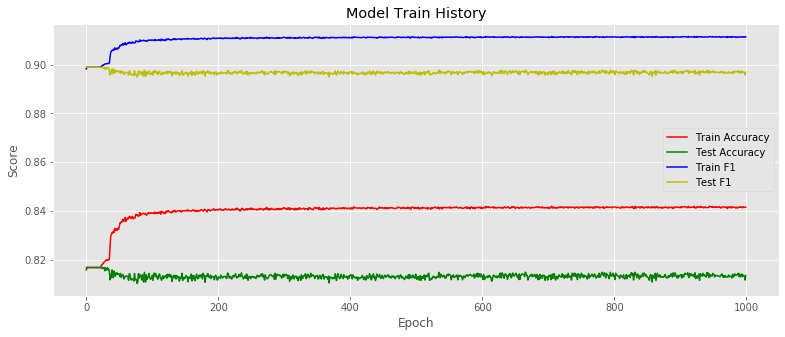

CLASSIFIER PERFORMANCE REFRIGERATOR MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,refrigerator,81.35,81.65,99.54,89.71,45.1,0.19,0.5,1970,8782



CONFUSION MATRIX (OFF/ON):

 - refrigerator:
[[   5 1965]
 [  40 8742]]


---> Splitting `{}` data (train/test)...
---> Training the `dishwasher` model...

Train on 32253 samples, validate on 10752 samples
Epoch 1/1000
32253/32253 - 29s - loss: 0.4302 - accuracy: 0.8720 - f1: 0.9299 - val_loss: 0.4372 - val_accuracy: 0.8762 - val_f1: 0.9339
Epoch 2/1000
32253/32253 - 21s - loss: 0.3793 - accuracy: 0.8762 - f1: 0.9339 - val_loss: 0.4208 - val_accuracy: 0.8762 - val_f1: 0.9339
Epoch 3/1000
32253/32253 - 22s - loss: 0.3787 - accuracy: 0.8762 - f1: 0.9339 - val_loss: 0.4215 - val_accuracy: 0.8762 - val_f1: 0.9339
Epoch 4/1000
32253/32253 - 22s - loss: 0.3790 - accuracy: 0.8762 - f1: 0.9339 - val_loss: 0.3982 - val_accuracy: 0.8762 - val_f1: 0.9339
Epoch 5/1000
32253/32253 - 21s - loss: 0.3782 - accuracy: 0.8762 - f1: 0.9339 - val_loss: 0.4072 - val_accuracy: 0.8762 - val_f1: 0.9339
Epoch 6/1000
32253/32253 - 21s - loss: 0.3791 - accuracy: 0.8762 - f1: 0.9339 - val_loss: 0.4051 - val_accur

Epoch 59/1000
32253/32253 - 20s - loss: 0.2564 - accuracy: 0.9174 - f1: 0.9546 - val_loss: 0.7692 - val_accuracy: 0.8710 - val_f1: 0.9307
Epoch 60/1000
32253/32253 - 20s - loss: 0.2552 - accuracy: 0.9170 - f1: 0.9544 - val_loss: 0.7307 - val_accuracy: 0.8677 - val_f1: 0.9287
Epoch 61/1000
32253/32253 - 20s - loss: 0.2558 - accuracy: 0.9169 - f1: 0.9544 - val_loss: 0.7486 - val_accuracy: 0.8683 - val_f1: 0.9291
Epoch 62/1000
32253/32253 - 20s - loss: 0.2571 - accuracy: 0.9169 - f1: 0.9544 - val_loss: 0.7439 - val_accuracy: 0.8674 - val_f1: 0.9285
Epoch 63/1000
32253/32253 - 20s - loss: 0.2549 - accuracy: 0.9177 - f1: 0.9549 - val_loss: 0.6929 - val_accuracy: 0.8663 - val_f1: 0.9278
Epoch 64/1000
32253/32253 - 20s - loss: 0.2561 - accuracy: 0.9175 - f1: 0.9547 - val_loss: 0.7394 - val_accuracy: 0.8686 - val_f1: 0.9292
Epoch 65/1000
32253/32253 - 20s - loss: 0.2542 - accuracy: 0.9179 - f1: 0.9549 - val_loss: 0.8008 - val_accuracy: 0.8715 - val_f1: 0.9310
Epoch 66/1000
32253/32253 - 20s - 

Epoch 119/1000
32253/32253 - 20s - loss: 0.2464 - accuracy: 0.9209 - f1: 0.9566 - val_loss: 0.8975 - val_accuracy: 0.8659 - val_f1: 0.9277
Epoch 120/1000
32253/32253 - 20s - loss: 0.2480 - accuracy: 0.9210 - f1: 0.9566 - val_loss: 0.9287 - val_accuracy: 0.8671 - val_f1: 0.9284
Epoch 121/1000
32253/32253 - 20s - loss: 0.2474 - accuracy: 0.9217 - f1: 0.9570 - val_loss: 0.9665 - val_accuracy: 0.8692 - val_f1: 0.9297
Epoch 122/1000
32253/32253 - 20s - loss: 0.2462 - accuracy: 0.9209 - f1: 0.9566 - val_loss: 0.9353 - val_accuracy: 0.8678 - val_f1: 0.9288
Epoch 123/1000
32253/32253 - 20s - loss: 0.2465 - accuracy: 0.9210 - f1: 0.9566 - val_loss: 0.9292 - val_accuracy: 0.8679 - val_f1: 0.9288
Epoch 124/1000
32253/32253 - 20s - loss: 0.2469 - accuracy: 0.9208 - f1: 0.9565 - val_loss: 0.9486 - val_accuracy: 0.8669 - val_f1: 0.9283
Epoch 125/1000
32253/32253 - 20s - loss: 0.2491 - accuracy: 0.9209 - f1: 0.9566 - val_loss: 0.9267 - val_accuracy: 0.8672 - val_f1: 0.9285
Epoch 126/1000
32253/32253 

Epoch 178/1000
32253/32253 - 20s - loss: 0.2443 - accuracy: 0.9222 - f1: 0.9573 - val_loss: 0.9598 - val_accuracy: 0.8667 - val_f1: 0.9281
Epoch 179/1000
32253/32253 - 20s - loss: 0.2430 - accuracy: 0.9223 - f1: 0.9573 - val_loss: 0.9433 - val_accuracy: 0.8657 - val_f1: 0.9275
Epoch 180/1000
32253/32253 - 20s - loss: 0.2436 - accuracy: 0.9219 - f1: 0.9571 - val_loss: 1.0463 - val_accuracy: 0.8672 - val_f1: 0.9285
Epoch 181/1000
32253/32253 - 20s - loss: 0.2439 - accuracy: 0.9225 - f1: 0.9575 - val_loss: 1.0553 - val_accuracy: 0.8694 - val_f1: 0.9298
Epoch 182/1000
32253/32253 - 20s - loss: 0.2431 - accuracy: 0.9225 - f1: 0.9574 - val_loss: 1.0177 - val_accuracy: 0.8682 - val_f1: 0.9290
Epoch 183/1000
32253/32253 - 20s - loss: 0.2440 - accuracy: 0.9222 - f1: 0.9573 - val_loss: 1.0141 - val_accuracy: 0.8685 - val_f1: 0.9292
Epoch 184/1000
32253/32253 - 20s - loss: 0.2440 - accuracy: 0.9221 - f1: 0.9572 - val_loss: 0.9847 - val_accuracy: 0.8677 - val_f1: 0.9287
Epoch 185/1000
32253/32253 

Epoch 237/1000
32253/32253 - 20s - loss: 0.2423 - accuracy: 0.9233 - f1: 0.9579 - val_loss: 0.9723 - val_accuracy: 0.8664 - val_f1: 0.9279
Epoch 238/1000
32253/32253 - 20s - loss: 0.2419 - accuracy: 0.9232 - f1: 0.9578 - val_loss: 1.0368 - val_accuracy: 0.8682 - val_f1: 0.9290
Epoch 239/1000
32253/32253 - 20s - loss: 0.2406 - accuracy: 0.9236 - f1: 0.9581 - val_loss: 1.0506 - val_accuracy: 0.8669 - val_f1: 0.9282
Epoch 240/1000
32253/32253 - 20s - loss: 0.2417 - accuracy: 0.9233 - f1: 0.9579 - val_loss: 1.0092 - val_accuracy: 0.8661 - val_f1: 0.9278
Epoch 241/1000
32253/32253 - 20s - loss: 0.2415 - accuracy: 0.9234 - f1: 0.9579 - val_loss: 1.0295 - val_accuracy: 0.8659 - val_f1: 0.9277
Epoch 242/1000
32253/32253 - 20s - loss: 0.2427 - accuracy: 0.9225 - f1: 0.9574 - val_loss: 1.0727 - val_accuracy: 0.8673 - val_f1: 0.9285
Epoch 243/1000
32253/32253 - 20s - loss: 0.2404 - accuracy: 0.9234 - f1: 0.9580 - val_loss: 1.0247 - val_accuracy: 0.8656 - val_f1: 0.9275
Epoch 244/1000
32253/32253 

Epoch 296/1000
32253/32253 - 20s - loss: 0.2405 - accuracy: 0.9239 - f1: 0.9582 - val_loss: 1.0994 - val_accuracy: 0.8673 - val_f1: 0.9285
Epoch 297/1000
32253/32253 - 20s - loss: 0.2417 - accuracy: 0.9234 - f1: 0.9579 - val_loss: 1.1766 - val_accuracy: 0.8687 - val_f1: 0.9293
Epoch 298/1000
32253/32253 - 20s - loss: 0.2408 - accuracy: 0.9241 - f1: 0.9583 - val_loss: 1.0841 - val_accuracy: 0.8680 - val_f1: 0.9289
Epoch 299/1000
32253/32253 - 20s - loss: 0.2415 - accuracy: 0.9234 - f1: 0.9580 - val_loss: 1.0465 - val_accuracy: 0.8665 - val_f1: 0.9281
Epoch 300/1000
32253/32253 - 20s - loss: 0.2416 - accuracy: 0.9233 - f1: 0.9579 - val_loss: 1.0557 - val_accuracy: 0.8673 - val_f1: 0.9285
Epoch 301/1000
32253/32253 - 20s - loss: 0.2400 - accuracy: 0.9236 - f1: 0.9580 - val_loss: 1.0802 - val_accuracy: 0.8677 - val_f1: 0.9287
Epoch 302/1000
32253/32253 - 20s - loss: 0.2419 - accuracy: 0.9236 - f1: 0.9581 - val_loss: 1.0344 - val_accuracy: 0.8683 - val_f1: 0.9291
Epoch 303/1000
32253/32253 

Epoch 355/1000
32253/32253 - 20s - loss: 0.2403 - accuracy: 0.9238 - f1: 0.9581 - val_loss: 1.0957 - val_accuracy: 0.8674 - val_f1: 0.9285
Epoch 356/1000
32253/32253 - 20s - loss: 0.2401 - accuracy: 0.9241 - f1: 0.9583 - val_loss: 1.0310 - val_accuracy: 0.8660 - val_f1: 0.9277
Epoch 357/1000
32253/32253 - 20s - loss: 0.2397 - accuracy: 0.9238 - f1: 0.9581 - val_loss: 1.1297 - val_accuracy: 0.8668 - val_f1: 0.9282
Epoch 358/1000
32253/32253 - 20s - loss: 0.2391 - accuracy: 0.9243 - f1: 0.9584 - val_loss: 1.0750 - val_accuracy: 0.8652 - val_f1: 0.9273
Epoch 359/1000
32253/32253 - 20s - loss: 0.2403 - accuracy: 0.9241 - f1: 0.9583 - val_loss: 1.1810 - val_accuracy: 0.8677 - val_f1: 0.9288
Epoch 360/1000
32253/32253 - 20s - loss: 0.2394 - accuracy: 0.9239 - f1: 0.9582 - val_loss: 1.0902 - val_accuracy: 0.8655 - val_f1: 0.9275
Epoch 361/1000
32253/32253 - 20s - loss: 0.2398 - accuracy: 0.9237 - f1: 0.9581 - val_loss: 1.1599 - val_accuracy: 0.8683 - val_f1: 0.9291
Epoch 362/1000
32253/32253 

Epoch 414/1000
32253/32253 - 20s - loss: 0.2409 - accuracy: 0.9246 - f1: 0.9586 - val_loss: 1.1562 - val_accuracy: 0.8687 - val_f1: 0.9293
Epoch 415/1000
32253/32253 - 20s - loss: 0.2387 - accuracy: 0.9243 - f1: 0.9584 - val_loss: 1.1769 - val_accuracy: 0.8672 - val_f1: 0.9284
Epoch 416/1000
32253/32253 - 20s - loss: 0.2387 - accuracy: 0.9239 - f1: 0.9582 - val_loss: 1.1319 - val_accuracy: 0.8676 - val_f1: 0.9287
Epoch 417/1000
32253/32253 - 20s - loss: 0.2396 - accuracy: 0.9241 - f1: 0.9583 - val_loss: 1.1027 - val_accuracy: 0.8677 - val_f1: 0.9287
Epoch 418/1000
32253/32253 - 20s - loss: 0.2398 - accuracy: 0.9240 - f1: 0.9583 - val_loss: 1.2401 - val_accuracy: 0.8690 - val_f1: 0.9296
Epoch 419/1000
32253/32253 - 20s - loss: 0.2419 - accuracy: 0.9237 - f1: 0.9581 - val_loss: 1.1791 - val_accuracy: 0.8679 - val_f1: 0.9290
Epoch 420/1000
32253/32253 - 20s - loss: 0.2379 - accuracy: 0.9245 - f1: 0.9586 - val_loss: 1.1370 - val_accuracy: 0.8677 - val_f1: 0.9287
Epoch 421/1000
32253/32253 

Epoch 473/1000
32253/32253 - 20s - loss: 0.2382 - accuracy: 0.9245 - f1: 0.9585 - val_loss: 1.2188 - val_accuracy: 0.8700 - val_f1: 0.9301
Epoch 474/1000
32253/32253 - 20s - loss: 0.2401 - accuracy: 0.9244 - f1: 0.9585 - val_loss: 1.2682 - val_accuracy: 0.8689 - val_f1: 0.9295
Epoch 475/1000
32253/32253 - 20s - loss: 0.2384 - accuracy: 0.9247 - f1: 0.9587 - val_loss: 1.2595 - val_accuracy: 0.8685 - val_f1: 0.9293
Epoch 476/1000
32253/32253 - 20s - loss: 0.2395 - accuracy: 0.9239 - f1: 0.9582 - val_loss: 1.1708 - val_accuracy: 0.8660 - val_f1: 0.9278
Epoch 477/1000
32253/32253 - 20s - loss: 0.2393 - accuracy: 0.9246 - f1: 0.9586 - val_loss: 1.2842 - val_accuracy: 0.8703 - val_f1: 0.9303
Epoch 478/1000
32253/32253 - 20s - loss: 0.2400 - accuracy: 0.9241 - f1: 0.9583 - val_loss: 1.1139 - val_accuracy: 0.8682 - val_f1: 0.9290
Epoch 479/1000
32253/32253 - 20s - loss: 0.2391 - accuracy: 0.9245 - f1: 0.9586 - val_loss: 1.1997 - val_accuracy: 0.8675 - val_f1: 0.9287
Epoch 480/1000
32253/32253 

Epoch 532/1000
32253/32253 - 20s - loss: 0.2374 - accuracy: 0.9246 - f1: 0.9586 - val_loss: 1.2372 - val_accuracy: 0.8681 - val_f1: 0.9289
Epoch 533/1000
32253/32253 - 20s - loss: 0.2390 - accuracy: 0.9247 - f1: 0.9587 - val_loss: 1.3563 - val_accuracy: 0.8699 - val_f1: 0.9301
Epoch 534/1000
32253/32253 - 20s - loss: 0.2387 - accuracy: 0.9246 - f1: 0.9586 - val_loss: 1.3004 - val_accuracy: 0.8691 - val_f1: 0.9297
Epoch 535/1000
32253/32253 - 20s - loss: 0.2396 - accuracy: 0.9241 - f1: 0.9583 - val_loss: 1.2242 - val_accuracy: 0.8677 - val_f1: 0.9288
Epoch 536/1000
32253/32253 - 20s - loss: 0.2375 - accuracy: 0.9249 - f1: 0.9588 - val_loss: 1.3632 - val_accuracy: 0.8699 - val_f1: 0.9301
Epoch 537/1000
32253/32253 - 20s - loss: 0.2381 - accuracy: 0.9249 - f1: 0.9588 - val_loss: 1.3187 - val_accuracy: 0.8692 - val_f1: 0.9297
Epoch 538/1000
32253/32253 - 20s - loss: 0.2392 - accuracy: 0.9243 - f1: 0.9585 - val_loss: 1.2588 - val_accuracy: 0.8677 - val_f1: 0.9288
Epoch 539/1000
32253/32253 

Epoch 591/1000
32253/32253 - 20s - loss: 0.2386 - accuracy: 0.9249 - f1: 0.9588 - val_loss: 1.2993 - val_accuracy: 0.8689 - val_f1: 0.9294
Epoch 592/1000
32253/32253 - 20s - loss: 0.2378 - accuracy: 0.9250 - f1: 0.9588 - val_loss: 1.2182 - val_accuracy: 0.8695 - val_f1: 0.9298
Epoch 593/1000
32253/32253 - 20s - loss: 0.2384 - accuracy: 0.9249 - f1: 0.9588 - val_loss: 1.2470 - val_accuracy: 0.8673 - val_f1: 0.9285
Epoch 594/1000
32253/32253 - 20s - loss: 0.2370 - accuracy: 0.9251 - f1: 0.9589 - val_loss: 1.3278 - val_accuracy: 0.8691 - val_f1: 0.9296
Epoch 595/1000
32253/32253 - 20s - loss: 0.2393 - accuracy: 0.9250 - f1: 0.9588 - val_loss: 1.1150 - val_accuracy: 0.8647 - val_f1: 0.9269
Epoch 596/1000
32253/32253 - 20s - loss: 0.2398 - accuracy: 0.9242 - f1: 0.9583 - val_loss: 1.1639 - val_accuracy: 0.8648 - val_f1: 0.9269
Epoch 597/1000
32253/32253 - 20s - loss: 0.2390 - accuracy: 0.9248 - f1: 0.9587 - val_loss: 1.2336 - val_accuracy: 0.8674 - val_f1: 0.9285
Epoch 598/1000
32253/32253 

Epoch 650/1000
32253/32253 - 20s - loss: 0.2378 - accuracy: 0.9250 - f1: 0.9588 - val_loss: 1.3241 - val_accuracy: 0.8698 - val_f1: 0.9299
Epoch 651/1000
32253/32253 - 20s - loss: 0.2385 - accuracy: 0.9247 - f1: 0.9587 - val_loss: 1.4643 - val_accuracy: 0.8709 - val_f1: 0.9307
Epoch 652/1000
32253/32253 - 20s - loss: 0.2377 - accuracy: 0.9248 - f1: 0.9587 - val_loss: 1.3040 - val_accuracy: 0.8682 - val_f1: 0.9290
Epoch 653/1000
32253/32253 - 20s - loss: 0.2390 - accuracy: 0.9248 - f1: 0.9587 - val_loss: 1.2966 - val_accuracy: 0.8688 - val_f1: 0.9294
Epoch 654/1000
32253/32253 - 20s - loss: 0.2380 - accuracy: 0.9247 - f1: 0.9587 - val_loss: 1.4949 - val_accuracy: 0.8708 - val_f1: 0.9306
Epoch 655/1000
32253/32253 - 20s - loss: 0.2382 - accuracy: 0.9249 - f1: 0.9588 - val_loss: 1.2926 - val_accuracy: 0.8682 - val_f1: 0.9291
Epoch 656/1000
32253/32253 - 20s - loss: 0.2379 - accuracy: 0.9251 - f1: 0.9589 - val_loss: 1.2888 - val_accuracy: 0.8691 - val_f1: 0.9295
Epoch 657/1000
32253/32253 

Epoch 709/1000
32253/32253 - 20s - loss: 0.2386 - accuracy: 0.9251 - f1: 0.9589 - val_loss: 1.2885 - val_accuracy: 0.8664 - val_f1: 0.9280
Epoch 710/1000
32253/32253 - 20s - loss: 0.2372 - accuracy: 0.9250 - f1: 0.9588 - val_loss: 1.3780 - val_accuracy: 0.8674 - val_f1: 0.9286
Epoch 711/1000
32253/32253 - 20s - loss: 0.2387 - accuracy: 0.9244 - f1: 0.9585 - val_loss: 1.3797 - val_accuracy: 0.8681 - val_f1: 0.9290
Epoch 712/1000
32253/32253 - 20s - loss: 0.2387 - accuracy: 0.9249 - f1: 0.9588 - val_loss: 1.3358 - val_accuracy: 0.8669 - val_f1: 0.9283
Epoch 713/1000
32253/32253 - 20s - loss: 0.2369 - accuracy: 0.9248 - f1: 0.9587 - val_loss: 1.3829 - val_accuracy: 0.8692 - val_f1: 0.9297
Epoch 714/1000
32253/32253 - 20s - loss: 0.2390 - accuracy: 0.9250 - f1: 0.9588 - val_loss: 1.2678 - val_accuracy: 0.8660 - val_f1: 0.9278
Epoch 715/1000
32253/32253 - 20s - loss: 0.2369 - accuracy: 0.9251 - f1: 0.9588 - val_loss: 1.3547 - val_accuracy: 0.8669 - val_f1: 0.9283
Epoch 716/1000
32253/32253 

Epoch 768/1000
32253/32253 - 20s - loss: 0.2372 - accuracy: 0.9255 - f1: 0.9590 - val_loss: 1.4585 - val_accuracy: 0.8688 - val_f1: 0.9295
Epoch 769/1000
32253/32253 - 20s - loss: 0.2376 - accuracy: 0.9248 - f1: 0.9587 - val_loss: 1.2795 - val_accuracy: 0.8651 - val_f1: 0.9273
Epoch 770/1000
32253/32253 - 20s - loss: 0.2374 - accuracy: 0.9248 - f1: 0.9587 - val_loss: 1.3491 - val_accuracy: 0.8676 - val_f1: 0.9287
Epoch 771/1000
32253/32253 - 20s - loss: 0.2378 - accuracy: 0.9248 - f1: 0.9587 - val_loss: 1.3612 - val_accuracy: 0.8680 - val_f1: 0.9290
Epoch 772/1000
32253/32253 - 20s - loss: 0.2364 - accuracy: 0.9253 - f1: 0.9590 - val_loss: 1.4846 - val_accuracy: 0.8690 - val_f1: 0.9296
Epoch 773/1000
32253/32253 - 20s - loss: 0.2394 - accuracy: 0.9249 - f1: 0.9588 - val_loss: 1.2966 - val_accuracy: 0.8659 - val_f1: 0.9277
Epoch 774/1000
32253/32253 - 20s - loss: 0.2368 - accuracy: 0.9254 - f1: 0.9591 - val_loss: 1.3355 - val_accuracy: 0.8677 - val_f1: 0.9287
Epoch 775/1000
32253/32253 

Epoch 827/1000
32253/32253 - 20s - loss: 0.2385 - accuracy: 0.9251 - f1: 0.9588 - val_loss: 1.3196 - val_accuracy: 0.8677 - val_f1: 0.9288
Epoch 828/1000
32253/32253 - 20s - loss: 0.2375 - accuracy: 0.9249 - f1: 0.9588 - val_loss: 1.4015 - val_accuracy: 0.8675 - val_f1: 0.9288
Epoch 829/1000
32253/32253 - 20s - loss: 0.2361 - accuracy: 0.9255 - f1: 0.9591 - val_loss: 1.4351 - val_accuracy: 0.8681 - val_f1: 0.9291
Epoch 830/1000
32253/32253 - 20s - loss: 0.2366 - accuracy: 0.9253 - f1: 0.9590 - val_loss: 1.4450 - val_accuracy: 0.8696 - val_f1: 0.9300
Epoch 831/1000
32253/32253 - 20s - loss: 0.2391 - accuracy: 0.9249 - f1: 0.9588 - val_loss: 1.3264 - val_accuracy: 0.8671 - val_f1: 0.9285
Epoch 832/1000
32253/32253 - 20s - loss: 0.2360 - accuracy: 0.9258 - f1: 0.9593 - val_loss: 1.5241 - val_accuracy: 0.8700 - val_f1: 0.9302
Epoch 833/1000
32253/32253 - 20s - loss: 0.2372 - accuracy: 0.9253 - f1: 0.9590 - val_loss: 1.2425 - val_accuracy: 0.8666 - val_f1: 0.9281
Epoch 834/1000
32253/32253 

Epoch 886/1000
32253/32253 - 20s - loss: 0.2375 - accuracy: 0.9254 - f1: 0.9590 - val_loss: 1.3892 - val_accuracy: 0.8690 - val_f1: 0.9296
Epoch 887/1000
32253/32253 - 20s - loss: 0.2380 - accuracy: 0.9250 - f1: 0.9589 - val_loss: 1.3919 - val_accuracy: 0.8686 - val_f1: 0.9293
Epoch 888/1000
32253/32253 - 20s - loss: 0.2371 - accuracy: 0.9252 - f1: 0.9589 - val_loss: 1.3900 - val_accuracy: 0.8687 - val_f1: 0.9293
Epoch 889/1000
32253/32253 - 20s - loss: 0.2375 - accuracy: 0.9252 - f1: 0.9589 - val_loss: 1.5017 - val_accuracy: 0.8690 - val_f1: 0.9296
Epoch 890/1000
32253/32253 - 20s - loss: 0.2369 - accuracy: 0.9254 - f1: 0.9590 - val_loss: 1.2496 - val_accuracy: 0.8646 - val_f1: 0.9269
Epoch 891/1000
32253/32253 - 20s - loss: 0.2383 - accuracy: 0.9248 - f1: 0.9587 - val_loss: 1.4098 - val_accuracy: 0.8706 - val_f1: 0.9305
Epoch 892/1000
32253/32253 - 20s - loss: 0.2369 - accuracy: 0.9251 - f1: 0.9589 - val_loss: 1.4210 - val_accuracy: 0.8696 - val_f1: 0.9299
Epoch 893/1000
32253/32253 

Epoch 945/1000
32253/32253 - 20s - loss: 0.2374 - accuracy: 0.9250 - f1: 0.9588 - val_loss: 1.3935 - val_accuracy: 0.8692 - val_f1: 0.9297
Epoch 946/1000
32253/32253 - 20s - loss: 0.2380 - accuracy: 0.9249 - f1: 0.9588 - val_loss: 1.4448 - val_accuracy: 0.8689 - val_f1: 0.9295
Epoch 947/1000
32253/32253 - 20s - loss: 0.2366 - accuracy: 0.9252 - f1: 0.9590 - val_loss: 1.3659 - val_accuracy: 0.8682 - val_f1: 0.9291
Epoch 948/1000
32253/32253 - 20s - loss: 0.2368 - accuracy: 0.9251 - f1: 0.9589 - val_loss: 1.4109 - val_accuracy: 0.8681 - val_f1: 0.9291
Epoch 949/1000
32253/32253 - 20s - loss: 0.2365 - accuracy: 0.9255 - f1: 0.9591 - val_loss: 1.3995 - val_accuracy: 0.8681 - val_f1: 0.9291
Epoch 950/1000
32253/32253 - 20s - loss: 0.2374 - accuracy: 0.9252 - f1: 0.9589 - val_loss: 1.4109 - val_accuracy: 0.8686 - val_f1: 0.9293
Epoch 951/1000
32253/32253 - 20s - loss: 0.2365 - accuracy: 0.9252 - f1: 0.9589 - val_loss: 1.4952 - val_accuracy: 0.8711 - val_f1: 0.9308
Epoch 952/1000
32253/32253 

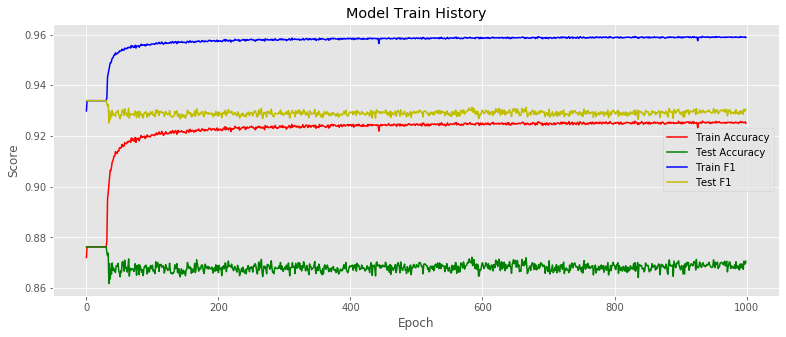

CLASSIFIER PERFORMANCE DISHWASHER MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,dishwasher,87.05,87.71,99.12,93.06,48.06,0.13,0.5,1331,9421



CONFUSION MATRIX (OFF/ON):

 - dishwasher:
[[  22 1309]
 [  83 9338]]


---> Splitting `{}` data (train/test)...
---> Training the `washer dryer 1` model...

Train on 32253 samples, validate on 10752 samples
Epoch 1/1000
32253/32253 - 24s - loss: 0.0984 - accuracy: 0.9795 - f1: 0.0043 - val_loss: 0.1145 - val_accuracy: 0.9808 - val_f1: 0.0000e+00
Epoch 2/1000
32253/32253 - 20s - loss: 0.0585 - accuracy: 0.9815 - f1: 0.1258 - val_loss: 0.0956 - val_accuracy: 0.9822 - val_f1: 0.1368
Epoch 3/1000
32253/32253 - 20s - loss: 0.0550 - accuracy: 0.9823 - f1: 0.2381 - val_loss: 0.0566 - val_accuracy: 0.9815 - val_f1: 0.0636
Epoch 4/1000
32253/32253 - 20s - loss: 0.0539 - accuracy: 0.9835 - f1: 0.3676 - val_loss: 0.0906 - val_accuracy: 0.9820 - val_f1: 0.4921
Epoch 5/1000
32253/32253 - 20s - loss: 0.0502 - accuracy: 0.9843 - f1: 0.3988 - val_loss: 0.0557 - val_accuracy: 0.9831 - val_f1: 0.4841
Epoch 6/1000
32253/32253 - 20s - loss: 0.0502 - accuracy: 0.9836 - f1: 0.3688 - val_loss: 0.0565 - val

Epoch 59/1000
32253/32253 - 20s - loss: 0.0085 - accuracy: 0.9973 - f1: 0.9091 - val_loss: 0.1431 - val_accuracy: 0.9829 - val_f1: 0.4529
Epoch 60/1000
32253/32253 - 20s - loss: 0.0094 - accuracy: 0.9968 - f1: 0.9049 - val_loss: 0.1513 - val_accuracy: 0.9843 - val_f1: 0.4588
Epoch 61/1000
32253/32253 - 20s - loss: 0.0107 - accuracy: 0.9962 - f1: 0.8821 - val_loss: 0.1280 - val_accuracy: 0.9831 - val_f1: 0.4439
Epoch 62/1000
32253/32253 - 20s - loss: 0.0092 - accuracy: 0.9968 - f1: 0.8994 - val_loss: 0.1484 - val_accuracy: 0.9836 - val_f1: 0.4233
Epoch 63/1000
32253/32253 - 20s - loss: 0.0089 - accuracy: 0.9971 - f1: 0.9166 - val_loss: 0.1627 - val_accuracy: 0.9835 - val_f1: 0.4397
Epoch 64/1000
32253/32253 - 20s - loss: 0.0081 - accuracy: 0.9971 - f1: 0.9186 - val_loss: 0.1625 - val_accuracy: 0.9837 - val_f1: 0.4569
Epoch 65/1000
32253/32253 - 20s - loss: 0.0101 - accuracy: 0.9962 - f1: 0.8880 - val_loss: 0.1551 - val_accuracy: 0.9847 - val_f1: 0.4712
Epoch 66/1000
32253/32253 - 20s - 

Epoch 119/1000
32253/32253 - 20s - loss: 0.0063 - accuracy: 0.9981 - f1: 0.9511 - val_loss: 0.2252 - val_accuracy: 0.9841 - val_f1: 0.4503
Epoch 120/1000
32253/32253 - 20s - loss: 0.0056 - accuracy: 0.9983 - f1: 0.9430 - val_loss: 0.2287 - val_accuracy: 0.9847 - val_f1: 0.4671
Epoch 121/1000
32253/32253 - 20s - loss: 0.0055 - accuracy: 0.9984 - f1: 0.9398 - val_loss: 0.2372 - val_accuracy: 0.9835 - val_f1: 0.4258
Epoch 122/1000
32253/32253 - 20s - loss: 0.0152 - accuracy: 0.9958 - f1: 0.8595 - val_loss: 0.1648 - val_accuracy: 0.9832 - val_f1: 0.4570
Epoch 123/1000
32253/32253 - 20s - loss: 0.0055 - accuracy: 0.9985 - f1: 0.9505 - val_loss: 0.2081 - val_accuracy: 0.9846 - val_f1: 0.4741
Epoch 124/1000
32253/32253 - 20s - loss: 0.0054 - accuracy: 0.9982 - f1: 0.9463 - val_loss: 0.1857 - val_accuracy: 0.9838 - val_f1: 0.4562
Epoch 125/1000
32253/32253 - 20s - loss: 0.0047 - accuracy: 0.9988 - f1: 0.9580 - val_loss: 0.2256 - val_accuracy: 0.9843 - val_f1: 0.4413
Epoch 126/1000
32253/32253 

Epoch 178/1000
32253/32253 - 20s - loss: 0.0042 - accuracy: 0.9989 - f1: 0.9677 - val_loss: 0.2259 - val_accuracy: 0.9836 - val_f1: 0.4443
Epoch 179/1000
32253/32253 - 20s - loss: 0.0045 - accuracy: 0.9990 - f1: 0.9665 - val_loss: 0.2640 - val_accuracy: 0.9843 - val_f1: 0.4771
Epoch 180/1000
32253/32253 - 20s - loss: 0.0042 - accuracy: 0.9989 - f1: 0.9669 - val_loss: 0.2553 - val_accuracy: 0.9845 - val_f1: 0.4642
Epoch 181/1000
32253/32253 - 20s - loss: 0.0039 - accuracy: 0.9990 - f1: 0.9475 - val_loss: 0.2629 - val_accuracy: 0.9850 - val_f1: 0.4498
Epoch 182/1000
32253/32253 - 20s - loss: 0.0045 - accuracy: 0.9988 - f1: 0.9502 - val_loss: 0.2516 - val_accuracy: 0.9847 - val_f1: 0.4635
Epoch 183/1000
32253/32253 - 21s - loss: 0.0043 - accuracy: 0.9989 - f1: 0.9579 - val_loss: 0.2431 - val_accuracy: 0.9839 - val_f1: 0.4604
Epoch 184/1000
32253/32253 - 20s - loss: 0.0044 - accuracy: 0.9988 - f1: 0.9591 - val_loss: 0.2832 - val_accuracy: 0.9843 - val_f1: 0.4489
Epoch 185/1000
32253/32253 

Epoch 237/1000
32253/32253 - 20s - loss: 0.0035 - accuracy: 0.9991 - f1: 0.9705 - val_loss: 0.2431 - val_accuracy: 0.9834 - val_f1: 0.4470
Epoch 238/1000
32253/32253 - 20s - loss: 0.0045 - accuracy: 0.9989 - f1: 0.9627 - val_loss: 0.2926 - val_accuracy: 0.9844 - val_f1: 0.4497
Epoch 239/1000
32253/32253 - 20s - loss: 0.0036 - accuracy: 0.9992 - f1: 0.9709 - val_loss: 0.3039 - val_accuracy: 0.9840 - val_f1: 0.4475
Epoch 240/1000
32253/32253 - 20s - loss: 0.0033 - accuracy: 0.9992 - f1: 0.9754 - val_loss: 0.3366 - val_accuracy: 0.9844 - val_f1: 0.4401
Epoch 241/1000
32253/32253 - 20s - loss: 0.0040 - accuracy: 0.9991 - f1: 0.9622 - val_loss: 0.2895 - val_accuracy: 0.9841 - val_f1: 0.4361
Epoch 242/1000
32253/32253 - 20s - loss: 0.0041 - accuracy: 0.9990 - f1: 0.9758 - val_loss: 0.2678 - val_accuracy: 0.9842 - val_f1: 0.4358
Epoch 243/1000
32253/32253 - 20s - loss: 0.0043 - accuracy: 0.9988 - f1: 0.9610 - val_loss: 0.2500 - val_accuracy: 0.9841 - val_f1: 0.4491
Epoch 244/1000
32253/32253 

Epoch 296/1000
32253/32253 - 20s - loss: 0.0040 - accuracy: 0.9992 - f1: 0.9762 - val_loss: 0.3561 - val_accuracy: 0.9853 - val_f1: 0.4332
Epoch 297/1000
32253/32253 - 20s - loss: 0.0030 - accuracy: 0.9993 - f1: 0.9795 - val_loss: 0.3142 - val_accuracy: 0.9843 - val_f1: 0.4565
Epoch 298/1000
32253/32253 - 20s - loss: 0.0035 - accuracy: 0.9991 - f1: 0.9645 - val_loss: 0.3506 - val_accuracy: 0.9846 - val_f1: 0.4358
Epoch 299/1000
32253/32253 - 20s - loss: 0.0041 - accuracy: 0.9991 - f1: 0.9739 - val_loss: 0.3006 - val_accuracy: 0.9851 - val_f1: 0.4601
Epoch 300/1000
32253/32253 - 20s - loss: 0.0033 - accuracy: 0.9993 - f1: 0.9757 - val_loss: 0.3158 - val_accuracy: 0.9844 - val_f1: 0.4485
Epoch 301/1000
32253/32253 - 20s - loss: 0.0033 - accuracy: 0.9994 - f1: 0.9724 - val_loss: 0.3176 - val_accuracy: 0.9848 - val_f1: 0.4479
Epoch 302/1000
32253/32253 - 20s - loss: 0.0036 - accuracy: 0.9991 - f1: 0.9725 - val_loss: 0.3024 - val_accuracy: 0.9846 - val_f1: 0.4548
Epoch 303/1000
32253/32253 

Epoch 355/1000
32253/32253 - 20s - loss: 0.0026 - accuracy: 0.9995 - f1: 0.9855 - val_loss: 0.3736 - val_accuracy: 0.9847 - val_f1: 0.4487
Epoch 356/1000
32253/32253 - 20s - loss: 0.0034 - accuracy: 0.9992 - f1: 0.9798 - val_loss: 0.3024 - val_accuracy: 0.9841 - val_f1: 0.4472
Epoch 357/1000
32253/32253 - 20s - loss: 0.0041 - accuracy: 0.9990 - f1: 0.9663 - val_loss: 0.3533 - val_accuracy: 0.9848 - val_f1: 0.4467
Epoch 358/1000
32253/32253 - 20s - loss: 0.0032 - accuracy: 0.9993 - f1: 0.9818 - val_loss: 0.3458 - val_accuracy: 0.9850 - val_f1: 0.4358
Epoch 359/1000
32253/32253 - 20s - loss: 0.0028 - accuracy: 0.9994 - f1: 0.9878 - val_loss: 0.3591 - val_accuracy: 0.9843 - val_f1: 0.4397
Epoch 360/1000
32253/32253 - 20s - loss: 0.0030 - accuracy: 0.9993 - f1: 0.9778 - val_loss: 0.2933 - val_accuracy: 0.9840 - val_f1: 0.4313
Epoch 361/1000
32253/32253 - 20s - loss: 0.0037 - accuracy: 0.9992 - f1: 0.9674 - val_loss: 0.3070 - val_accuracy: 0.9838 - val_f1: 0.4235
Epoch 362/1000
32253/32253 

Epoch 414/1000
32253/32253 - 20s - loss: 0.0029 - accuracy: 0.9993 - f1: 0.9811 - val_loss: 0.3510 - val_accuracy: 0.9837 - val_f1: 0.4310
Epoch 415/1000
32253/32253 - 20s - loss: 0.0032 - accuracy: 0.9993 - f1: 0.9816 - val_loss: 0.3287 - val_accuracy: 0.9843 - val_f1: 0.4217
Epoch 416/1000
32253/32253 - 20s - loss: 0.0033 - accuracy: 0.9992 - f1: 0.9616 - val_loss: 0.3092 - val_accuracy: 0.9843 - val_f1: 0.4415
Epoch 417/1000
32253/32253 - 20s - loss: 0.0029 - accuracy: 0.9994 - f1: 0.9605 - val_loss: 0.3428 - val_accuracy: 0.9847 - val_f1: 0.4424
Epoch 418/1000
32253/32253 - 20s - loss: 0.0031 - accuracy: 0.9991 - f1: 0.9659 - val_loss: 0.3538 - val_accuracy: 0.9845 - val_f1: 0.4269
Epoch 419/1000
32253/32253 - 20s - loss: 0.0031 - accuracy: 0.9993 - f1: 0.9726 - val_loss: 0.3595 - val_accuracy: 0.9847 - val_f1: 0.4289
Epoch 420/1000
32253/32253 - 20s - loss: 0.0024 - accuracy: 0.9994 - f1: 0.9776 - val_loss: 0.3652 - val_accuracy: 0.9846 - val_f1: 0.4142
Epoch 421/1000
32253/32253 

Epoch 473/1000
32253/32253 - 20s - loss: 0.0026 - accuracy: 0.9995 - f1: 0.9668 - val_loss: 0.3611 - val_accuracy: 0.9851 - val_f1: 0.4594
Epoch 474/1000
32253/32253 - 20s - loss: 0.0026 - accuracy: 0.9996 - f1: 0.9796 - val_loss: 0.3314 - val_accuracy: 0.9849 - val_f1: 0.4468
Epoch 475/1000
32253/32253 - 20s - loss: 0.0025 - accuracy: 0.9994 - f1: 0.9814 - val_loss: 0.3968 - val_accuracy: 0.9850 - val_f1: 0.4427
Epoch 476/1000
32253/32253 - 20s - loss: 0.0028 - accuracy: 0.9994 - f1: 0.9714 - val_loss: 0.4165 - val_accuracy: 0.9847 - val_f1: 0.4490
Epoch 477/1000
32253/32253 - 20s - loss: 0.0024 - accuracy: 0.9995 - f1: 0.9774 - val_loss: 0.4120 - val_accuracy: 0.9848 - val_f1: 0.4450
Epoch 478/1000
32253/32253 - 20s - loss: 0.0026 - accuracy: 0.9996 - f1: 0.9889 - val_loss: 0.4045 - val_accuracy: 0.9847 - val_f1: 0.4144
Epoch 479/1000
32253/32253 - 20s - loss: 0.0030 - accuracy: 0.9992 - f1: 0.9606 - val_loss: 0.3676 - val_accuracy: 0.9846 - val_f1: 0.4364
Epoch 480/1000
32253/32253 

Epoch 532/1000
32253/32253 - 20s - loss: 0.0025 - accuracy: 0.9996 - f1: 0.9857 - val_loss: 0.3514 - val_accuracy: 0.9827 - val_f1: 0.4121
Epoch 533/1000
32253/32253 - 20s - loss: 0.0036 - accuracy: 0.9992 - f1: 0.9573 - val_loss: 0.3736 - val_accuracy: 0.9850 - val_f1: 0.4458
Epoch 534/1000
32253/32253 - 20s - loss: 0.0027 - accuracy: 0.9995 - f1: 0.9684 - val_loss: 0.3538 - val_accuracy: 0.9843 - val_f1: 0.4489
Epoch 535/1000
32253/32253 - 20s - loss: 0.0027 - accuracy: 0.9995 - f1: 0.9731 - val_loss: 0.4004 - val_accuracy: 0.9850 - val_f1: 0.4251
Epoch 536/1000
32253/32253 - 20s - loss: 0.0024 - accuracy: 0.9997 - f1: 0.9753 - val_loss: 0.3529 - val_accuracy: 0.9842 - val_f1: 0.4464
Epoch 537/1000
32253/32253 - 20s - loss: 0.0023 - accuracy: 0.9996 - f1: 0.9885 - val_loss: 0.3854 - val_accuracy: 0.9847 - val_f1: 0.4273
Epoch 538/1000
32253/32253 - 20s - loss: 0.0027 - accuracy: 0.9995 - f1: 0.9768 - val_loss: 0.4217 - val_accuracy: 0.9852 - val_f1: 0.4324
Epoch 539/1000
32253/32253 

Epoch 591/1000
32253/32253 - 20s - loss: 0.0024 - accuracy: 0.9996 - f1: 0.9884 - val_loss: 0.4202 - val_accuracy: 0.9837 - val_f1: 0.4445
Epoch 592/1000
32253/32253 - 20s - loss: 0.0026 - accuracy: 0.9995 - f1: 0.9853 - val_loss: 0.5209 - val_accuracy: 0.9850 - val_f1: 0.4429
Epoch 593/1000
32253/32253 - 20s - loss: 0.0032 - accuracy: 0.9993 - f1: 0.9616 - val_loss: 0.5168 - val_accuracy: 0.9846 - val_f1: 0.4185
Epoch 594/1000
32253/32253 - 20s - loss: 0.0026 - accuracy: 0.9995 - f1: 0.9854 - val_loss: 0.4889 - val_accuracy: 0.9842 - val_f1: 0.4014
Epoch 595/1000
32253/32253 - 20s - loss: 0.0028 - accuracy: 0.9995 - f1: 0.9635 - val_loss: 0.4536 - val_accuracy: 0.9845 - val_f1: 0.4336
Epoch 596/1000
32253/32253 - 20s - loss: 0.0029 - accuracy: 0.9995 - f1: 0.9713 - val_loss: 0.4533 - val_accuracy: 0.9850 - val_f1: 0.4484
Epoch 597/1000
32253/32253 - 20s - loss: 0.0023 - accuracy: 0.9997 - f1: 0.9694 - val_loss: 0.4566 - val_accuracy: 0.9848 - val_f1: 0.4422
Epoch 598/1000
32253/32253 

Epoch 650/1000
32253/32253 - 20s - loss: 0.0034 - accuracy: 0.9992 - f1: 0.9612 - val_loss: 0.5242 - val_accuracy: 0.9843 - val_f1: 0.4227
Epoch 651/1000
32253/32253 - 20s - loss: 0.0025 - accuracy: 0.9995 - f1: 0.9865 - val_loss: 0.5612 - val_accuracy: 0.9845 - val_f1: 0.4508
Epoch 652/1000
32253/32253 - 20s - loss: 0.0027 - accuracy: 0.9994 - f1: 0.9681 - val_loss: 0.4792 - val_accuracy: 0.9849 - val_f1: 0.4384
Epoch 653/1000
32253/32253 - 20s - loss: 0.0026 - accuracy: 0.9995 - f1: 0.9876 - val_loss: 0.4342 - val_accuracy: 0.9840 - val_f1: 0.4434
Epoch 654/1000
32253/32253 - 20s - loss: 0.0026 - accuracy: 0.9996 - f1: 0.9848 - val_loss: 0.4323 - val_accuracy: 0.9850 - val_f1: 0.4350
Epoch 655/1000
32253/32253 - 20s - loss: 0.0026 - accuracy: 0.9996 - f1: 0.9510 - val_loss: 0.4472 - val_accuracy: 0.9850 - val_f1: 0.4385
Epoch 656/1000
32253/32253 - 20s - loss: 0.0027 - accuracy: 0.9994 - f1: 0.9759 - val_loss: 0.3767 - val_accuracy: 0.9850 - val_f1: 0.4442
Epoch 657/1000
32253/32253 

Epoch 709/1000
32253/32253 - 20s - loss: 0.0026 - accuracy: 0.9995 - f1: 0.9871 - val_loss: 0.4512 - val_accuracy: 0.9841 - val_f1: 0.4390
Epoch 710/1000
32253/32253 - 20s - loss: 0.0021 - accuracy: 0.9997 - f1: 0.9889 - val_loss: 0.4730 - val_accuracy: 0.9847 - val_f1: 0.4378
Epoch 711/1000
32253/32253 - 20s - loss: 0.0023 - accuracy: 0.9997 - f1: 0.9854 - val_loss: 0.4698 - val_accuracy: 0.9852 - val_f1: 0.4444
Epoch 712/1000
32253/32253 - 20s - loss: 0.0022 - accuracy: 0.9997 - f1: 0.9760 - val_loss: 0.4553 - val_accuracy: 0.9844 - val_f1: 0.4490
Epoch 713/1000
32253/32253 - 20s - loss: 0.0027 - accuracy: 0.9994 - f1: 0.9499 - val_loss: 0.4577 - val_accuracy: 0.9847 - val_f1: 0.4474
Epoch 714/1000
32253/32253 - 20s - loss: 0.0021 - accuracy: 0.9996 - f1: 0.9804 - val_loss: 0.4888 - val_accuracy: 0.9842 - val_f1: 0.4194
Epoch 715/1000
32253/32253 - 20s - loss: 0.0023 - accuracy: 0.9995 - f1: 0.9853 - val_loss: 0.4873 - val_accuracy: 0.9842 - val_f1: 0.4363
Epoch 716/1000
32253/32253 

Epoch 768/1000
32253/32253 - 20s - loss: 0.0025 - accuracy: 0.9994 - f1: 0.9791 - val_loss: 0.5709 - val_accuracy: 0.9846 - val_f1: 0.4201
Epoch 769/1000
32253/32253 - 20s - loss: 0.0029 - accuracy: 0.9994 - f1: 0.9784 - val_loss: 0.4438 - val_accuracy: 0.9845 - val_f1: 0.4205
Epoch 770/1000
32253/32253 - 20s - loss: 0.0020 - accuracy: 0.9998 - f1: 0.9692 - val_loss: 0.5018 - val_accuracy: 0.9842 - val_f1: 0.4487
Epoch 771/1000
32253/32253 - 20s - loss: 0.0032 - accuracy: 0.9994 - f1: 0.9826 - val_loss: 0.5040 - val_accuracy: 0.9844 - val_f1: 0.4470
Epoch 772/1000
32253/32253 - 20s - loss: 0.0024 - accuracy: 0.9996 - f1: 0.9739 - val_loss: 0.5431 - val_accuracy: 0.9844 - val_f1: 0.4358
Epoch 773/1000
32253/32253 - 20s - loss: 0.0024 - accuracy: 0.9997 - f1: 0.9804 - val_loss: 0.5058 - val_accuracy: 0.9845 - val_f1: 0.4239
Epoch 774/1000
32253/32253 - 20s - loss: 0.0028 - accuracy: 0.9995 - f1: 0.9838 - val_loss: 0.4679 - val_accuracy: 0.9840 - val_f1: 0.4320
Epoch 775/1000
32253/32253 

Epoch 827/1000
32253/32253 - 20s - loss: 0.0024 - accuracy: 0.9996 - f1: 0.9747 - val_loss: 0.5145 - val_accuracy: 0.9838 - val_f1: 0.4132
Epoch 828/1000
32253/32253 - 20s - loss: 0.0026 - accuracy: 0.9995 - f1: 0.9787 - val_loss: 0.5006 - val_accuracy: 0.9844 - val_f1: 0.4364
Epoch 829/1000
32253/32253 - 20s - loss: 0.0023 - accuracy: 0.9996 - f1: 0.9903 - val_loss: 0.4935 - val_accuracy: 0.9847 - val_f1: 0.4543
Epoch 830/1000
32253/32253 - 20s - loss: 0.0026 - accuracy: 0.9996 - f1: 0.9785 - val_loss: 0.4990 - val_accuracy: 0.9843 - val_f1: 0.4421
Epoch 831/1000
32253/32253 - 20s - loss: 0.0030 - accuracy: 0.9993 - f1: 0.9773 - val_loss: 0.5291 - val_accuracy: 0.9846 - val_f1: 0.4559
Epoch 832/1000
32253/32253 - 20s - loss: 0.0027 - accuracy: 0.9996 - f1: 0.9879 - val_loss: 0.5092 - val_accuracy: 0.9846 - val_f1: 0.4440
Epoch 833/1000
32253/32253 - 20s - loss: 0.0021 - accuracy: 0.9997 - f1: 0.9866 - val_loss: 0.5268 - val_accuracy: 0.9846 - val_f1: 0.4332
Epoch 834/1000
32253/32253 

Epoch 886/1000
32253/32253 - 20s - loss: 0.0039 - accuracy: 0.9995 - f1: 0.9707 - val_loss: 0.5277 - val_accuracy: 0.9843 - val_f1: 0.4164
Epoch 887/1000
32253/32253 - 20s - loss: 0.0021 - accuracy: 0.9997 - f1: 0.9838 - val_loss: 0.5943 - val_accuracy: 0.9847 - val_f1: 0.4091
Epoch 888/1000
32253/32253 - 20s - loss: 0.0024 - accuracy: 0.9995 - f1: 0.9698 - val_loss: 0.5832 - val_accuracy: 0.9848 - val_f1: 0.4185
Epoch 889/1000
32253/32253 - 20s - loss: 0.0022 - accuracy: 0.9997 - f1: 0.9880 - val_loss: 0.5818 - val_accuracy: 0.9847 - val_f1: 0.4325
Epoch 890/1000
32253/32253 - 20s - loss: 0.0021 - accuracy: 0.9996 - f1: 0.9830 - val_loss: 0.5715 - val_accuracy: 0.9845 - val_f1: 0.4205
Epoch 891/1000
32253/32253 - 20s - loss: 0.0021 - accuracy: 0.9996 - f1: 0.9799 - val_loss: 0.5948 - val_accuracy: 0.9846 - val_f1: 0.4162
Epoch 892/1000
32253/32253 - 20s - loss: 0.0020 - accuracy: 0.9997 - f1: 0.9914 - val_loss: 0.5435 - val_accuracy: 0.9846 - val_f1: 0.4388
Epoch 893/1000
32253/32253 

Epoch 945/1000
32253/32253 - 20s - loss: 0.0024 - accuracy: 0.9996 - f1: 0.9729 - val_loss: 0.6315 - val_accuracy: 0.9847 - val_f1: 0.4350
Epoch 946/1000
32253/32253 - 20s - loss: 0.0022 - accuracy: 0.9996 - f1: 0.9735 - val_loss: 0.5777 - val_accuracy: 0.9846 - val_f1: 0.4543
Epoch 947/1000
32253/32253 - 20s - loss: 0.0021 - accuracy: 0.9997 - f1: 0.9811 - val_loss: 0.6004 - val_accuracy: 0.9846 - val_f1: 0.4238
Epoch 948/1000
32253/32253 - 20s - loss: 0.0018 - accuracy: 0.9998 - f1: 0.9931 - val_loss: 0.5518 - val_accuracy: 0.9841 - val_f1: 0.4322
Epoch 949/1000
32253/32253 - 20s - loss: 0.0018 - accuracy: 0.9998 - f1: 0.9926 - val_loss: 0.6072 - val_accuracy: 0.9845 - val_f1: 0.4327
Epoch 950/1000
32253/32253 - 20s - loss: 0.0024 - accuracy: 0.9996 - f1: 0.9687 - val_loss: 0.5716 - val_accuracy: 0.9840 - val_f1: 0.4193
Epoch 951/1000
32253/32253 - 20s - loss: 0.0024 - accuracy: 0.9996 - f1: 0.9884 - val_loss: 0.5857 - val_accuracy: 0.9836 - val_f1: 0.4009
Epoch 952/1000
32253/32253 

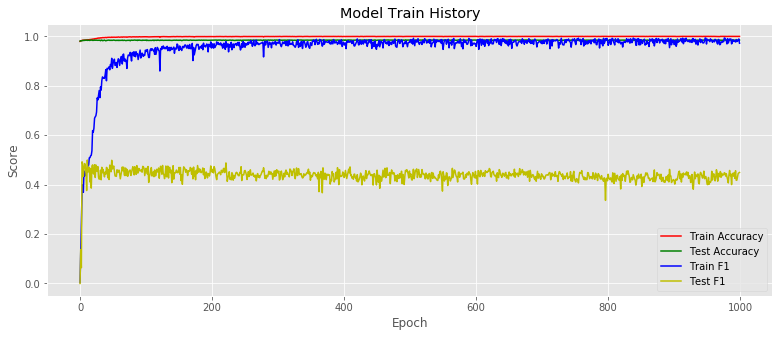

CLASSIFIER PERFORMANCE WASHER DRYER 1 MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,washer dryer 1,98.48,66.93,41.26,51.05,75.14,0.02,0.7,10546,206



CONFUSION MATRIX (OFF/ON):

 - washer dryer 1:
[[10504    42]
 [  121    85]]


---> Splitting `{}` data (train/test)...
---> Training the `washer dryer 2` model...

Train on 32253 samples, validate on 10752 samples
Epoch 1/1000
32253/32253 - 24s - loss: 0.3222 - accuracy: 0.9137 - f1: 9.5877e-04 - val_loss: 0.3242 - val_accuracy: 0.9173 - val_f1: 0.0000e+00
Epoch 2/1000
32253/32253 - 21s - loss: 0.2716 - accuracy: 0.9173 - f1: 0.0000e+00 - val_loss: 0.3113 - val_accuracy: 0.9173 - val_f1: 0.0000e+00
Epoch 3/1000
32253/32253 - 21s - loss: 0.2698 - accuracy: 0.9173 - f1: 0.0000e+00 - val_loss: 0.2884 - val_accuracy: 0.9173 - val_f1: 0.0000e+00
Epoch 4/1000
32253/32253 - 21s - loss: 0.2677 - accuracy: 0.9173 - f1: 0.0000e+00 - val_loss: 0.3170 - val_accuracy: 0.9173 - val_f1: 0.0000e+00
Epoch 5/1000
32253/32253 - 21s - loss: 0.2671 - accuracy: 0.9173 - f1: 0.0000e+00 - val_loss: 0.2744 - val_accuracy: 0.9173 - val_f1: 0.0000e+00
Epoch 6/1000
32253/32253 - 21s - loss: 0.2655 - accuracy: 

Epoch 58/1000
32253/32253 - 20s - loss: 0.2117 - accuracy: 0.9372 - f1: 0.4214 - val_loss: 0.3445 - val_accuracy: 0.9212 - val_f1: 0.1668
Epoch 59/1000
32253/32253 - 20s - loss: 0.2104 - accuracy: 0.9379 - f1: 0.4261 - val_loss: 0.3417 - val_accuracy: 0.9216 - val_f1: 0.1766
Epoch 60/1000
32253/32253 - 21s - loss: 0.2109 - accuracy: 0.9376 - f1: 0.4269 - val_loss: 0.3500 - val_accuracy: 0.9210 - val_f1: 0.1782
Epoch 61/1000
32253/32253 - 20s - loss: 0.2114 - accuracy: 0.9384 - f1: 0.4305 - val_loss: 0.3492 - val_accuracy: 0.9209 - val_f1: 0.1806
Epoch 62/1000
32253/32253 - 20s - loss: 0.2100 - accuracy: 0.9379 - f1: 0.4247 - val_loss: 0.3498 - val_accuracy: 0.9209 - val_f1: 0.1704
Epoch 63/1000
32253/32253 - 20s - loss: 0.2095 - accuracy: 0.9380 - f1: 0.4236 - val_loss: 0.3699 - val_accuracy: 0.9210 - val_f1: 0.1699
Epoch 64/1000
32253/32253 - 20s - loss: 0.2101 - accuracy: 0.9380 - f1: 0.4197 - val_loss: 0.3401 - val_accuracy: 0.9205 - val_f1: 0.1868
Epoch 65/1000
32253/32253 - 20s - 

Epoch 118/1000
32253/32253 - 20s - loss: 0.2061 - accuracy: 0.9400 - f1: 0.4479 - val_loss: 0.4321 - val_accuracy: 0.9200 - val_f1: 0.1497
Epoch 119/1000
32253/32253 - 20s - loss: 0.2073 - accuracy: 0.9395 - f1: 0.4425 - val_loss: 0.4083 - val_accuracy: 0.9200 - val_f1: 0.2001
Epoch 120/1000
32253/32253 - 20s - loss: 0.2073 - accuracy: 0.9390 - f1: 0.4321 - val_loss: 0.4142 - val_accuracy: 0.9220 - val_f1: 0.1908
Epoch 121/1000
32253/32253 - 20s - loss: 0.2056 - accuracy: 0.9399 - f1: 0.4412 - val_loss: 0.4183 - val_accuracy: 0.9212 - val_f1: 0.1717
Epoch 122/1000
32253/32253 - 20s - loss: 0.2061 - accuracy: 0.9398 - f1: 0.4413 - val_loss: 0.4211 - val_accuracy: 0.9215 - val_f1: 0.1955
Epoch 123/1000
32253/32253 - 20s - loss: 0.2054 - accuracy: 0.9400 - f1: 0.4454 - val_loss: 0.4146 - val_accuracy: 0.9209 - val_f1: 0.1843
Epoch 124/1000
32253/32253 - 20s - loss: 0.2056 - accuracy: 0.9399 - f1: 0.4450 - val_loss: 0.4286 - val_accuracy: 0.9221 - val_f1: 0.1883
Epoch 125/1000
32253/32253 

Epoch 177/1000
32253/32253 - 20s - loss: 0.2070 - accuracy: 0.9399 - f1: 0.4457 - val_loss: 0.4582 - val_accuracy: 0.9209 - val_f1: 0.1744
Epoch 178/1000
32253/32253 - 20s - loss: 0.2044 - accuracy: 0.9407 - f1: 0.4493 - val_loss: 0.4760 - val_accuracy: 0.9220 - val_f1: 0.1787
Epoch 179/1000
32253/32253 - 20s - loss: 0.2043 - accuracy: 0.9407 - f1: 0.4472 - val_loss: 0.4428 - val_accuracy: 0.9209 - val_f1: 0.1919
Epoch 180/1000
32253/32253 - 20s - loss: 0.2032 - accuracy: 0.9405 - f1: 0.4433 - val_loss: 0.4691 - val_accuracy: 0.9212 - val_f1: 0.1722
Epoch 181/1000
32253/32253 - 20s - loss: 0.2051 - accuracy: 0.9408 - f1: 0.4446 - val_loss: 0.4945 - val_accuracy: 0.9214 - val_f1: 0.1590
Epoch 182/1000
32253/32253 - 20s - loss: 0.2053 - accuracy: 0.9406 - f1: 0.4458 - val_loss: 0.5014 - val_accuracy: 0.9217 - val_f1: 0.1623
Epoch 183/1000
32253/32253 - 20s - loss: 0.2043 - accuracy: 0.9407 - f1: 0.4470 - val_loss: 0.4359 - val_accuracy: 0.9216 - val_f1: 0.1809
Epoch 184/1000
32253/32253 

Epoch 236/1000
32253/32253 - 20s - loss: 0.2036 - accuracy: 0.9412 - f1: 0.4556 - val_loss: 0.4916 - val_accuracy: 0.9210 - val_f1: 0.1649
Epoch 237/1000
32253/32253 - 20s - loss: 0.2031 - accuracy: 0.9410 - f1: 0.4413 - val_loss: 0.4521 - val_accuracy: 0.9200 - val_f1: 0.1693
Epoch 238/1000
32253/32253 - 20s - loss: 0.2036 - accuracy: 0.9410 - f1: 0.4496 - val_loss: 0.4698 - val_accuracy: 0.9203 - val_f1: 0.1628
Epoch 239/1000
32253/32253 - 20s - loss: 0.2033 - accuracy: 0.9410 - f1: 0.4516 - val_loss: 0.5461 - val_accuracy: 0.9214 - val_f1: 0.1630
Epoch 240/1000
32253/32253 - 20s - loss: 0.2065 - accuracy: 0.9400 - f1: 0.4418 - val_loss: 0.4822 - val_accuracy: 0.9217 - val_f1: 0.1883
Epoch 241/1000
32253/32253 - 20s - loss: 0.2036 - accuracy: 0.9409 - f1: 0.4528 - val_loss: 0.5142 - val_accuracy: 0.9204 - val_f1: 0.1525
Epoch 242/1000
32253/32253 - 20s - loss: 0.2030 - accuracy: 0.9410 - f1: 0.4523 - val_loss: 0.4700 - val_accuracy: 0.9210 - val_f1: 0.1711
Epoch 243/1000
32253/32253 

Epoch 295/1000
32253/32253 - 20s - loss: 0.2023 - accuracy: 0.9412 - f1: 0.4508 - val_loss: 0.5017 - val_accuracy: 0.9215 - val_f1: 0.1752
Epoch 296/1000
32253/32253 - 20s - loss: 0.2032 - accuracy: 0.9410 - f1: 0.4483 - val_loss: 0.5028 - val_accuracy: 0.9200 - val_f1: 0.1577
Epoch 297/1000
32253/32253 - 20s - loss: 0.2032 - accuracy: 0.9412 - f1: 0.4538 - val_loss: 0.5073 - val_accuracy: 0.9212 - val_f1: 0.1825
Epoch 298/1000
32253/32253 - 20s - loss: 0.2027 - accuracy: 0.9410 - f1: 0.4460 - val_loss: 0.4740 - val_accuracy: 0.9207 - val_f1: 0.1807
Epoch 299/1000
32253/32253 - 20s - loss: 0.2033 - accuracy: 0.9410 - f1: 0.4538 - val_loss: 0.4842 - val_accuracy: 0.9209 - val_f1: 0.1629
Epoch 300/1000
32253/32253 - 20s - loss: 0.2045 - accuracy: 0.9410 - f1: 0.4488 - val_loss: 0.4930 - val_accuracy: 0.9202 - val_f1: 0.1828
Epoch 301/1000
32253/32253 - 20s - loss: 0.2027 - accuracy: 0.9412 - f1: 0.4517 - val_loss: 0.4941 - val_accuracy: 0.9214 - val_f1: 0.1826
Epoch 302/1000
32253/32253 

Epoch 354/1000
32253/32253 - 20s - loss: 0.2034 - accuracy: 0.9415 - f1: 0.4562 - val_loss: 0.5123 - val_accuracy: 0.9210 - val_f1: 0.1811
Epoch 355/1000
32253/32253 - 20s - loss: 0.2027 - accuracy: 0.9410 - f1: 0.4411 - val_loss: 0.5338 - val_accuracy: 0.9210 - val_f1: 0.1758
Epoch 356/1000
32253/32253 - 20s - loss: 0.2026 - accuracy: 0.9412 - f1: 0.4551 - val_loss: 0.5862 - val_accuracy: 0.9209 - val_f1: 0.1645
Epoch 357/1000
32253/32253 - 20s - loss: 0.2034 - accuracy: 0.9414 - f1: 0.4573 - val_loss: 0.5196 - val_accuracy: 0.9206 - val_f1: 0.1690
Epoch 358/1000
32253/32253 - 20s - loss: 0.2036 - accuracy: 0.9412 - f1: 0.4534 - val_loss: 0.6101 - val_accuracy: 0.9214 - val_f1: 0.1666
Epoch 359/1000
32253/32253 - 20s - loss: 0.2026 - accuracy: 0.9412 - f1: 0.4497 - val_loss: 0.5139 - val_accuracy: 0.9209 - val_f1: 0.1813
Epoch 360/1000
32253/32253 - 20s - loss: 0.2051 - accuracy: 0.9389 - f1: 0.4487 - val_loss: 0.6148 - val_accuracy: 0.9206 - val_f1: 0.1353
Epoch 361/1000
32253/32253 

Epoch 413/1000
32253/32253 - 20s - loss: 0.2031 - accuracy: 0.9415 - f1: 0.4532 - val_loss: 0.5763 - val_accuracy: 0.9219 - val_f1: 0.1671
Epoch 414/1000
32253/32253 - 20s - loss: 0.2038 - accuracy: 0.9411 - f1: 0.4476 - val_loss: 0.5179 - val_accuracy: 0.9201 - val_f1: 0.1681
Epoch 415/1000
32253/32253 - 20s - loss: 0.2023 - accuracy: 0.9414 - f1: 0.4579 - val_loss: 0.5452 - val_accuracy: 0.9213 - val_f1: 0.1698
Epoch 416/1000
32253/32253 - 20s - loss: 0.2020 - accuracy: 0.9415 - f1: 0.4531 - val_loss: 0.4903 - val_accuracy: 0.9195 - val_f1: 0.1673
Epoch 417/1000
32253/32253 - 20s - loss: 0.2025 - accuracy: 0.9415 - f1: 0.4534 - val_loss: 0.5853 - val_accuracy: 0.9206 - val_f1: 0.1456
Epoch 418/1000
32253/32253 - 20s - loss: 0.2041 - accuracy: 0.9412 - f1: 0.4513 - val_loss: 0.5217 - val_accuracy: 0.9193 - val_f1: 0.1612
Epoch 419/1000
32253/32253 - 20s - loss: 0.2040 - accuracy: 0.9409 - f1: 0.4525 - val_loss: 0.5309 - val_accuracy: 0.9212 - val_f1: 0.1713
Epoch 420/1000
32253/32253 

Epoch 472/1000
32253/32253 - 20s - loss: 0.2020 - accuracy: 0.9416 - f1: 0.4555 - val_loss: 0.5757 - val_accuracy: 0.9209 - val_f1: 0.1685
Epoch 473/1000
32253/32253 - 20s - loss: 0.2030 - accuracy: 0.9413 - f1: 0.4441 - val_loss: 0.6089 - val_accuracy: 0.9213 - val_f1: 0.1694
Epoch 474/1000
32253/32253 - 20s - loss: 0.2028 - accuracy: 0.9412 - f1: 0.4546 - val_loss: 0.5496 - val_accuracy: 0.9217 - val_f1: 0.1674
Epoch 475/1000
32253/32253 - 20s - loss: 0.2025 - accuracy: 0.9415 - f1: 0.4570 - val_loss: 0.5303 - val_accuracy: 0.9205 - val_f1: 0.1776
Epoch 476/1000
32253/32253 - 20s - loss: 0.2024 - accuracy: 0.9416 - f1: 0.4549 - val_loss: 0.5761 - val_accuracy: 0.9212 - val_f1: 0.1592
Epoch 477/1000
32253/32253 - 20s - loss: 0.2025 - accuracy: 0.9416 - f1: 0.4561 - val_loss: 0.6001 - val_accuracy: 0.9207 - val_f1: 0.1510
Epoch 478/1000
32253/32253 - 20s - loss: 0.2034 - accuracy: 0.9409 - f1: 0.4465 - val_loss: 0.5116 - val_accuracy: 0.9188 - val_f1: 0.1631
Epoch 479/1000
32253/32253 

Epoch 531/1000
32253/32253 - 20s - loss: 0.2049 - accuracy: 0.9411 - f1: 0.4530 - val_loss: 0.5423 - val_accuracy: 0.9200 - val_f1: 0.1719
Epoch 532/1000
32253/32253 - 20s - loss: 0.2013 - accuracy: 0.9416 - f1: 0.4591 - val_loss: 0.5931 - val_accuracy: 0.9209 - val_f1: 0.1669
Epoch 533/1000
32253/32253 - 20s - loss: 0.2022 - accuracy: 0.9416 - f1: 0.4531 - val_loss: 0.5396 - val_accuracy: 0.9208 - val_f1: 0.1783
Epoch 534/1000
32253/32253 - 20s - loss: 0.2033 - accuracy: 0.9416 - f1: 0.4522 - val_loss: 0.5948 - val_accuracy: 0.9209 - val_f1: 0.1569
Epoch 535/1000
32253/32253 - 20s - loss: 0.2028 - accuracy: 0.9416 - f1: 0.4507 - val_loss: 0.5811 - val_accuracy: 0.9214 - val_f1: 0.1659
Epoch 536/1000
32253/32253 - 20s - loss: 0.2035 - accuracy: 0.9416 - f1: 0.4557 - val_loss: 0.6034 - val_accuracy: 0.9213 - val_f1: 0.1619
Epoch 537/1000
32253/32253 - 20s - loss: 0.2027 - accuracy: 0.9415 - f1: 0.4511 - val_loss: 0.5023 - val_accuracy: 0.9193 - val_f1: 0.1680
Epoch 538/1000
32253/32253 

Epoch 590/1000
32253/32253 - 20s - loss: 0.2029 - accuracy: 0.9412 - f1: 0.4480 - val_loss: 0.5650 - val_accuracy: 0.9205 - val_f1: 0.1654
Epoch 591/1000
32253/32253 - 20s - loss: 0.2012 - accuracy: 0.9417 - f1: 0.4513 - val_loss: 0.5458 - val_accuracy: 0.9200 - val_f1: 0.1756
Epoch 592/1000
32253/32253 - 20s - loss: 0.2016 - accuracy: 0.9417 - f1: 0.4503 - val_loss: 0.5599 - val_accuracy: 0.9202 - val_f1: 0.1571
Epoch 593/1000
32253/32253 - 20s - loss: 0.2024 - accuracy: 0.9415 - f1: 0.4530 - val_loss: 0.5785 - val_accuracy: 0.9206 - val_f1: 0.1582
Epoch 594/1000
32253/32253 - 20s - loss: 0.2024 - accuracy: 0.9416 - f1: 0.4528 - val_loss: 0.5579 - val_accuracy: 0.9201 - val_f1: 0.1665
Epoch 595/1000
32253/32253 - 20s - loss: 0.2024 - accuracy: 0.9418 - f1: 0.4567 - val_loss: 0.6143 - val_accuracy: 0.9218 - val_f1: 0.1642
Epoch 596/1000
32253/32253 - 20s - loss: 0.2028 - accuracy: 0.9417 - f1: 0.4525 - val_loss: 0.6177 - val_accuracy: 0.9213 - val_f1: 0.1666
Epoch 597/1000
32253/32253 

Epoch 649/1000
32253/32253 - 20s - loss: 0.2023 - accuracy: 0.9418 - f1: 0.4591 - val_loss: 0.5744 - val_accuracy: 0.9204 - val_f1: 0.1654
Epoch 650/1000
32253/32253 - 20s - loss: 0.2025 - accuracy: 0.9417 - f1: 0.4570 - val_loss: 0.5647 - val_accuracy: 0.9199 - val_f1: 0.1625
Epoch 651/1000
32253/32253 - 20s - loss: 0.2029 - accuracy: 0.9415 - f1: 0.4511 - val_loss: 0.5346 - val_accuracy: 0.9195 - val_f1: 0.1744
Epoch 652/1000
32253/32253 - 20s - loss: 0.2026 - accuracy: 0.9414 - f1: 0.4530 - val_loss: 0.6012 - val_accuracy: 0.9206 - val_f1: 0.1600
Epoch 653/1000
32253/32253 - 20s - loss: 0.2034 - accuracy: 0.9413 - f1: 0.4505 - val_loss: 0.6923 - val_accuracy: 0.9208 - val_f1: 0.1541
Epoch 654/1000
32253/32253 - 20s - loss: 0.2026 - accuracy: 0.9414 - f1: 0.4477 - val_loss: 0.6791 - val_accuracy: 0.9213 - val_f1: 0.1778
Epoch 655/1000
32253/32253 - 20s - loss: 0.2017 - accuracy: 0.9418 - f1: 0.4586 - val_loss: 0.5614 - val_accuracy: 0.9204 - val_f1: 0.1690
Epoch 656/1000
32253/32253 

Epoch 708/1000
32253/32253 - 20s - loss: 0.2021 - accuracy: 0.9416 - f1: 0.4565 - val_loss: 0.6221 - val_accuracy: 0.9220 - val_f1: 0.1645
Epoch 709/1000
32253/32253 - 20s - loss: 0.2021 - accuracy: 0.9416 - f1: 0.4501 - val_loss: 0.5333 - val_accuracy: 0.9195 - val_f1: 0.1660
Epoch 710/1000
32253/32253 - 20s - loss: 0.2024 - accuracy: 0.9416 - f1: 0.4542 - val_loss: 0.6342 - val_accuracy: 0.9220 - val_f1: 0.1698
Epoch 711/1000
32253/32253 - 20s - loss: 0.2023 - accuracy: 0.9416 - f1: 0.4561 - val_loss: 0.5779 - val_accuracy: 0.9205 - val_f1: 0.1637
Epoch 712/1000
32253/32253 - 20s - loss: 0.2015 - accuracy: 0.9417 - f1: 0.4575 - val_loss: 0.6206 - val_accuracy: 0.9206 - val_f1: 0.1536
Epoch 713/1000
32253/32253 - 20s - loss: 0.2033 - accuracy: 0.9416 - f1: 0.4493 - val_loss: 0.6663 - val_accuracy: 0.9206 - val_f1: 0.1373
Epoch 714/1000
32253/32253 - 20s - loss: 0.2030 - accuracy: 0.9416 - f1: 0.4560 - val_loss: 0.6254 - val_accuracy: 0.9212 - val_f1: 0.1601
Epoch 715/1000
32253/32253 

Epoch 767/1000
32253/32253 - 20s - loss: 0.2026 - accuracy: 0.9419 - f1: 0.4579 - val_loss: 0.5531 - val_accuracy: 0.9192 - val_f1: 0.1611
Epoch 768/1000
32253/32253 - 20s - loss: 0.2022 - accuracy: 0.9417 - f1: 0.4551 - val_loss: 0.4977 - val_accuracy: 0.9160 - val_f1: 0.1695
Epoch 769/1000
32253/32253 - 20s - loss: 0.2036 - accuracy: 0.9413 - f1: 0.4525 - val_loss: 0.5729 - val_accuracy: 0.9194 - val_f1: 0.1555
Epoch 770/1000
32253/32253 - 20s - loss: 0.2040 - accuracy: 0.9407 - f1: 0.4504 - val_loss: 0.6124 - val_accuracy: 0.9197 - val_f1: 0.1573
Epoch 771/1000
32253/32253 - 20s - loss: 0.2020 - accuracy: 0.9418 - f1: 0.4570 - val_loss: 0.5949 - val_accuracy: 0.9204 - val_f1: 0.1530
Epoch 772/1000
32253/32253 - 20s - loss: 0.2031 - accuracy: 0.9414 - f1: 0.4503 - val_loss: 0.5613 - val_accuracy: 0.9206 - val_f1: 0.1723
Epoch 773/1000
32253/32253 - 20s - loss: 0.2026 - accuracy: 0.9417 - f1: 0.4509 - val_loss: 0.5607 - val_accuracy: 0.9193 - val_f1: 0.1611
Epoch 774/1000
32253/32253 

Epoch 826/1000
32253/32253 - 20s - loss: 0.2022 - accuracy: 0.9417 - f1: 0.4514 - val_loss: 0.5471 - val_accuracy: 0.9203 - val_f1: 0.1762
Epoch 827/1000
32253/32253 - 20s - loss: 0.2026 - accuracy: 0.9418 - f1: 0.4558 - val_loss: 0.4816 - val_accuracy: 0.9175 - val_f1: 0.1855
Epoch 828/1000
32253/32253 - 20s - loss: 0.2016 - accuracy: 0.9419 - f1: 0.4586 - val_loss: 0.6009 - val_accuracy: 0.9212 - val_f1: 0.1758
Epoch 829/1000
32253/32253 - 20s - loss: 0.2020 - accuracy: 0.9415 - f1: 0.4551 - val_loss: 0.6703 - val_accuracy: 0.9218 - val_f1: 0.1568
Epoch 830/1000
32253/32253 - 20s - loss: 0.2037 - accuracy: 0.9412 - f1: 0.4495 - val_loss: 0.7415 - val_accuracy: 0.9217 - val_f1: 0.1614
Epoch 831/1000
32253/32253 - 20s - loss: 0.2028 - accuracy: 0.9414 - f1: 0.4561 - val_loss: 0.5747 - val_accuracy: 0.9209 - val_f1: 0.1692
Epoch 832/1000
32253/32253 - 20s - loss: 0.2010 - accuracy: 0.9418 - f1: 0.4532 - val_loss: 0.6268 - val_accuracy: 0.9205 - val_f1: 0.1538
Epoch 833/1000
32253/32253 

Epoch 885/1000
32253/32253 - 20s - loss: 0.2020 - accuracy: 0.9416 - f1: 0.4563 - val_loss: 0.5524 - val_accuracy: 0.9196 - val_f1: 0.1715
Epoch 886/1000
32253/32253 - 20s - loss: 0.2039 - accuracy: 0.9415 - f1: 0.4549 - val_loss: 0.4969 - val_accuracy: 0.9165 - val_f1: 0.1680
Epoch 887/1000
32253/32253 - 20s - loss: 0.2027 - accuracy: 0.9417 - f1: 0.4564 - val_loss: 0.5596 - val_accuracy: 0.9187 - val_f1: 0.1652
Epoch 888/1000
32253/32253 - 20s - loss: 0.2019 - accuracy: 0.9418 - f1: 0.4546 - val_loss: 0.6211 - val_accuracy: 0.9210 - val_f1: 0.1676
Epoch 889/1000
32253/32253 - 20s - loss: 0.2022 - accuracy: 0.9417 - f1: 0.4504 - val_loss: 0.6336 - val_accuracy: 0.9205 - val_f1: 0.1549
Epoch 890/1000
32253/32253 - 20s - loss: 0.2032 - accuracy: 0.9413 - f1: 0.4504 - val_loss: 0.5951 - val_accuracy: 0.9210 - val_f1: 0.1746
Epoch 891/1000
32253/32253 - 20s - loss: 0.2030 - accuracy: 0.9416 - f1: 0.4546 - val_loss: 0.5997 - val_accuracy: 0.9198 - val_f1: 0.1457
Epoch 892/1000
32253/32253 

Epoch 944/1000
32253/32253 - 20s - loss: 0.2029 - accuracy: 0.9416 - f1: 0.4478 - val_loss: 0.5857 - val_accuracy: 0.9210 - val_f1: 0.1715
Epoch 945/1000
32253/32253 - 20s - loss: 0.2026 - accuracy: 0.9414 - f1: 0.4519 - val_loss: 0.5951 - val_accuracy: 0.9209 - val_f1: 0.1685
Epoch 946/1000
32253/32253 - 20s - loss: 0.2026 - accuracy: 0.9415 - f1: 0.4556 - val_loss: 0.5096 - val_accuracy: 0.9203 - val_f1: 0.1882
Epoch 947/1000
32253/32253 - 20s - loss: 0.2019 - accuracy: 0.9418 - f1: 0.4569 - val_loss: 0.5702 - val_accuracy: 0.9201 - val_f1: 0.1567
Epoch 948/1000
32253/32253 - 20s - loss: 0.2023 - accuracy: 0.9421 - f1: 0.4577 - val_loss: 0.6001 - val_accuracy: 0.9201 - val_f1: 0.1645
Epoch 949/1000
32253/32253 - 20s - loss: 0.2023 - accuracy: 0.9419 - f1: 0.4559 - val_loss: 0.5860 - val_accuracy: 0.9198 - val_f1: 0.1646
Epoch 950/1000
32253/32253 - 20s - loss: 0.2035 - accuracy: 0.9414 - f1: 0.4553 - val_loss: 0.6021 - val_accuracy: 0.9207 - val_f1: 0.1724
Epoch 951/1000
32253/32253 

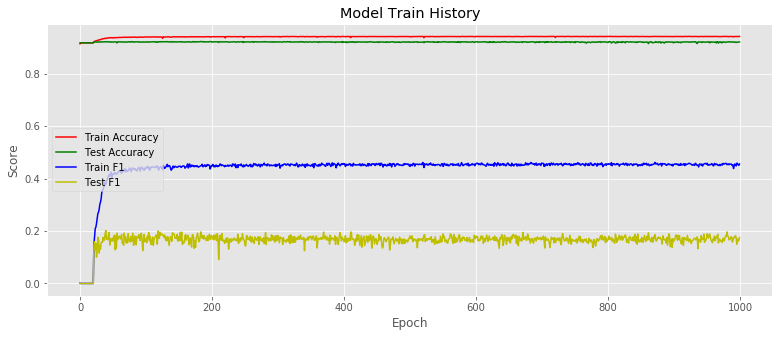

CLASSIFIER PERFORMANCE WASHER DRYER 2 MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,washer dryer 2,92.09,63.27,10.46,17.95,56.9,0.08,0.55,9863,889



CONFUSION MATRIX (OFF/ON):

 - washer dryer 2:
[[9809   54]
 [ 796   93]]


---> Splitting `{}` data (train/test)...
---> Training the `microwave` model...

Train on 32253 samples, validate on 10752 samples
Epoch 1/1000
32253/32253 - 23s - loss: 0.0351 - accuracy: 0.9917 - f1: 0.9949 - val_loss: 0.0305 - val_accuracy: 0.9962 - val_f1: 0.9981
Epoch 2/1000
32253/32253 - 21s - loss: 0.0232 - accuracy: 0.9962 - f1: 0.9981 - val_loss: 0.0253 - val_accuracy: 0.9962 - val_f1: 0.9981
Epoch 3/1000
32253/32253 - 21s - loss: 0.0230 - accuracy: 0.9962 - f1: 0.9981 - val_loss: 0.0424 - val_accuracy: 0.9962 - val_f1: 0.9981
Epoch 4/1000
32253/32253 - 21s - loss: 0.0221 - accuracy: 0.9962 - f1: 0.9981 - val_loss: 0.0271 - val_accuracy: 0.9962 - val_f1: 0.9981
Epoch 5/1000
32253/32253 - 20s - loss: 0.0224 - accuracy: 0.9962 - f1: 0.9981 - val_loss: 0.0256 - val_accuracy: 0.9962 - val_f1: 0.9981
Epoch 6/1000
32253/32253 - 20s - loss: 0.0224 - accuracy: 0.9962 - f1: 0.9981 - val_loss: 0.0292 - val_accu

Epoch 59/1000
32253/32253 - 20s - loss: 0.0037 - accuracy: 0.9996 - f1: 0.9998 - val_loss: 0.0698 - val_accuracy: 0.9961 - val_f1: 0.9980
Epoch 60/1000
32253/32253 - 20s - loss: 0.0036 - accuracy: 0.9996 - f1: 0.9998 - val_loss: 0.0656 - val_accuracy: 0.9961 - val_f1: 0.9980
Epoch 61/1000
32253/32253 - 20s - loss: 0.0038 - accuracy: 0.9995 - f1: 0.9998 - val_loss: 0.0609 - val_accuracy: 0.9961 - val_f1: 0.9980
Epoch 62/1000
32253/32253 - 20s - loss: 0.0038 - accuracy: 0.9996 - f1: 0.9998 - val_loss: 0.0590 - val_accuracy: 0.9954 - val_f1: 0.9977
Epoch 63/1000
32253/32253 - 20s - loss: 0.0040 - accuracy: 0.9994 - f1: 0.9997 - val_loss: 0.0709 - val_accuracy: 0.9959 - val_f1: 0.9979
Epoch 64/1000
32253/32253 - 20s - loss: 0.0039 - accuracy: 0.9996 - f1: 0.9998 - val_loss: 0.0732 - val_accuracy: 0.9962 - val_f1: 0.9981
Epoch 65/1000
32253/32253 - 20s - loss: 0.0036 - accuracy: 0.9996 - f1: 0.9998 - val_loss: 0.0668 - val_accuracy: 0.9961 - val_f1: 0.9980
Epoch 66/1000
32253/32253 - 20s - 

Epoch 119/1000
32253/32253 - 20s - loss: 0.0034 - accuracy: 0.9996 - f1: 0.9998 - val_loss: 0.0940 - val_accuracy: 0.9961 - val_f1: 0.9980
Epoch 120/1000
32253/32253 - 20s - loss: 0.0036 - accuracy: 0.9996 - f1: 0.9998 - val_loss: 0.0900 - val_accuracy: 0.9962 - val_f1: 0.9981
Epoch 121/1000
32253/32253 - 20s - loss: 0.0033 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.0927 - val_accuracy: 0.9962 - val_f1: 0.9981
Epoch 122/1000
32253/32253 - 20s - loss: 0.0033 - accuracy: 0.9996 - f1: 0.9998 - val_loss: 0.0861 - val_accuracy: 0.9962 - val_f1: 0.9981
Epoch 123/1000
32253/32253 - 20s - loss: 0.0032 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.0893 - val_accuracy: 0.9961 - val_f1: 0.9980
Epoch 124/1000
32253/32253 - 20s - loss: 0.0035 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.0916 - val_accuracy: 0.9962 - val_f1: 0.9981
Epoch 125/1000
32253/32253 - 20s - loss: 0.0033 - accuracy: 0.9996 - f1: 0.9998 - val_loss: 0.0769 - val_accuracy: 0.9957 - val_f1: 0.9979
Epoch 126/1000
32253/32253 

Epoch 178/1000
32253/32253 - 20s - loss: 0.0035 - accuracy: 0.9996 - f1: 0.9998 - val_loss: 0.0996 - val_accuracy: 0.9962 - val_f1: 0.9981
Epoch 179/1000
32253/32253 - 20s - loss: 0.0031 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1087 - val_accuracy: 0.9962 - val_f1: 0.9981
Epoch 180/1000
32253/32253 - 21s - loss: 0.0032 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.0971 - val_accuracy: 0.9961 - val_f1: 0.9980
Epoch 181/1000
32253/32253 - 20s - loss: 0.0033 - accuracy: 0.9996 - f1: 0.9998 - val_loss: 0.0742 - val_accuracy: 0.9953 - val_f1: 0.9976
Epoch 182/1000
32253/32253 - 20s - loss: 0.0035 - accuracy: 0.9996 - f1: 0.9998 - val_loss: 0.0867 - val_accuracy: 0.9959 - val_f1: 0.9979
Epoch 183/1000
32253/32253 - 20s - loss: 0.0035 - accuracy: 0.9996 - f1: 0.9998 - val_loss: 0.1175 - val_accuracy: 0.9963 - val_f1: 0.9981
Epoch 184/1000
32253/32253 - 20s - loss: 0.0031 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1015 - val_accuracy: 0.9963 - val_f1: 0.9981
Epoch 185/1000
32253/32253 

Epoch 237/1000
32253/32253 - 20s - loss: 0.0033 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1333 - val_accuracy: 0.9962 - val_f1: 0.9981
Epoch 238/1000
32253/32253 - 20s - loss: 0.0028 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1201 - val_accuracy: 0.9962 - val_f1: 0.9981
Epoch 239/1000
32253/32253 - 20s - loss: 0.0030 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1365 - val_accuracy: 0.9963 - val_f1: 0.9981
Epoch 240/1000
32253/32253 - 20s - loss: 0.0032 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1102 - val_accuracy: 0.9961 - val_f1: 0.9980
Epoch 241/1000
32253/32253 - 20s - loss: 0.0030 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1441 - val_accuracy: 0.9962 - val_f1: 0.9981
Epoch 242/1000
32253/32253 - 20s - loss: 0.0033 - accuracy: 0.9996 - f1: 0.9998 - val_loss: 0.0983 - val_accuracy: 0.9960 - val_f1: 0.9980
Epoch 243/1000
32253/32253 - 20s - loss: 0.0030 - accuracy: 0.9996 - f1: 0.9998 - val_loss: 0.1193 - val_accuracy: 0.9963 - val_f1: 0.9981
Epoch 244/1000
32253/32253 

Epoch 296/1000
32253/32253 - 20s - loss: 0.0032 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1374 - val_accuracy: 0.9961 - val_f1: 0.9980
Epoch 297/1000
32253/32253 - 20s - loss: 0.0030 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1273 - val_accuracy: 0.9960 - val_f1: 0.9980
Epoch 298/1000
32253/32253 - 20s - loss: 0.0032 - accuracy: 0.9996 - f1: 0.9998 - val_loss: 0.1226 - val_accuracy: 0.9960 - val_f1: 0.9980
Epoch 299/1000
32253/32253 - 20s - loss: 0.0030 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1248 - val_accuracy: 0.9959 - val_f1: 0.9979
Epoch 300/1000
32253/32253 - 20s - loss: 0.0040 - accuracy: 0.9994 - f1: 0.9997 - val_loss: 0.1084 - val_accuracy: 0.9959 - val_f1: 0.9979
Epoch 301/1000
32253/32253 - 20s - loss: 0.0032 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1360 - val_accuracy: 0.9961 - val_f1: 0.9980
Epoch 302/1000
32253/32253 - 20s - loss: 0.0035 - accuracy: 0.9996 - f1: 0.9998 - val_loss: 0.1308 - val_accuracy: 0.9962 - val_f1: 0.9981
Epoch 303/1000
32253/32253 

Epoch 355/1000
32253/32253 - 20s - loss: 0.0032 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1321 - val_accuracy: 0.9961 - val_f1: 0.9980
Epoch 356/1000
32253/32253 - 20s - loss: 0.0030 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1392 - val_accuracy: 0.9961 - val_f1: 0.9980
Epoch 357/1000
32253/32253 - 20s - loss: 0.0030 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1150 - val_accuracy: 0.9961 - val_f1: 0.9980
Epoch 358/1000
32253/32253 - 20s - loss: 0.0031 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1320 - val_accuracy: 0.9962 - val_f1: 0.9981
Epoch 359/1000
32253/32253 - 20s - loss: 0.0031 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1240 - val_accuracy: 0.9961 - val_f1: 0.9980
Epoch 360/1000
32253/32253 - 20s - loss: 0.0033 - accuracy: 0.9996 - f1: 0.9998 - val_loss: 0.0988 - val_accuracy: 0.9953 - val_f1: 0.9977
Epoch 361/1000
32253/32253 - 20s - loss: 0.0032 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1275 - val_accuracy: 0.9962 - val_f1: 0.9981
Epoch 362/1000
32253/32253 

Epoch 414/1000
32253/32253 - 20s - loss: 0.0032 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1433 - val_accuracy: 0.9963 - val_f1: 0.9981
Epoch 415/1000
32253/32253 - 20s - loss: 0.0037 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1428 - val_accuracy: 0.9961 - val_f1: 0.9980
Epoch 416/1000
32253/32253 - 20s - loss: 0.0032 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1074 - val_accuracy: 0.9960 - val_f1: 0.9980
Epoch 417/1000
32253/32253 - 20s - loss: 0.0033 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1205 - val_accuracy: 0.9960 - val_f1: 0.9980
Epoch 418/1000
32253/32253 - 20s - loss: 0.0033 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1311 - val_accuracy: 0.9961 - val_f1: 0.9980
Epoch 419/1000
32253/32253 - 20s - loss: 0.0030 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1296 - val_accuracy: 0.9960 - val_f1: 0.9980
Epoch 420/1000
32253/32253 - 20s - loss: 0.0031 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1165 - val_accuracy: 0.9960 - val_f1: 0.9980
Epoch 421/1000
32253/32253 

Epoch 473/1000
32253/32253 - 20s - loss: 0.0034 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1351 - val_accuracy: 0.9962 - val_f1: 0.9981
Epoch 474/1000
32253/32253 - 20s - loss: 0.0033 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1321 - val_accuracy: 0.9961 - val_f1: 0.9980
Epoch 475/1000
32253/32253 - 20s - loss: 0.0033 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1229 - val_accuracy: 0.9962 - val_f1: 0.9981
Epoch 476/1000
32253/32253 - 20s - loss: 0.0030 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1426 - val_accuracy: 0.9961 - val_f1: 0.9980
Epoch 477/1000
32253/32253 - 20s - loss: 0.0034 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1234 - val_accuracy: 0.9959 - val_f1: 0.9979
Epoch 478/1000
32253/32253 - 20s - loss: 0.0031 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1301 - val_accuracy: 0.9962 - val_f1: 0.9981
Epoch 479/1000
32253/32253 - 20s - loss: 0.0031 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1413 - val_accuracy: 0.9963 - val_f1: 0.9981
Epoch 480/1000
32253/32253 

Epoch 532/1000
32253/32253 - 20s - loss: 0.0030 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1150 - val_accuracy: 0.9960 - val_f1: 0.9980
Epoch 533/1000
32253/32253 - 20s - loss: 0.0029 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1260 - val_accuracy: 0.9961 - val_f1: 0.9980
Epoch 534/1000
32253/32253 - 20s - loss: 0.0031 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1194 - val_accuracy: 0.9960 - val_f1: 0.9980
Epoch 535/1000
32253/32253 - 20s - loss: 0.0028 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1275 - val_accuracy: 0.9962 - val_f1: 0.9981
Epoch 536/1000
32253/32253 - 20s - loss: 0.0032 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1221 - val_accuracy: 0.9961 - val_f1: 0.9980
Epoch 537/1000
32253/32253 - 20s - loss: 0.0029 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1078 - val_accuracy: 0.9959 - val_f1: 0.9979
Epoch 538/1000
32253/32253 - 20s - loss: 0.0032 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1101 - val_accuracy: 0.9958 - val_f1: 0.9979
Epoch 539/1000
32253/32253 

Epoch 591/1000
32253/32253 - 20s - loss: 0.0041 - accuracy: 0.9996 - f1: 0.9998 - val_loss: 0.1298 - val_accuracy: 0.9962 - val_f1: 0.9981
Epoch 592/1000
32253/32253 - 20s - loss: 0.0034 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1286 - val_accuracy: 0.9962 - val_f1: 0.9981
Epoch 593/1000
32253/32253 - 20s - loss: 0.0030 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1067 - val_accuracy: 0.9959 - val_f1: 0.9979
Epoch 594/1000
32253/32253 - 20s - loss: 0.0030 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1049 - val_accuracy: 0.9959 - val_f1: 0.9979
Epoch 595/1000
32253/32253 - 20s - loss: 0.0032 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1127 - val_accuracy: 0.9960 - val_f1: 0.9980
Epoch 596/1000
32253/32253 - 20s - loss: 0.0032 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1251 - val_accuracy: 0.9962 - val_f1: 0.9981
Epoch 597/1000
32253/32253 - 20s - loss: 0.0030 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1187 - val_accuracy: 0.9963 - val_f1: 0.9981
Epoch 598/1000
32253/32253 

Epoch 650/1000
32253/32253 - 20s - loss: 0.0030 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1295 - val_accuracy: 0.9962 - val_f1: 0.9981
Epoch 651/1000
32253/32253 - 20s - loss: 0.0028 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1287 - val_accuracy: 0.9962 - val_f1: 0.9981
Epoch 652/1000
32253/32253 - 20s - loss: 0.0033 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1188 - val_accuracy: 0.9961 - val_f1: 0.9980
Epoch 653/1000
32253/32253 - 20s - loss: 0.0033 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1382 - val_accuracy: 0.9962 - val_f1: 0.9981
Epoch 654/1000
32253/32253 - 20s - loss: 0.0033 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1191 - val_accuracy: 0.9958 - val_f1: 0.9979
Epoch 655/1000
32253/32253 - 20s - loss: 0.0030 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1277 - val_accuracy: 0.9959 - val_f1: 0.9979
Epoch 656/1000
32253/32253 - 20s - loss: 0.0030 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1272 - val_accuracy: 0.9960 - val_f1: 0.9980
Epoch 657/1000
32253/32253 

Epoch 709/1000
32253/32253 - 20s - loss: 0.0032 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1505 - val_accuracy: 0.9960 - val_f1: 0.9980
Epoch 710/1000
32253/32253 - 20s - loss: 0.0032 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1314 - val_accuracy: 0.9960 - val_f1: 0.9980
Epoch 711/1000
32253/32253 - 20s - loss: 0.0033 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1374 - val_accuracy: 0.9960 - val_f1: 0.9980
Epoch 712/1000
32253/32253 - 20s - loss: 0.0031 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.0995 - val_accuracy: 0.9954 - val_f1: 0.9977
Epoch 713/1000
32253/32253 - 20s - loss: 0.0032 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1229 - val_accuracy: 0.9960 - val_f1: 0.9980
Epoch 714/1000
32253/32253 - 20s - loss: 0.0033 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1128 - val_accuracy: 0.9956 - val_f1: 0.9978
Epoch 715/1000
32253/32253 - 20s - loss: 0.0033 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1146 - val_accuracy: 0.9960 - val_f1: 0.9980
Epoch 716/1000
32253/32253 

Epoch 768/1000
32253/32253 - 20s - loss: 0.0031 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1251 - val_accuracy: 0.9961 - val_f1: 0.9980
Epoch 769/1000
32253/32253 - 20s - loss: 0.0030 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1225 - val_accuracy: 0.9961 - val_f1: 0.9980
Epoch 770/1000
32253/32253 - 20s - loss: 0.0033 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1419 - val_accuracy: 0.9961 - val_f1: 0.9980
Epoch 771/1000
32253/32253 - 20s - loss: 0.0033 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1213 - val_accuracy: 0.9960 - val_f1: 0.9980
Epoch 772/1000
32253/32253 - 20s - loss: 0.0031 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1145 - val_accuracy: 0.9960 - val_f1: 0.9980
Epoch 773/1000
32253/32253 - 20s - loss: 0.0029 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1195 - val_accuracy: 0.9960 - val_f1: 0.9980
Epoch 774/1000
32253/32253 - 20s - loss: 0.0033 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1230 - val_accuracy: 0.9960 - val_f1: 0.9980
Epoch 775/1000
32253/32253 

Epoch 827/1000
32253/32253 - 20s - loss: 0.0031 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1405 - val_accuracy: 0.9961 - val_f1: 0.9980
Epoch 828/1000
32253/32253 - 20s - loss: 0.0032 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1259 - val_accuracy: 0.9959 - val_f1: 0.9979
Epoch 829/1000
32253/32253 - 20s - loss: 0.0032 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1389 - val_accuracy: 0.9957 - val_f1: 0.9979
Epoch 830/1000
32253/32253 - 20s - loss: 0.0031 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1513 - val_accuracy: 0.9959 - val_f1: 0.9979
Epoch 831/1000
32253/32253 - 20s - loss: 0.0032 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1503 - val_accuracy: 0.9961 - val_f1: 0.9980
Epoch 832/1000
32253/32253 - 20s - loss: 0.0032 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1480 - val_accuracy: 0.9961 - val_f1: 0.9980
Epoch 833/1000
32253/32253 - 20s - loss: 0.0031 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1154 - val_accuracy: 0.9960 - val_f1: 0.9980
Epoch 834/1000
32253/32253 

Epoch 886/1000
32253/32253 - 20s - loss: 0.0033 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1202 - val_accuracy: 0.9959 - val_f1: 0.9979
Epoch 887/1000
32253/32253 - 20s - loss: 0.0028 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1316 - val_accuracy: 0.9960 - val_f1: 0.9980
Epoch 888/1000
32253/32253 - 20s - loss: 0.0030 - accuracy: 0.9996 - f1: 0.9998 - val_loss: 0.1142 - val_accuracy: 0.9956 - val_f1: 0.9978
Epoch 889/1000
32253/32253 - 20s - loss: 0.0033 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1245 - val_accuracy: 0.9959 - val_f1: 0.9979
Epoch 890/1000
32253/32253 - 20s - loss: 0.0028 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1394 - val_accuracy: 0.9961 - val_f1: 0.9980
Epoch 891/1000
32253/32253 - 20s - loss: 0.0029 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1360 - val_accuracy: 0.9961 - val_f1: 0.9980
Epoch 892/1000
32253/32253 - 20s - loss: 0.0031 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1382 - val_accuracy: 0.9961 - val_f1: 0.9980
Epoch 893/1000
32253/32253 

Epoch 945/1000
32253/32253 - 20s - loss: 0.0031 - accuracy: 0.9996 - f1: 0.9998 - val_loss: 0.1214 - val_accuracy: 0.9961 - val_f1: 0.9980
Epoch 946/1000
32253/32253 - 20s - loss: 0.0030 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1254 - val_accuracy: 0.9961 - val_f1: 0.9980
Epoch 947/1000
32253/32253 - 20s - loss: 0.0031 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1263 - val_accuracy: 0.9960 - val_f1: 0.9980
Epoch 948/1000
32253/32253 - 20s - loss: 0.0032 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1392 - val_accuracy: 0.9961 - val_f1: 0.9980
Epoch 949/1000
32253/32253 - 20s - loss: 0.0030 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1408 - val_accuracy: 0.9962 - val_f1: 0.9981
Epoch 950/1000
32253/32253 - 20s - loss: 0.0029 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1386 - val_accuracy: 0.9961 - val_f1: 0.9980
Epoch 951/1000
32253/32253 - 20s - loss: 0.0031 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1221 - val_accuracy: 0.9959 - val_f1: 0.9979
Epoch 952/1000
32253/32253 

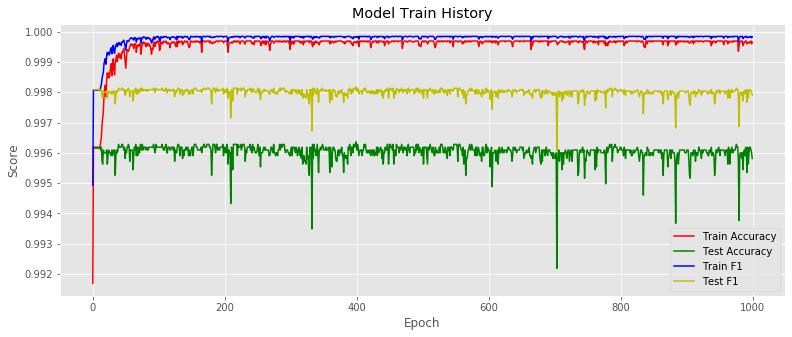

CLASSIFIER PERFORMANCE MICROWAVE MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,microwave,99.58,99.62,99.96,99.79,49.9,0.0,0.5,41,10711



CONFUSION MATRIX (OFF/ON):

 - microwave:
[[    0    41]
 [    4 10707]]



In [17]:
# Model fit...
for i in range(labels_binary.shape[1]):
    
    print("")
    print("---> Splitting `{}` data (train/test)...")
    X_train, X_test, y_train, y_test = train_test_split(
        series_images, labels_binary[:, i],
        stratify = labels_binary[:, i],
        random_state=SEED, test_size=TEST_SIZE#, shuffle=True
    )

    print("---> Training the `{}` model...\n".format(valid_appliances[i]))
    
    #model = cnn_model(output_layer_length=1)
    model = dcnn_appliance()
    
    # Calibrating model..
    callback = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test), 
        epochs=EPOCHS, batch_size=BATCH_SIZE,
        verbose = 2#, callbacks = [tbCallback]
    )
    
    # Plot metrics...
    fig = plt.figure(figsize=(13,5))
    line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
    line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
    line_f1_m = plt.plot(callback.history["f1"], label = "Train F1", color = "b")
    line_val_f1_m = plt.plot(callback.history["val_f1"], label = "Test F1", color = "y")
    plt.title("Model Train History")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

    # Final report (validated on test set)
    y_pred = np.array(model.predict(X_test).round())
    classification_report_appliance(y_test, y_pred, label = valid_appliances[i])
    
    print("")

In [ ]:
# Model fit...
for i in range(y_train.shape[1]):
    print("---> Training the `{}` model...\n".format(valid_appliances[i]))
    #model = cnn_model(output_layer_length=1)
    model = vgg_appliance()
    
    # Calibrating model..
    callback = model.fit(
        X_train, y_train[:, i],
        validation_data=(X_test, y_test[:, i]), 
        epochs=100, batch_size=32,
        verbose = 2, callbacks = [tbCallback]
    )
    
    # Plot metrics...
    fig = plt.figure(figsize=(13,5))
    line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
    line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
    line_f1_m = plt.plot(callback.history["f1"], label = "Train F1", color = "b")
    line_val_f1_m = plt.plot(callback.history["val_f1"], label = "Test F1", color = "y")
    plt.title("Model Train History")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

    # Final report (validated on test set)
    y_pred = np.array(model.predict(X_test).round())
    classification_report_appliance(y_test[:, i], y_pred, label = valid_appliances[i])
    
    print("")

In [ ]:
# i = 4
# model = vgg_model_appliance()

# # Calibrating model..
# callback = model.fit(
#     train_gaf_images, yb1_train[:, i],
#     validation_data=(test_gaf_images, yb1_test[:, i]), 
#     epochs=100, batch_size=32,
#     verbose = 2#, callbacks = [tqdm_callback]
# )

# # Plot metrics...
# fig = plt.figure(figsize=(13,5))
# line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
# line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
# line_f1_m = plt.plot(callback.history["f1_m"], label = "Train F1", color = "b")
# line_val_f1_m = plt.plot(callback.history["val_f1_m"], label = "Test F1", color = "y")
# plt.title("Model Train History")
# plt.xlabel("Epoch")
# plt.ylabel("Score")
# plt.legend()
# plt.show()

# # Final report (validated on test set)
# y_pred = np.array(model.predict(test_gaf_images).round())
# classification_report_appliance(yb1_test[:, i], y_pred, label = valid_appliances[i])

# print("")

## Imagens RP

In [15]:
# if not os.path.isfile( os.path.join(DATASET_PATH, "rp_images.npy") ):
    
#     print("Generating RP images from data...")
#     rp_pipeline = Pipeline([
#         ('recurrenceplot', RecurrencePlot()),
#         ('imageprocessing', ImageProcessing())
#     ])
#     series_images = rp_pipeline.fit_transform(mains[mains_idx,:,:], imageprocessing__mode = "_")
# else:
#     print("Loading RP images...")
#     series_images = np.load(os.path.join(DATASET_PATH, "rp_images.npy"))

In [16]:
# plt.imshow(series_images[0]);
# plt.axis('off')

In [17]:
# From the aforementioned definitions, it becomes evident
# that the recurrence plot depends on three parameters, the delay
# τ , the embedding dimension D and the radius , to capture
# the correct dynamics of a system with noise.
# https://www.researchgate.net/publication/326290928_Optimising_Parameters_in_Recurrence_Quantification_Analysis_of_Smart_Energy_Systems
# https://oro.open.ac.uk/55774/1/RAE-arxiv.pdf
rp_pipeline = Pipeline([
    ('recurrenceplot', RecurrencePlot(
            dimension = 1,
            threshold = None,
            time_delay = 1,
            percentage = 10
        )),
    ('imageprocessing', ImageProcessing())
])
series_images = rp_pipeline.fit_transform(mains[mains_idx,:,:], imageprocessing__mode = "_")
# plt.imshow(series_images[3]);
# plt.axis('off');

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(
#     series_images, labels_binary,
#     #stratify = labels_binary,
#     random_state=SEED, test_size=TEXT_SIZE, shuffle=True
# )

# print("X_train shape:", X_train.shape)
# print("y_train shape:", y_train.shape)
# print("---")
# print("X_test shape:", X_test.shape)
# print("y_test shape:", y_test.shape)

# del series_images

In [ ]:
BATCH_SIZE = 256

### Classificadores Multilabel

In [ ]:
# Model fit...
print("Training RP multilabel model...")

multiabel_rp_model = dcnn_multilabel()

callback = multiabel_rp_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test), 
    epochs=100, 
    batch_size=32,
    verbose = 2, callbacks = [tbCallback]
)

# Plot metrics...
fig = plt.figure(figsize=(13,5))
line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
line_f1_m = plt.plot(callback.history["f1"], label = "Train F1", color = "b")
line_val_f1_m = plt.plot(callback.history["val_f1"], label = "Test F1", color = "y")
plt.title("Model Train History")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.show()

# Final report (validated on test set)
y_pred = np.array(multiabel_rp_model.predict(X_test).round())
classification_report(y_test, y_pred, labels = valid_appliances)

In [ ]:
# Model fit...
print("Training RP multilabel model...")

multiabel_rp_model = tiled_cnn_multilabel()#vgg_model_multilabel()

callback = multiabel_rp_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test), 
    epochs=100, 
    batch_size=32,
    verbose = 2, callbacks = [tbCallback]
)

# Plot metrics...
fig = plt.figure(figsize=(13,5))
line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
line_f1_m = plt.plot(callback.history["f1"], label = "Train F1", color = "b")
line_val_f1_m = plt.plot(callback.history["val_f1"], label = "Test F1", color = "y")
plt.title("Model Train History")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.show()

# Final report (validated on test set)
y_pred = np.array(multiabel_rp_model.predict(X_test).round())
classification_report(y_test, y_pred, labels = valid_appliances)

In [ ]:
# Model fit...
print("Training RP multilabel model...")

multiabel_rp_model = vgg_multilabel()

callback = multiabel_rp_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test), 
    epochs=100, 
    batch_size=32,
    verbose = 2, callbacks = [tbCallback]
)

# Plot metrics...
fig = plt.figure(figsize=(13,5))
line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
line_f1_m = plt.plot(callback.history["f1"], label = "Train F1", color = "b")
line_val_f1_m = plt.plot(callback.history["val_f1"], label = "Test F1", color = "y")
plt.title("Model Train History")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.show()

# Final report (validated on test set)
y_pred = np.array(multiabel_rp_model.predict(X_test).round())
classification_report(y_test, y_pred, labels = valid_appliances)

### Classificadores Especialistas(Binários)


---> Splitting `{}` data (train/test)...
---> Training the `refrigerator` model...

Train on 32253 samples, validate on 10752 samples
Epoch 1/1000
32253/32253 - 36s - loss: 0.4772 - accuracy: 0.8157 - f1: 0.8981 - val_loss: 0.4865 - val_accuracy: 0.8168 - val_f1: 0.8990
Epoch 2/1000
32253/32253 - 21s - loss: 0.4515 - accuracy: 0.8168 - f1: 0.8990 - val_loss: 0.4903 - val_accuracy: 0.8168 - val_f1: 0.8990
Epoch 3/1000
32253/32253 - 21s - loss: 0.4513 - accuracy: 0.8168 - f1: 0.8990 - val_loss: 0.4883 - val_accuracy: 0.8168 - val_f1: 0.8990
Epoch 4/1000
32253/32253 - 21s - loss: 0.4491 - accuracy: 0.8168 - f1: 0.8990 - val_loss: 0.4828 - val_accuracy: 0.8168 - val_f1: 0.8990
Epoch 5/1000
32253/32253 - 21s - loss: 0.4489 - accuracy: 0.8168 - f1: 0.8990 - val_loss: 0.4805 - val_accuracy: 0.8168 - val_f1: 0.8990
Epoch 6/1000
32253/32253 - 21s - loss: 0.4467 - accuracy: 0.8168 - f1: 0.8990 - val_loss: 0.4686 - val_accuracy: 0.8168 - val_f1: 0.8990
Epoch 7/1000
32253/32253 - 21s - loss: 0.44

Epoch 60/1000
32253/32253 - 20s - loss: 0.3718 - accuracy: 0.8355 - f1: 0.9081 - val_loss: 0.6995 - val_accuracy: 0.8145 - val_f1: 0.8975
Epoch 61/1000
32253/32253 - 20s - loss: 0.3691 - accuracy: 0.8366 - f1: 0.9087 - val_loss: 0.6791 - val_accuracy: 0.8123 - val_f1: 0.8962
Epoch 62/1000
32253/32253 - 20s - loss: 0.3709 - accuracy: 0.8362 - f1: 0.9084 - val_loss: 0.6690 - val_accuracy: 0.8130 - val_f1: 0.8965
Epoch 63/1000
32253/32253 - 20s - loss: 0.3704 - accuracy: 0.8359 - f1: 0.9083 - val_loss: 0.6580 - val_accuracy: 0.8120 - val_f1: 0.8960
Epoch 64/1000
32253/32253 - 20s - loss: 0.3694 - accuracy: 0.8366 - f1: 0.9087 - val_loss: 0.7034 - val_accuracy: 0.8125 - val_f1: 0.8963
Epoch 65/1000
32253/32253 - 20s - loss: 0.3705 - accuracy: 0.8361 - f1: 0.9084 - val_loss: 0.7196 - val_accuracy: 0.8130 - val_f1: 0.8966
Epoch 66/1000
32253/32253 - 20s - loss: 0.3689 - accuracy: 0.8369 - f1: 0.9088 - val_loss: 0.6866 - val_accuracy: 0.8112 - val_f1: 0.8954
Epoch 67/1000
32253/32253 - 20s - 

Epoch 120/1000
32253/32253 - 20s - loss: 0.3621 - accuracy: 0.8393 - f1: 0.9101 - val_loss: 0.8908 - val_accuracy: 0.8123 - val_f1: 0.8961
Epoch 121/1000
32253/32253 - 20s - loss: 0.3613 - accuracy: 0.8389 - f1: 0.9098 - val_loss: 0.8690 - val_accuracy: 0.8111 - val_f1: 0.8954
Epoch 122/1000
32253/32253 - 20s - loss: 0.3610 - accuracy: 0.8393 - f1: 0.9101 - val_loss: 0.9225 - val_accuracy: 0.8125 - val_f1: 0.8963
Epoch 123/1000
32253/32253 - 20s - loss: 0.3592 - accuracy: 0.8397 - f1: 0.9104 - val_loss: 0.9704 - val_accuracy: 0.8130 - val_f1: 0.8965
Epoch 124/1000
32253/32253 - 20s - loss: 0.3593 - accuracy: 0.8396 - f1: 0.9103 - val_loss: 1.0079 - val_accuracy: 0.8131 - val_f1: 0.8966
Epoch 125/1000
32253/32253 - 20s - loss: 0.3597 - accuracy: 0.8394 - f1: 0.9102 - val_loss: 0.9327 - val_accuracy: 0.8125 - val_f1: 0.8962
Epoch 126/1000
32253/32253 - 20s - loss: 0.3618 - accuracy: 0.8391 - f1: 0.9100 - val_loss: 0.8881 - val_accuracy: 0.8115 - val_f1: 0.8956
Epoch 127/1000
32253/32253 

Epoch 179/1000
32253/32253 - 20s - loss: 0.3585 - accuracy: 0.8399 - f1: 0.9104 - val_loss: 0.9881 - val_accuracy: 0.8122 - val_f1: 0.8961
Epoch 180/1000
32253/32253 - 20s - loss: 0.3573 - accuracy: 0.8402 - f1: 0.9106 - val_loss: 1.0296 - val_accuracy: 0.8134 - val_f1: 0.8968
Epoch 181/1000
32253/32253 - 20s - loss: 0.3573 - accuracy: 0.8399 - f1: 0.9105 - val_loss: 1.0218 - val_accuracy: 0.8132 - val_f1: 0.8967
Epoch 182/1000
32253/32253 - 20s - loss: 0.3577 - accuracy: 0.8393 - f1: 0.9102 - val_loss: 1.0826 - val_accuracy: 0.8132 - val_f1: 0.8967
Epoch 183/1000
32253/32253 - 20s - loss: 0.3583 - accuracy: 0.8399 - f1: 0.9105 - val_loss: 1.0089 - val_accuracy: 0.8125 - val_f1: 0.8962
Epoch 184/1000
32253/32253 - 20s - loss: 0.3575 - accuracy: 0.8395 - f1: 0.9103 - val_loss: 1.0768 - val_accuracy: 0.8127 - val_f1: 0.8964
Epoch 185/1000
32253/32253 - 20s - loss: 0.3578 - accuracy: 0.8399 - f1: 0.9105 - val_loss: 1.0812 - val_accuracy: 0.8132 - val_f1: 0.8967
Epoch 186/1000
32253/32253 

Epoch 238/1000
32253/32253 - 20s - loss: 0.3568 - accuracy: 0.8402 - f1: 0.9107 - val_loss: 1.1944 - val_accuracy: 0.8139 - val_f1: 0.8971
Epoch 239/1000
32253/32253 - 20s - loss: 0.3559 - accuracy: 0.8405 - f1: 0.9108 - val_loss: 1.1189 - val_accuracy: 0.8127 - val_f1: 0.8964
Epoch 240/1000
32253/32253 - 20s - loss: 0.3562 - accuracy: 0.8404 - f1: 0.9108 - val_loss: 1.1697 - val_accuracy: 0.8127 - val_f1: 0.8963
Epoch 241/1000
32253/32253 - 20s - loss: 0.3553 - accuracy: 0.8407 - f1: 0.9109 - val_loss: 1.2377 - val_accuracy: 0.8128 - val_f1: 0.8964
Epoch 242/1000
32253/32253 - 20s - loss: 0.3566 - accuracy: 0.8403 - f1: 0.9107 - val_loss: 1.2178 - val_accuracy: 0.8130 - val_f1: 0.8966
Epoch 243/1000
32253/32253 - 20s - loss: 0.3571 - accuracy: 0.8401 - f1: 0.9106 - val_loss: 1.0513 - val_accuracy: 0.8111 - val_f1: 0.8954
Epoch 244/1000
32253/32253 - 20s - loss: 0.3581 - accuracy: 0.8400 - f1: 0.9105 - val_loss: 1.0579 - val_accuracy: 0.8132 - val_f1: 0.8967
Epoch 245/1000
32253/32253 

Epoch 297/1000
32253/32253 - 20s - loss: 0.3549 - accuracy: 0.8408 - f1: 0.9110 - val_loss: 1.1244 - val_accuracy: 0.8125 - val_f1: 0.8962
Epoch 298/1000
32253/32253 - 20s - loss: 0.3565 - accuracy: 0.8403 - f1: 0.9107 - val_loss: 1.0987 - val_accuracy: 0.8124 - val_f1: 0.8962
Epoch 299/1000
32253/32253 - 20s - loss: 0.3558 - accuracy: 0.8402 - f1: 0.9107 - val_loss: 1.2300 - val_accuracy: 0.8135 - val_f1: 0.8969
Epoch 300/1000
32253/32253 - 20s - loss: 0.3561 - accuracy: 0.8405 - f1: 0.9108 - val_loss: 1.1789 - val_accuracy: 0.8123 - val_f1: 0.8962
Epoch 301/1000
32253/32253 - 20s - loss: 0.3567 - accuracy: 0.8403 - f1: 0.9107 - val_loss: 1.0864 - val_accuracy: 0.8120 - val_f1: 0.8959
Epoch 302/1000
32253/32253 - 20s - loss: 0.3553 - accuracy: 0.8408 - f1: 0.9110 - val_loss: 1.1276 - val_accuracy: 0.8118 - val_f1: 0.8959
Epoch 303/1000
32253/32253 - 20s - loss: 0.3551 - accuracy: 0.8405 - f1: 0.9108 - val_loss: 1.0645 - val_accuracy: 0.8111 - val_f1: 0.8954
Epoch 304/1000
32253/32253 

Epoch 356/1000
32253/32253 - 20s - loss: 0.3554 - accuracy: 0.8405 - f1: 0.9109 - val_loss: 1.1875 - val_accuracy: 0.8132 - val_f1: 0.8967
Epoch 357/1000
32253/32253 - 20s - loss: 0.3561 - accuracy: 0.8404 - f1: 0.9107 - val_loss: 1.2066 - val_accuracy: 0.8124 - val_f1: 0.8963
Epoch 358/1000
32253/32253 - 20s - loss: 0.3560 - accuracy: 0.8402 - f1: 0.9106 - val_loss: 1.1491 - val_accuracy: 0.8120 - val_f1: 0.8960
Epoch 359/1000
32253/32253 - 20s - loss: 0.3554 - accuracy: 0.8404 - f1: 0.9108 - val_loss: 1.2638 - val_accuracy: 0.8130 - val_f1: 0.8965
Epoch 360/1000
32253/32253 - 20s - loss: 0.3556 - accuracy: 0.8403 - f1: 0.9107 - val_loss: 1.1236 - val_accuracy: 0.8125 - val_f1: 0.8963
Epoch 361/1000
32253/32253 - 20s - loss: 0.3561 - accuracy: 0.8406 - f1: 0.9109 - val_loss: 1.1481 - val_accuracy: 0.8119 - val_f1: 0.8959
Epoch 362/1000
32253/32253 - 20s - loss: 0.3547 - accuracy: 0.8406 - f1: 0.9109 - val_loss: 1.2614 - val_accuracy: 0.8127 - val_f1: 0.8963
Epoch 363/1000
32253/32253 

Epoch 415/1000
32253/32253 - 20s - loss: 0.3552 - accuracy: 0.8410 - f1: 0.9111 - val_loss: 1.2470 - val_accuracy: 0.8124 - val_f1: 0.8962
Epoch 416/1000
32253/32253 - 20s - loss: 0.3539 - accuracy: 0.8411 - f1: 0.9111 - val_loss: 1.3833 - val_accuracy: 0.8125 - val_f1: 0.8963
Epoch 417/1000
32253/32253 - 20s - loss: 0.3557 - accuracy: 0.8403 - f1: 0.9107 - val_loss: 1.3471 - val_accuracy: 0.8136 - val_f1: 0.8970
Epoch 418/1000
32253/32253 - 20s - loss: 0.3558 - accuracy: 0.8404 - f1: 0.9108 - val_loss: 1.3397 - val_accuracy: 0.8132 - val_f1: 0.8967
Epoch 419/1000
32253/32253 - 20s - loss: 0.3549 - accuracy: 0.8409 - f1: 0.9110 - val_loss: 1.3495 - val_accuracy: 0.8133 - val_f1: 0.8968
Epoch 420/1000
32253/32253 - 20s - loss: 0.3548 - accuracy: 0.8406 - f1: 0.9109 - val_loss: 1.3082 - val_accuracy: 0.8128 - val_f1: 0.8964
Epoch 421/1000
32253/32253 - 20s - loss: 0.3549 - accuracy: 0.8407 - f1: 0.9109 - val_loss: 1.3523 - val_accuracy: 0.8139 - val_f1: 0.8971
Epoch 422/1000
32253/32253 

Epoch 474/1000
32253/32253 - 20s - loss: 0.3545 - accuracy: 0.8408 - f1: 0.9110 - val_loss: 1.4266 - val_accuracy: 0.8132 - val_f1: 0.8967
Epoch 475/1000
32253/32253 - 20s - loss: 0.3539 - accuracy: 0.8412 - f1: 0.9112 - val_loss: 1.3838 - val_accuracy: 0.8128 - val_f1: 0.8964
Epoch 476/1000
32253/32253 - 20s - loss: 0.3551 - accuracy: 0.8409 - f1: 0.9110 - val_loss: 1.3701 - val_accuracy: 0.8134 - val_f1: 0.8968
Epoch 477/1000
32253/32253 - 20s - loss: 0.3532 - accuracy: 0.8413 - f1: 0.9113 - val_loss: 1.4348 - val_accuracy: 0.8132 - val_f1: 0.8967
Epoch 478/1000
32253/32253 - 20s - loss: 0.3549 - accuracy: 0.8406 - f1: 0.9109 - val_loss: 1.2449 - val_accuracy: 0.8138 - val_f1: 0.8970
Epoch 479/1000
32253/32253 - 20s - loss: 0.3555 - accuracy: 0.8406 - f1: 0.9109 - val_loss: 1.3857 - val_accuracy: 0.8136 - val_f1: 0.8970
Epoch 480/1000
32253/32253 - 20s - loss: 0.3548 - accuracy: 0.8407 - f1: 0.9110 - val_loss: 1.4243 - val_accuracy: 0.8138 - val_f1: 0.8970
Epoch 481/1000
32253/32253 

Epoch 533/1000
32253/32253 - 20s - loss: 0.3536 - accuracy: 0.8411 - f1: 0.9111 - val_loss: 1.2738 - val_accuracy: 0.8134 - val_f1: 0.8968
Epoch 534/1000
32253/32253 - 20s - loss: 0.3541 - accuracy: 0.8409 - f1: 0.9110 - val_loss: 1.2686 - val_accuracy: 0.8120 - val_f1: 0.8960
Epoch 535/1000
32253/32253 - 20s - loss: 0.3534 - accuracy: 0.8412 - f1: 0.9112 - val_loss: 1.3203 - val_accuracy: 0.8131 - val_f1: 0.8966
Epoch 536/1000
32253/32253 - 20s - loss: 0.3541 - accuracy: 0.8411 - f1: 0.9112 - val_loss: 1.2483 - val_accuracy: 0.8116 - val_f1: 0.8956
Epoch 537/1000
32253/32253 - 20s - loss: 0.3546 - accuracy: 0.8409 - f1: 0.9111 - val_loss: 1.2956 - val_accuracy: 0.8119 - val_f1: 0.8959
Epoch 538/1000
32253/32253 - 20s - loss: 0.3549 - accuracy: 0.8406 - f1: 0.9109 - val_loss: 1.3457 - val_accuracy: 0.8117 - val_f1: 0.8958
Epoch 539/1000
32253/32253 - 20s - loss: 0.3543 - accuracy: 0.8411 - f1: 0.9111 - val_loss: 1.3147 - val_accuracy: 0.8123 - val_f1: 0.8962
Epoch 540/1000
32253/32253 

Epoch 592/1000
32253/32253 - 20s - loss: 0.3538 - accuracy: 0.8411 - f1: 0.9112 - val_loss: 1.4799 - val_accuracy: 0.8132 - val_f1: 0.8968
Epoch 593/1000
32253/32253 - 20s - loss: 0.3541 - accuracy: 0.8408 - f1: 0.9110 - val_loss: 1.4589 - val_accuracy: 0.8132 - val_f1: 0.8967
Epoch 594/1000
32253/32253 - 20s - loss: 0.3540 - accuracy: 0.8412 - f1: 0.9112 - val_loss: 1.4171 - val_accuracy: 0.8140 - val_f1: 0.8972
Epoch 595/1000
32253/32253 - 20s - loss: 0.3541 - accuracy: 0.8409 - f1: 0.9110 - val_loss: 1.4090 - val_accuracy: 0.8139 - val_f1: 0.8972
Epoch 596/1000
32253/32253 - 20s - loss: 0.3546 - accuracy: 0.8409 - f1: 0.9110 - val_loss: 1.3553 - val_accuracy: 0.8132 - val_f1: 0.8967
Epoch 597/1000
32253/32253 - 20s - loss: 0.3546 - accuracy: 0.8409 - f1: 0.9110 - val_loss: 1.4061 - val_accuracy: 0.8132 - val_f1: 0.8968
Epoch 598/1000
32253/32253 - 20s - loss: 0.3546 - accuracy: 0.8412 - f1: 0.9112 - val_loss: 1.3698 - val_accuracy: 0.8137 - val_f1: 0.8971
Epoch 599/1000
32253/32253 

Epoch 651/1000
32253/32253 - 20s - loss: 0.3546 - accuracy: 0.8406 - f1: 0.9109 - val_loss: 1.4343 - val_accuracy: 0.8135 - val_f1: 0.8969
Epoch 652/1000
32253/32253 - 20s - loss: 0.3550 - accuracy: 0.8408 - f1: 0.9110 - val_loss: 1.3806 - val_accuracy: 0.8118 - val_f1: 0.8959
Epoch 653/1000
32253/32253 - 20s - loss: 0.3536 - accuracy: 0.8414 - f1: 0.9113 - val_loss: 1.4346 - val_accuracy: 0.8125 - val_f1: 0.8963
Epoch 654/1000
32253/32253 - 20s - loss: 0.3540 - accuracy: 0.8411 - f1: 0.9111 - val_loss: 1.3843 - val_accuracy: 0.8132 - val_f1: 0.8967
Epoch 655/1000
32253/32253 - 20s - loss: 0.3544 - accuracy: 0.8407 - f1: 0.9110 - val_loss: 1.3112 - val_accuracy: 0.8130 - val_f1: 0.8966
Epoch 656/1000
32253/32253 - 20s - loss: 0.3534 - accuracy: 0.8413 - f1: 0.9112 - val_loss: 1.4163 - val_accuracy: 0.8129 - val_f1: 0.8965
Epoch 657/1000
32253/32253 - 20s - loss: 0.3539 - accuracy: 0.8410 - f1: 0.9111 - val_loss: 1.5099 - val_accuracy: 0.8132 - val_f1: 0.8968
Epoch 658/1000
32253/32253 

Epoch 710/1000
32253/32253 - 20s - loss: 0.3533 - accuracy: 0.8413 - f1: 0.9113 - val_loss: 1.4694 - val_accuracy: 0.8134 - val_f1: 0.8968
Epoch 711/1000
32253/32253 - 20s - loss: 0.3549 - accuracy: 0.8408 - f1: 0.9110 - val_loss: 1.3506 - val_accuracy: 0.8132 - val_f1: 0.8966
Epoch 712/1000
32253/32253 - 20s - loss: 0.3546 - accuracy: 0.8410 - f1: 0.9111 - val_loss: 1.4262 - val_accuracy: 0.8136 - val_f1: 0.8970
Epoch 713/1000
32253/32253 - 20s - loss: 0.3532 - accuracy: 0.8414 - f1: 0.9113 - val_loss: 1.4218 - val_accuracy: 0.8130 - val_f1: 0.8966
Epoch 714/1000
32253/32253 - 20s - loss: 0.3533 - accuracy: 0.8414 - f1: 0.9113 - val_loss: 1.5086 - val_accuracy: 0.8125 - val_f1: 0.8963
Epoch 715/1000
32253/32253 - 20s - loss: 0.3539 - accuracy: 0.8411 - f1: 0.9112 - val_loss: 1.4352 - val_accuracy: 0.8120 - val_f1: 0.8960
Epoch 716/1000
32253/32253 - 20s - loss: 0.3538 - accuracy: 0.8413 - f1: 0.9113 - val_loss: 1.4236 - val_accuracy: 0.8119 - val_f1: 0.8959
Epoch 717/1000
32253/32253 

Epoch 769/1000
32253/32253 - 20s - loss: 0.3539 - accuracy: 0.8410 - f1: 0.9111 - val_loss: 1.4264 - val_accuracy: 0.8123 - val_f1: 0.8962
Epoch 770/1000
32253/32253 - 20s - loss: 0.3528 - accuracy: 0.8414 - f1: 0.9113 - val_loss: 1.3608 - val_accuracy: 0.8110 - val_f1: 0.8953
Epoch 771/1000
32253/32253 - 20s - loss: 0.3533 - accuracy: 0.8411 - f1: 0.9111 - val_loss: 1.5530 - val_accuracy: 0.8132 - val_f1: 0.8967
Epoch 772/1000
32253/32253 - 20s - loss: 0.3536 - accuracy: 0.8412 - f1: 0.9112 - val_loss: 1.3780 - val_accuracy: 0.8111 - val_f1: 0.8954
Epoch 773/1000
32253/32253 - 20s - loss: 0.3538 - accuracy: 0.8412 - f1: 0.9113 - val_loss: 1.4470 - val_accuracy: 0.8132 - val_f1: 0.8967
Epoch 774/1000
32253/32253 - 20s - loss: 0.3537 - accuracy: 0.8413 - f1: 0.9113 - val_loss: 1.4207 - val_accuracy: 0.8135 - val_f1: 0.8969
Epoch 775/1000
32253/32253 - 20s - loss: 0.3526 - accuracy: 0.8415 - f1: 0.9114 - val_loss: 1.4357 - val_accuracy: 0.8132 - val_f1: 0.8966
Epoch 776/1000
32253/32253 

Epoch 828/1000
32253/32253 - 20s - loss: 0.3538 - accuracy: 0.8412 - f1: 0.9112 - val_loss: 1.5809 - val_accuracy: 0.8136 - val_f1: 0.8970
Epoch 829/1000
32253/32253 - 20s - loss: 0.3531 - accuracy: 0.8411 - f1: 0.9112 - val_loss: 1.4743 - val_accuracy: 0.8142 - val_f1: 0.8973
Epoch 830/1000
32253/32253 - 20s - loss: 0.3532 - accuracy: 0.8414 - f1: 0.9113 - val_loss: 1.5000 - val_accuracy: 0.8141 - val_f1: 0.8973
Epoch 831/1000
32253/32253 - 20s - loss: 0.3529 - accuracy: 0.8414 - f1: 0.9113 - val_loss: 1.5121 - val_accuracy: 0.8127 - val_f1: 0.8964
Epoch 832/1000
32253/32253 - 20s - loss: 0.3541 - accuracy: 0.8408 - f1: 0.9110 - val_loss: 1.5000 - val_accuracy: 0.8138 - val_f1: 0.8971
Epoch 833/1000
32253/32253 - 20s - loss: 0.3535 - accuracy: 0.8413 - f1: 0.9113 - val_loss: 1.5560 - val_accuracy: 0.8141 - val_f1: 0.8973
Epoch 834/1000
32253/32253 - 20s - loss: 0.3540 - accuracy: 0.8411 - f1: 0.9111 - val_loss: 1.5305 - val_accuracy: 0.8138 - val_f1: 0.8971
Epoch 835/1000
32253/32253 

Epoch 887/1000
32253/32253 - 20s - loss: 0.3541 - accuracy: 0.8410 - f1: 0.9111 - val_loss: 1.4982 - val_accuracy: 0.8129 - val_f1: 0.8965
Epoch 888/1000
32253/32253 - 20s - loss: 0.3533 - accuracy: 0.8412 - f1: 0.9112 - val_loss: 1.5308 - val_accuracy: 0.8145 - val_f1: 0.8975
Epoch 889/1000
32253/32253 - 20s - loss: 0.3531 - accuracy: 0.8414 - f1: 0.9113 - val_loss: 1.4007 - val_accuracy: 0.8141 - val_f1: 0.8972
Epoch 890/1000
32253/32253 - 20s - loss: 0.3544 - accuracy: 0.8412 - f1: 0.9112 - val_loss: 1.4044 - val_accuracy: 0.8146 - val_f1: 0.8976
Epoch 891/1000
32253/32253 - 20s - loss: 0.3529 - accuracy: 0.8416 - f1: 0.9114 - val_loss: 1.3717 - val_accuracy: 0.8120 - val_f1: 0.8960
Epoch 892/1000
32253/32253 - 20s - loss: 0.3537 - accuracy: 0.8412 - f1: 0.9112 - val_loss: 1.4248 - val_accuracy: 0.8134 - val_f1: 0.8969
Epoch 893/1000
32253/32253 - 20s - loss: 0.3536 - accuracy: 0.8409 - f1: 0.9111 - val_loss: 1.4771 - val_accuracy: 0.8129 - val_f1: 0.8965
Epoch 894/1000
32253/32253 

Epoch 946/1000
32253/32253 - 20s - loss: 0.3543 - accuracy: 0.8412 - f1: 0.9112 - val_loss: 1.2898 - val_accuracy: 0.8132 - val_f1: 0.8966
Epoch 947/1000
32253/32253 - 20s - loss: 0.3535 - accuracy: 0.8412 - f1: 0.9112 - val_loss: 1.5176 - val_accuracy: 0.8133 - val_f1: 0.8968
Epoch 948/1000
32253/32253 - 20s - loss: 0.3534 - accuracy: 0.8412 - f1: 0.9112 - val_loss: 1.4578 - val_accuracy: 0.8138 - val_f1: 0.8971
Epoch 949/1000
32253/32253 - 20s - loss: 0.3536 - accuracy: 0.8412 - f1: 0.9112 - val_loss: 1.5608 - val_accuracy: 0.8145 - val_f1: 0.8975
Epoch 950/1000
32253/32253 - 20s - loss: 0.3533 - accuracy: 0.8415 - f1: 0.9114 - val_loss: 1.4667 - val_accuracy: 0.8145 - val_f1: 0.8975
Epoch 951/1000
32253/32253 - 20s - loss: 0.3530 - accuracy: 0.8412 - f1: 0.9112 - val_loss: 1.4975 - val_accuracy: 0.8141 - val_f1: 0.8972
Epoch 952/1000
32253/32253 - 20s - loss: 0.3524 - accuracy: 0.8418 - f1: 0.9116 - val_loss: 1.4954 - val_accuracy: 0.8148 - val_f1: 0.8977
Epoch 953/1000
32253/32253 

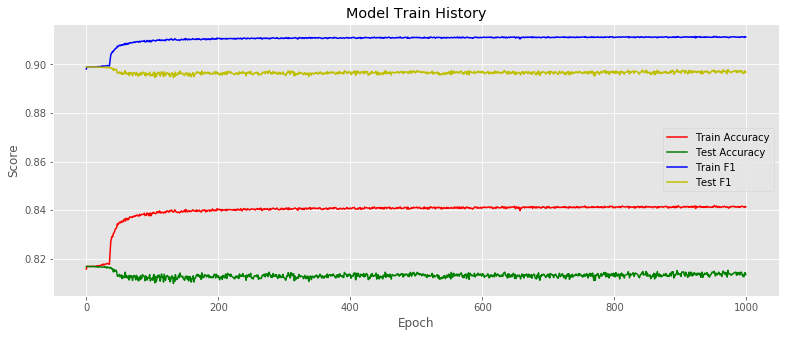

CLASSIFIER PERFORMANCE REFRIGERATOR MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,refrigerator,81.34,81.67,99.49,89.7,45.3,0.19,0.5,1970,8782



CONFUSION MATRIX (OFF/ON):

 - refrigerator:
[[   9 1961]
 [  45 8737]]


---> Splitting `{}` data (train/test)...
---> Training the `dishwasher` model...

Train on 32253 samples, validate on 10752 samples
Epoch 1/1000
32253/32253 - 27s - loss: 0.4280 - accuracy: 0.8721 - f1: 0.9299 - val_loss: 0.4428 - val_accuracy: 0.8762 - val_f1: 0.9339
Epoch 2/1000
32253/32253 - 21s - loss: 0.3798 - accuracy: 0.8762 - f1: 0.9339 - val_loss: 0.4255 - val_accuracy: 0.8762 - val_f1: 0.9339
Epoch 3/1000
32253/32253 - 21s - loss: 0.3789 - accuracy: 0.8762 - f1: 0.9339 - val_loss: 0.4233 - val_accuracy: 0.8762 - val_f1: 0.9339
Epoch 4/1000
32253/32253 - 20s - loss: 0.3789 - accuracy: 0.8762 - f1: 0.9339 - val_loss: 0.4016 - val_accuracy: 0.8762 - val_f1: 0.9339
Epoch 5/1000
32253/32253 - 20s - loss: 0.3777 - accuracy: 0.8762 - f1: 0.9339 - val_loss: 0.4079 - val_accuracy: 0.8762 - val_f1: 0.9339
Epoch 6/1000
32253/32253 - 20s - loss: 0.3781 - accuracy: 0.8762 - f1: 0.9339 - val_loss: 0.4040 - val_accur

Epoch 59/1000
32253/32253 - 20s - loss: 0.2686 - accuracy: 0.9160 - f1: 0.9539 - val_loss: 0.5871 - val_accuracy: 0.8658 - val_f1: 0.9276
Epoch 60/1000
32253/32253 - 20s - loss: 0.2673 - accuracy: 0.9159 - f1: 0.9539 - val_loss: 0.6341 - val_accuracy: 0.8681 - val_f1: 0.9291
Epoch 61/1000
32253/32253 - 20s - loss: 0.2680 - accuracy: 0.9156 - f1: 0.9538 - val_loss: 0.6099 - val_accuracy: 0.8680 - val_f1: 0.9290
Epoch 62/1000
32253/32253 - 20s - loss: 0.2683 - accuracy: 0.9160 - f1: 0.9539 - val_loss: 0.6054 - val_accuracy: 0.8667 - val_f1: 0.9283
Epoch 63/1000
32253/32253 - 20s - loss: 0.2653 - accuracy: 0.9165 - f1: 0.9542 - val_loss: 0.6029 - val_accuracy: 0.8658 - val_f1: 0.9276
Epoch 64/1000
32253/32253 - 20s - loss: 0.2646 - accuracy: 0.9176 - f1: 0.9548 - val_loss: 0.6105 - val_accuracy: 0.8665 - val_f1: 0.9281
Epoch 65/1000
32253/32253 - 20s - loss: 0.2643 - accuracy: 0.9167 - f1: 0.9543 - val_loss: 0.6347 - val_accuracy: 0.8665 - val_f1: 0.9281
Epoch 66/1000
32253/32253 - 20s - 

Epoch 119/1000
32253/32253 - 20s - loss: 0.2547 - accuracy: 0.9207 - f1: 0.9564 - val_loss: 0.8203 - val_accuracy: 0.8681 - val_f1: 0.9291
Epoch 120/1000
32253/32253 - 20s - loss: 0.2552 - accuracy: 0.9207 - f1: 0.9564 - val_loss: 0.8018 - val_accuracy: 0.8668 - val_f1: 0.9283
Epoch 121/1000
32253/32253 - 20s - loss: 0.2550 - accuracy: 0.9207 - f1: 0.9564 - val_loss: 0.7613 - val_accuracy: 0.8633 - val_f1: 0.9262
Epoch 122/1000
32253/32253 - 20s - loss: 0.2535 - accuracy: 0.9207 - f1: 0.9565 - val_loss: 0.8360 - val_accuracy: 0.8671 - val_f1: 0.9285
Epoch 123/1000
32253/32253 - 20s - loss: 0.2538 - accuracy: 0.9212 - f1: 0.9567 - val_loss: 0.8082 - val_accuracy: 0.8670 - val_f1: 0.9284
Epoch 124/1000
32253/32253 - 20s - loss: 0.2536 - accuracy: 0.9214 - f1: 0.9568 - val_loss: 0.8375 - val_accuracy: 0.8683 - val_f1: 0.9291
Epoch 125/1000
32253/32253 - 20s - loss: 0.2551 - accuracy: 0.9212 - f1: 0.9568 - val_loss: 0.8007 - val_accuracy: 0.8659 - val_f1: 0.9277
Epoch 126/1000
32253/32253 

Epoch 178/1000
32253/32253 - 20s - loss: 0.2496 - accuracy: 0.9226 - f1: 0.9575 - val_loss: 0.8891 - val_accuracy: 0.8661 - val_f1: 0.9279
Epoch 179/1000
32253/32253 - 20s - loss: 0.2478 - accuracy: 0.9232 - f1: 0.9578 - val_loss: 0.8933 - val_accuracy: 0.8660 - val_f1: 0.9278
Epoch 180/1000
32253/32253 - 20s - loss: 0.2497 - accuracy: 0.9217 - f1: 0.9570 - val_loss: 0.9076 - val_accuracy: 0.8696 - val_f1: 0.9299
Epoch 181/1000
32253/32253 - 20s - loss: 0.2500 - accuracy: 0.9226 - f1: 0.9575 - val_loss: 0.8430 - val_accuracy: 0.8671 - val_f1: 0.9284
Epoch 182/1000
32253/32253 - 20s - loss: 0.2503 - accuracy: 0.9215 - f1: 0.9568 - val_loss: 0.8267 - val_accuracy: 0.8662 - val_f1: 0.9279
Epoch 183/1000
32253/32253 - 20s - loss: 0.2502 - accuracy: 0.9218 - f1: 0.9570 - val_loss: 0.8946 - val_accuracy: 0.8688 - val_f1: 0.9294
Epoch 184/1000
32253/32253 - 20s - loss: 0.2492 - accuracy: 0.9226 - f1: 0.9575 - val_loss: 0.8871 - val_accuracy: 0.8681 - val_f1: 0.9290
Epoch 185/1000
32253/32253 

Epoch 237/1000
32253/32253 - 20s - loss: 0.2479 - accuracy: 0.9233 - f1: 0.9579 - val_loss: 0.9134 - val_accuracy: 0.8673 - val_f1: 0.9285
Epoch 238/1000
32253/32253 - 20s - loss: 0.2478 - accuracy: 0.9230 - f1: 0.9577 - val_loss: 0.9014 - val_accuracy: 0.8660 - val_f1: 0.9277
Epoch 239/1000
32253/32253 - 20s - loss: 0.2476 - accuracy: 0.9230 - f1: 0.9577 - val_loss: 0.9520 - val_accuracy: 0.8699 - val_f1: 0.9301
Epoch 240/1000
32253/32253 - 20s - loss: 0.2471 - accuracy: 0.9227 - f1: 0.9575 - val_loss: 0.9547 - val_accuracy: 0.8674 - val_f1: 0.9286
Epoch 241/1000
32253/32253 - 20s - loss: 0.2479 - accuracy: 0.9232 - f1: 0.9578 - val_loss: 0.9550 - val_accuracy: 0.8680 - val_f1: 0.9290
Epoch 242/1000
32253/32253 - 20s - loss: 0.2483 - accuracy: 0.9227 - f1: 0.9576 - val_loss: 0.9774 - val_accuracy: 0.8700 - val_f1: 0.9301
Epoch 243/1000
32253/32253 - 20s - loss: 0.2467 - accuracy: 0.9234 - f1: 0.9579 - val_loss: 0.9242 - val_accuracy: 0.8665 - val_f1: 0.9280
Epoch 244/1000
32253/32253 

Epoch 296/1000
32253/32253 - 20s - loss: 0.2467 - accuracy: 0.9243 - f1: 0.9584 - val_loss: 0.9986 - val_accuracy: 0.8686 - val_f1: 0.9293
Epoch 297/1000
32253/32253 - 20s - loss: 0.2477 - accuracy: 0.9232 - f1: 0.9578 - val_loss: 0.9946 - val_accuracy: 0.8688 - val_f1: 0.9294
Epoch 298/1000
32253/32253 - 20s - loss: 0.2495 - accuracy: 0.9235 - f1: 0.9580 - val_loss: 0.9738 - val_accuracy: 0.8683 - val_f1: 0.9291
Epoch 299/1000
32253/32253 - 20s - loss: 0.2473 - accuracy: 0.9237 - f1: 0.9581 - val_loss: 0.9269 - val_accuracy: 0.8689 - val_f1: 0.9294
Epoch 300/1000
32253/32253 - 20s - loss: 0.2471 - accuracy: 0.9239 - f1: 0.9582 - val_loss: 1.0206 - val_accuracy: 0.8704 - val_f1: 0.9304
Epoch 301/1000
32253/32253 - 20s - loss: 0.2475 - accuracy: 0.9239 - f1: 0.9582 - val_loss: 1.0022 - val_accuracy: 0.8707 - val_f1: 0.9305
Epoch 302/1000
32253/32253 - 20s - loss: 0.2468 - accuracy: 0.9240 - f1: 0.9583 - val_loss: 1.0493 - val_accuracy: 0.8698 - val_f1: 0.9300
Epoch 303/1000
32253/32253 

Epoch 355/1000
32253/32253 - 20s - loss: 0.2449 - accuracy: 0.9242 - f1: 0.9584 - val_loss: 1.0105 - val_accuracy: 0.8671 - val_f1: 0.9284
Epoch 356/1000
32253/32253 - 20s - loss: 0.2448 - accuracy: 0.9247 - f1: 0.9586 - val_loss: 1.0247 - val_accuracy: 0.8691 - val_f1: 0.9296
Epoch 357/1000
32253/32253 - 20s - loss: 0.2439 - accuracy: 0.9246 - f1: 0.9586 - val_loss: 1.0362 - val_accuracy: 0.8700 - val_f1: 0.9301
Epoch 358/1000
32253/32253 - 20s - loss: 0.2459 - accuracy: 0.9240 - f1: 0.9583 - val_loss: 1.0812 - val_accuracy: 0.8700 - val_f1: 0.9301
Epoch 359/1000
32253/32253 - 20s - loss: 0.2470 - accuracy: 0.9239 - f1: 0.9582 - val_loss: 1.0101 - val_accuracy: 0.8680 - val_f1: 0.9289
Epoch 360/1000
32253/32253 - 20s - loss: 0.2473 - accuracy: 0.9237 - f1: 0.9581 - val_loss: 1.0076 - val_accuracy: 0.8678 - val_f1: 0.9289
Epoch 361/1000
32253/32253 - 20s - loss: 0.2455 - accuracy: 0.9240 - f1: 0.9582 - val_loss: 1.0437 - val_accuracy: 0.8673 - val_f1: 0.9285
Epoch 362/1000
32253/32253 

Epoch 414/1000
32253/32253 - 20s - loss: 0.2463 - accuracy: 0.9243 - f1: 0.9584 - val_loss: 1.0786 - val_accuracy: 0.8686 - val_f1: 0.9293
Epoch 415/1000
32253/32253 - 20s - loss: 0.2446 - accuracy: 0.9244 - f1: 0.9585 - val_loss: 1.0233 - val_accuracy: 0.8664 - val_f1: 0.9280
Epoch 416/1000
32253/32253 - 20s - loss: 0.2438 - accuracy: 0.9244 - f1: 0.9585 - val_loss: 1.0836 - val_accuracy: 0.8678 - val_f1: 0.9289
Epoch 417/1000
32253/32253 - 20s - loss: 0.2446 - accuracy: 0.9245 - f1: 0.9586 - val_loss: 1.1275 - val_accuracy: 0.8702 - val_f1: 0.9302
Epoch 418/1000
32253/32253 - 20s - loss: 0.2457 - accuracy: 0.9244 - f1: 0.9585 - val_loss: 1.1342 - val_accuracy: 0.8712 - val_f1: 0.9308
Epoch 419/1000
32253/32253 - 20s - loss: 0.2439 - accuracy: 0.9249 - f1: 0.9588 - val_loss: 1.0893 - val_accuracy: 0.8692 - val_f1: 0.9296
Epoch 420/1000
32253/32253 - 20s - loss: 0.2453 - accuracy: 0.9241 - f1: 0.9583 - val_loss: 1.0647 - val_accuracy: 0.8694 - val_f1: 0.9298
Epoch 421/1000
32253/32253 

Epoch 473/1000
32253/32253 - 20s - loss: 0.2439 - accuracy: 0.9246 - f1: 0.9585 - val_loss: 1.1237 - val_accuracy: 0.8686 - val_f1: 0.9293
Epoch 474/1000
32253/32253 - 20s - loss: 0.2452 - accuracy: 0.9248 - f1: 0.9587 - val_loss: 1.1401 - val_accuracy: 0.8682 - val_f1: 0.9291
Epoch 475/1000
32253/32253 - 20s - loss: 0.2440 - accuracy: 0.9248 - f1: 0.9587 - val_loss: 1.1099 - val_accuracy: 0.8687 - val_f1: 0.9293
Epoch 476/1000
32253/32253 - 20s - loss: 0.2454 - accuracy: 0.9247 - f1: 0.9586 - val_loss: 1.0421 - val_accuracy: 0.8689 - val_f1: 0.9294
Epoch 477/1000
32253/32253 - 20s - loss: 0.2443 - accuracy: 0.9245 - f1: 0.9585 - val_loss: 1.1028 - val_accuracy: 0.8677 - val_f1: 0.9288
Epoch 478/1000
32253/32253 - 20s - loss: 0.2454 - accuracy: 0.9246 - f1: 0.9586 - val_loss: 1.0757 - val_accuracy: 0.8680 - val_f1: 0.9289
Epoch 479/1000
32253/32253 - 20s - loss: 0.2439 - accuracy: 0.9252 - f1: 0.9589 - val_loss: 1.1050 - val_accuracy: 0.8687 - val_f1: 0.9294
Epoch 480/1000
32253/32253 

Epoch 532/1000
32253/32253 - 20s - loss: 0.2434 - accuracy: 0.9249 - f1: 0.9588 - val_loss: 1.1305 - val_accuracy: 0.8690 - val_f1: 0.9295
Epoch 533/1000
32253/32253 - 20s - loss: 0.2453 - accuracy: 0.9247 - f1: 0.9586 - val_loss: 1.1053 - val_accuracy: 0.8682 - val_f1: 0.9291
Epoch 534/1000
32253/32253 - 20s - loss: 0.2451 - accuracy: 0.9243 - f1: 0.9585 - val_loss: 1.2117 - val_accuracy: 0.8702 - val_f1: 0.9302
Epoch 535/1000
32253/32253 - 20s - loss: 0.2441 - accuracy: 0.9250 - f1: 0.9588 - val_loss: 1.1999 - val_accuracy: 0.8694 - val_f1: 0.9298
Epoch 536/1000
32253/32253 - 20s - loss: 0.2436 - accuracy: 0.9248 - f1: 0.9587 - val_loss: 1.0784 - val_accuracy: 0.8668 - val_f1: 0.9282
Epoch 537/1000
32253/32253 - 20s - loss: 0.2449 - accuracy: 0.9248 - f1: 0.9587 - val_loss: 1.1415 - val_accuracy: 0.8685 - val_f1: 0.9293
Epoch 538/1000
32253/32253 - 20s - loss: 0.2433 - accuracy: 0.9252 - f1: 0.9589 - val_loss: 1.1250 - val_accuracy: 0.8673 - val_f1: 0.9286
Epoch 539/1000
32253/32253 

Epoch 591/1000
32253/32253 - 20s - loss: 0.2448 - accuracy: 0.9247 - f1: 0.9586 - val_loss: 1.0741 - val_accuracy: 0.8696 - val_f1: 0.9299
Epoch 592/1000
32253/32253 - 20s - loss: 0.2434 - accuracy: 0.9251 - f1: 0.9588 - val_loss: 1.1237 - val_accuracy: 0.8690 - val_f1: 0.9296
Epoch 593/1000
32253/32253 - 20s - loss: 0.2434 - accuracy: 0.9251 - f1: 0.9589 - val_loss: 1.1057 - val_accuracy: 0.8672 - val_f1: 0.9285
Epoch 594/1000
32253/32253 - 20s - loss: 0.2421 - accuracy: 0.9254 - f1: 0.9590 - val_loss: 1.0537 - val_accuracy: 0.8679 - val_f1: 0.9289
Epoch 595/1000
32253/32253 - 20s - loss: 0.2428 - accuracy: 0.9252 - f1: 0.9589 - val_loss: 1.1002 - val_accuracy: 0.8674 - val_f1: 0.9287
Epoch 596/1000
32253/32253 - 20s - loss: 0.2433 - accuracy: 0.9253 - f1: 0.9590 - val_loss: 1.0993 - val_accuracy: 0.8687 - val_f1: 0.9294
Epoch 597/1000
32253/32253 - 20s - loss: 0.2445 - accuracy: 0.9250 - f1: 0.9588 - val_loss: 1.1416 - val_accuracy: 0.8680 - val_f1: 0.9290
Epoch 598/1000
32253/32253 

Epoch 650/1000
32253/32253 - 20s - loss: 0.2424 - accuracy: 0.9248 - f1: 0.9587 - val_loss: 1.2353 - val_accuracy: 0.8699 - val_f1: 0.9301
Epoch 651/1000
32253/32253 - 20s - loss: 0.2431 - accuracy: 0.9252 - f1: 0.9590 - val_loss: 1.1614 - val_accuracy: 0.8690 - val_f1: 0.9295
Epoch 652/1000
32253/32253 - 20s - loss: 0.2426 - accuracy: 0.9248 - f1: 0.9587 - val_loss: 1.0996 - val_accuracy: 0.8666 - val_f1: 0.9282
Epoch 653/1000
32253/32253 - 20s - loss: 0.2434 - accuracy: 0.9252 - f1: 0.9589 - val_loss: 1.1218 - val_accuracy: 0.8664 - val_f1: 0.9281
Epoch 654/1000
32253/32253 - 20s - loss: 0.2414 - accuracy: 0.9256 - f1: 0.9592 - val_loss: 1.1438 - val_accuracy: 0.8688 - val_f1: 0.9294
Epoch 655/1000
32253/32253 - 20s - loss: 0.2423 - accuracy: 0.9253 - f1: 0.9589 - val_loss: 1.1029 - val_accuracy: 0.8673 - val_f1: 0.9286
Epoch 656/1000
32253/32253 - 20s - loss: 0.2433 - accuracy: 0.9248 - f1: 0.9587 - val_loss: 1.1087 - val_accuracy: 0.8685 - val_f1: 0.9292
Epoch 657/1000
32253/32253 

Epoch 709/1000
32253/32253 - 20s - loss: 0.2448 - accuracy: 0.9251 - f1: 0.9589 - val_loss: 1.1329 - val_accuracy: 0.8673 - val_f1: 0.9285
Epoch 710/1000
32253/32253 - 20s - loss: 0.2426 - accuracy: 0.9254 - f1: 0.9591 - val_loss: 1.1699 - val_accuracy: 0.8676 - val_f1: 0.9287
Epoch 711/1000
32253/32253 - 20s - loss: 0.2429 - accuracy: 0.9254 - f1: 0.9590 - val_loss: 1.2541 - val_accuracy: 0.8690 - val_f1: 0.9296
Epoch 712/1000
32253/32253 - 20s - loss: 0.2433 - accuracy: 0.9249 - f1: 0.9587 - val_loss: 1.1577 - val_accuracy: 0.8692 - val_f1: 0.9297
Epoch 713/1000
32253/32253 - 20s - loss: 0.2412 - accuracy: 0.9255 - f1: 0.9591 - val_loss: 1.1920 - val_accuracy: 0.8698 - val_f1: 0.9300
Epoch 714/1000
32253/32253 - 20s - loss: 0.2449 - accuracy: 0.9251 - f1: 0.9589 - val_loss: 1.2231 - val_accuracy: 0.8691 - val_f1: 0.9296
Epoch 715/1000
32253/32253 - 20s - loss: 0.2435 - accuracy: 0.9249 - f1: 0.9587 - val_loss: 1.1791 - val_accuracy: 0.8682 - val_f1: 0.9291
Epoch 716/1000
32253/32253 

Epoch 768/1000
32253/32253 - 21s - loss: 0.2418 - accuracy: 0.9254 - f1: 0.9590 - val_loss: 1.2489 - val_accuracy: 0.8683 - val_f1: 0.9291
Epoch 769/1000
32253/32253 - 21s - loss: 0.2413 - accuracy: 0.9256 - f1: 0.9592 - val_loss: 1.2736 - val_accuracy: 0.8691 - val_f1: 0.9296
Epoch 770/1000
32253/32253 - 20s - loss: 0.2418 - accuracy: 0.9253 - f1: 0.9590 - val_loss: 1.1325 - val_accuracy: 0.8671 - val_f1: 0.9284
Epoch 771/1000
32253/32253 - 20s - loss: 0.2428 - accuracy: 0.9249 - f1: 0.9587 - val_loss: 1.2098 - val_accuracy: 0.8696 - val_f1: 0.9299
Epoch 772/1000
32253/32253 - 20s - loss: 0.2421 - accuracy: 0.9249 - f1: 0.9588 - val_loss: 1.2033 - val_accuracy: 0.8684 - val_f1: 0.9292
Epoch 773/1000
32253/32253 - 20s - loss: 0.2429 - accuracy: 0.9255 - f1: 0.9591 - val_loss: 1.1704 - val_accuracy: 0.8683 - val_f1: 0.9291
Epoch 774/1000
32253/32253 - 20s - loss: 0.2445 - accuracy: 0.9244 - f1: 0.9585 - val_loss: 1.1610 - val_accuracy: 0.8690 - val_f1: 0.9295
Epoch 775/1000
32253/32253 

Epoch 827/1000
32253/32253 - 20s - loss: 0.2408 - accuracy: 0.9254 - f1: 0.9590 - val_loss: 1.2910 - val_accuracy: 0.8685 - val_f1: 0.9293
Epoch 828/1000
32253/32253 - 20s - loss: 0.2417 - accuracy: 0.9250 - f1: 0.9589 - val_loss: 1.2745 - val_accuracy: 0.8693 - val_f1: 0.9298
Epoch 829/1000
32253/32253 - 20s - loss: 0.2423 - accuracy: 0.9253 - f1: 0.9590 - val_loss: 1.2300 - val_accuracy: 0.8690 - val_f1: 0.9296
Epoch 830/1000
32253/32253 - 20s - loss: 0.2416 - accuracy: 0.9256 - f1: 0.9591 - val_loss: 1.2615 - val_accuracy: 0.8686 - val_f1: 0.9293
Epoch 831/1000
32253/32253 - 20s - loss: 0.2430 - accuracy: 0.9248 - f1: 0.9587 - val_loss: 1.1729 - val_accuracy: 0.8675 - val_f1: 0.9287
Epoch 832/1000
32253/32253 - 20s - loss: 0.2416 - accuracy: 0.9255 - f1: 0.9591 - val_loss: 1.2459 - val_accuracy: 0.8694 - val_f1: 0.9298
Epoch 833/1000
32253/32253 - 20s - loss: 0.2416 - accuracy: 0.9254 - f1: 0.9590 - val_loss: 1.3014 - val_accuracy: 0.8697 - val_f1: 0.9300
Epoch 834/1000
32253/32253 

Epoch 886/1000
32253/32253 - 20s - loss: 0.2425 - accuracy: 0.9254 - f1: 0.9590 - val_loss: 1.2775 - val_accuracy: 0.8693 - val_f1: 0.9297
Epoch 887/1000
32253/32253 - 20s - loss: 0.2415 - accuracy: 0.9256 - f1: 0.9592 - val_loss: 1.2903 - val_accuracy: 0.8692 - val_f1: 0.9297
Epoch 888/1000
32253/32253 - 20s - loss: 0.2416 - accuracy: 0.9253 - f1: 0.9590 - val_loss: 1.1538 - val_accuracy: 0.8663 - val_f1: 0.9280
Epoch 889/1000
32253/32253 - 20s - loss: 0.2426 - accuracy: 0.9252 - f1: 0.9590 - val_loss: 1.1934 - val_accuracy: 0.8699 - val_f1: 0.9300
Epoch 890/1000
32253/32253 - 20s - loss: 0.2412 - accuracy: 0.9254 - f1: 0.9590 - val_loss: 1.2363 - val_accuracy: 0.8684 - val_f1: 0.9292
Epoch 891/1000
32253/32253 - 20s - loss: 0.2411 - accuracy: 0.9259 - f1: 0.9593 - val_loss: 1.2939 - val_accuracy: 0.8688 - val_f1: 0.9295
Epoch 892/1000
32253/32253 - 20s - loss: 0.2409 - accuracy: 0.9254 - f1: 0.9590 - val_loss: 1.2628 - val_accuracy: 0.8692 - val_f1: 0.9297
Epoch 893/1000
32253/32253 

Epoch 945/1000
32253/32253 - 20s - loss: 0.2415 - accuracy: 0.9256 - f1: 0.9591 - val_loss: 1.2863 - val_accuracy: 0.8686 - val_f1: 0.9293
Epoch 946/1000
32253/32253 - 20s - loss: 0.2418 - accuracy: 0.9258 - f1: 0.9592 - val_loss: 1.2468 - val_accuracy: 0.8667 - val_f1: 0.9282
Epoch 947/1000
32253/32253 - 20s - loss: 0.2413 - accuracy: 0.9257 - f1: 0.9592 - val_loss: 1.2846 - val_accuracy: 0.8678 - val_f1: 0.9289
Epoch 948/1000
32253/32253 - 20s - loss: 0.2410 - accuracy: 0.9255 - f1: 0.9591 - val_loss: 1.2617 - val_accuracy: 0.8691 - val_f1: 0.9296
Epoch 949/1000
32253/32253 - 20s - loss: 0.2427 - accuracy: 0.9251 - f1: 0.9589 - val_loss: 1.2359 - val_accuracy: 0.8675 - val_f1: 0.9287
Epoch 950/1000
32253/32253 - 20s - loss: 0.2426 - accuracy: 0.9249 - f1: 0.9588 - val_loss: 1.1403 - val_accuracy: 0.8686 - val_f1: 0.9293
Epoch 951/1000
32253/32253 - 20s - loss: 0.2423 - accuracy: 0.9251 - f1: 0.9588 - val_loss: 1.2046 - val_accuracy: 0.8694 - val_f1: 0.9297
Epoch 952/1000
32253/32253 

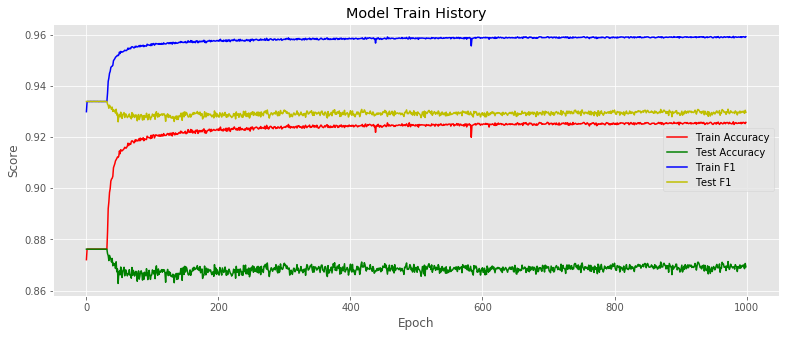

CLASSIFIER PERFORMANCE DISHWASHER MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,dishwasher,86.93,87.83,98.77,92.98,49.31,0.13,0.51,1331,9421



CONFUSION MATRIX (OFF/ON):

 - dishwasher:
[[  42 1289]
 [ 116 9305]]


---> Splitting `{}` data (train/test)...
---> Training the `washer dryer 1` model...

Train on 32253 samples, validate on 10752 samples
Epoch 1/1000
32253/32253 - 21s - loss: 0.0956 - accuracy: 0.9794 - f1: 0.0053 - val_loss: 0.1132 - val_accuracy: 0.9808 - val_f1: 0.0000e+00
Epoch 2/1000
32253/32253 - 20s - loss: 0.0615 - accuracy: 0.9808 - f1: 0.0049 - val_loss: 0.0796 - val_accuracy: 0.9808 - val_f1: 0.0000e+00
Epoch 3/1000
32253/32253 - 20s - loss: 0.0588 - accuracy: 0.9808 - f1: 0.0109 - val_loss: 0.0582 - val_accuracy: 0.9808 - val_f1: 0.0000e+00
Epoch 4/1000
32253/32253 - 20s - loss: 0.0580 - accuracy: 0.9809 - f1: 0.0264 - val_loss: 0.0801 - val_accuracy: 0.9815 - val_f1: 0.0769
Epoch 5/1000
32253/32253 - 20s - loss: 0.0548 - accuracy: 0.9809 - f1: 0.0483 - val_loss: 0.0669 - val_accuracy: 0.9811 - val_f1: 0.0653
Epoch 6/1000
32253/32253 - 20s - loss: 0.0555 - accuracy: 0.9809 - f1: 0.0546 - val_loss: 0.06

Epoch 59/1000
32253/32253 - 20s - loss: 0.0098 - accuracy: 0.9963 - f1: 0.8774 - val_loss: 0.1503 - val_accuracy: 0.9837 - val_f1: 0.4670
Epoch 60/1000
32253/32253 - 20s - loss: 0.0111 - accuracy: 0.9960 - f1: 0.8900 - val_loss: 0.1544 - val_accuracy: 0.9846 - val_f1: 0.4763
Epoch 61/1000
32253/32253 - 20s - loss: 0.0106 - accuracy: 0.9962 - f1: 0.8828 - val_loss: 0.1452 - val_accuracy: 0.9824 - val_f1: 0.4965
Epoch 62/1000
32253/32253 - 20s - loss: 0.0105 - accuracy: 0.9962 - f1: 0.8776 - val_loss: 0.1516 - val_accuracy: 0.9834 - val_f1: 0.4344
Epoch 63/1000
32253/32253 - 20s - loss: 0.0101 - accuracy: 0.9964 - f1: 0.8972 - val_loss: 0.1535 - val_accuracy: 0.9834 - val_f1: 0.4156
Epoch 64/1000
32253/32253 - 20s - loss: 0.0091 - accuracy: 0.9969 - f1: 0.9059 - val_loss: 0.1465 - val_accuracy: 0.9834 - val_f1: 0.4500
Epoch 65/1000
32253/32253 - 20s - loss: 0.0100 - accuracy: 0.9962 - f1: 0.8841 - val_loss: 0.1546 - val_accuracy: 0.9827 - val_f1: 0.4494
Epoch 66/1000
32253/32253 - 20s - 

Epoch 119/1000
32253/32253 - 20s - loss: 0.0054 - accuracy: 0.9984 - f1: 0.9569 - val_loss: 0.1931 - val_accuracy: 0.9834 - val_f1: 0.4487
Epoch 120/1000
32253/32253 - 20s - loss: 0.0056 - accuracy: 0.9984 - f1: 0.9458 - val_loss: 0.1974 - val_accuracy: 0.9842 - val_f1: 0.4802
Epoch 121/1000
32253/32253 - 20s - loss: 0.0058 - accuracy: 0.9985 - f1: 0.9386 - val_loss: 0.1830 - val_accuracy: 0.9841 - val_f1: 0.5006
Epoch 122/1000
32253/32253 - 20s - loss: 0.0060 - accuracy: 0.9983 - f1: 0.9340 - val_loss: 0.2110 - val_accuracy: 0.9848 - val_f1: 0.4881
Epoch 123/1000
32253/32253 - 20s - loss: 0.0052 - accuracy: 0.9983 - f1: 0.9343 - val_loss: 0.2370 - val_accuracy: 0.9845 - val_f1: 0.4796
Epoch 124/1000
32253/32253 - 20s - loss: 0.0050 - accuracy: 0.9985 - f1: 0.9502 - val_loss: 0.1924 - val_accuracy: 0.9832 - val_f1: 0.4528
Epoch 125/1000
32253/32253 - 20s - loss: 0.0054 - accuracy: 0.9983 - f1: 0.9405 - val_loss: 0.2425 - val_accuracy: 0.9834 - val_f1: 0.4403
Epoch 126/1000
32253/32253 

Epoch 178/1000
32253/32253 - 20s - loss: 0.0046 - accuracy: 0.9987 - f1: 0.9681 - val_loss: 0.2250 - val_accuracy: 0.9843 - val_f1: 0.4827
Epoch 179/1000
32253/32253 - 20s - loss: 0.0043 - accuracy: 0.9987 - f1: 0.9527 - val_loss: 0.2703 - val_accuracy: 0.9841 - val_f1: 0.4369
Epoch 180/1000
32253/32253 - 20s - loss: 0.0041 - accuracy: 0.9988 - f1: 0.9572 - val_loss: 0.2562 - val_accuracy: 0.9849 - val_f1: 0.4837
Epoch 181/1000
32253/32253 - 20s - loss: 0.0041 - accuracy: 0.9989 - f1: 0.9488 - val_loss: 0.2897 - val_accuracy: 0.9848 - val_f1: 0.4521
Epoch 182/1000
32253/32253 - 20s - loss: 0.0039 - accuracy: 0.9990 - f1: 0.9592 - val_loss: 0.2690 - val_accuracy: 0.9846 - val_f1: 0.4785
Epoch 183/1000
32253/32253 - 20s - loss: 0.0041 - accuracy: 0.9990 - f1: 0.9627 - val_loss: 0.2809 - val_accuracy: 0.9847 - val_f1: 0.4768
Epoch 184/1000
32253/32253 - 20s - loss: 0.0046 - accuracy: 0.9985 - f1: 0.9517 - val_loss: 0.2541 - val_accuracy: 0.9840 - val_f1: 0.4482
Epoch 185/1000
32253/32253 

Epoch 237/1000
32253/32253 - 20s - loss: 0.0030 - accuracy: 0.9993 - f1: 0.9714 - val_loss: 0.2879 - val_accuracy: 0.9856 - val_f1: 0.5026
Epoch 238/1000
32253/32253 - 20s - loss: 0.0042 - accuracy: 0.9989 - f1: 0.9631 - val_loss: 0.2870 - val_accuracy: 0.9851 - val_f1: 0.4798
Epoch 239/1000
32253/32253 - 20s - loss: 0.0034 - accuracy: 0.9993 - f1: 0.9726 - val_loss: 0.2818 - val_accuracy: 0.9842 - val_f1: 0.4413
Epoch 240/1000
32253/32253 - 20s - loss: 0.0035 - accuracy: 0.9991 - f1: 0.9723 - val_loss: 0.2695 - val_accuracy: 0.9837 - val_f1: 0.4250
Epoch 241/1000
32253/32253 - 20s - loss: 0.0035 - accuracy: 0.9991 - f1: 0.9723 - val_loss: 0.2958 - val_accuracy: 0.9850 - val_f1: 0.4667
Epoch 242/1000
32253/32253 - 20s - loss: 0.0037 - accuracy: 0.9993 - f1: 0.9808 - val_loss: 0.2890 - val_accuracy: 0.9853 - val_f1: 0.4754
Epoch 243/1000
32253/32253 - 20s - loss: 0.0036 - accuracy: 0.9992 - f1: 0.9709 - val_loss: 0.2749 - val_accuracy: 0.9840 - val_f1: 0.4283
Epoch 244/1000
32253/32253 

Epoch 296/1000
32253/32253 - 20s - loss: 0.0034 - accuracy: 0.9991 - f1: 0.9758 - val_loss: 0.3168 - val_accuracy: 0.9841 - val_f1: 0.4382
Epoch 297/1000
32253/32253 - 20s - loss: 0.0033 - accuracy: 0.9992 - f1: 0.9737 - val_loss: 0.3425 - val_accuracy: 0.9843 - val_f1: 0.4374
Epoch 298/1000
32253/32253 - 20s - loss: 0.0034 - accuracy: 0.9991 - f1: 0.9671 - val_loss: 0.2811 - val_accuracy: 0.9840 - val_f1: 0.4641
Epoch 299/1000
32253/32253 - 20s - loss: 0.0033 - accuracy: 0.9994 - f1: 0.9793 - val_loss: 0.3103 - val_accuracy: 0.9845 - val_f1: 0.4569
Epoch 300/1000
32253/32253 - 20s - loss: 0.0038 - accuracy: 0.9991 - f1: 0.9650 - val_loss: 0.2928 - val_accuracy: 0.9840 - val_f1: 0.4427
Epoch 301/1000
32253/32253 - 20s - loss: 0.0033 - accuracy: 0.9993 - f1: 0.9741 - val_loss: 0.3209 - val_accuracy: 0.9847 - val_f1: 0.4697
Epoch 302/1000
32253/32253 - 20s - loss: 0.0032 - accuracy: 0.9992 - f1: 0.9751 - val_loss: 0.3520 - val_accuracy: 0.9843 - val_f1: 0.4227
Epoch 303/1000
32253/32253 

Epoch 355/1000
32253/32253 - 20s - loss: 0.0031 - accuracy: 0.9993 - f1: 0.9800 - val_loss: 0.3402 - val_accuracy: 0.9841 - val_f1: 0.4277
Epoch 356/1000
32253/32253 - 20s - loss: 0.0028 - accuracy: 0.9993 - f1: 0.9837 - val_loss: 0.3190 - val_accuracy: 0.9844 - val_f1: 0.4782
Epoch 357/1000
32253/32253 - 20s - loss: 0.0033 - accuracy: 0.9992 - f1: 0.9663 - val_loss: 0.3121 - val_accuracy: 0.9842 - val_f1: 0.4553
Epoch 358/1000
32253/32253 - 20s - loss: 0.0034 - accuracy: 0.9992 - f1: 0.9714 - val_loss: 0.3627 - val_accuracy: 0.9844 - val_f1: 0.4329
Epoch 359/1000
32253/32253 - 20s - loss: 0.0035 - accuracy: 0.9992 - f1: 0.9774 - val_loss: 0.2655 - val_accuracy: 0.9841 - val_f1: 0.4633
Epoch 360/1000
32253/32253 - 20s - loss: 0.0029 - accuracy: 0.9992 - f1: 0.9748 - val_loss: 0.3055 - val_accuracy: 0.9838 - val_f1: 0.4392
Epoch 361/1000
32253/32253 - 20s - loss: 0.0027 - accuracy: 0.9996 - f1: 0.9813 - val_loss: 0.3082 - val_accuracy: 0.9845 - val_f1: 0.4249
Epoch 362/1000
32253/32253 

Epoch 414/1000
32253/32253 - 20s - loss: 0.0032 - accuracy: 0.9993 - f1: 0.9768 - val_loss: 0.3610 - val_accuracy: 0.9846 - val_f1: 0.4390
Epoch 415/1000
32253/32253 - 20s - loss: 0.0031 - accuracy: 0.9991 - f1: 0.9776 - val_loss: 0.3392 - val_accuracy: 0.9839 - val_f1: 0.4383
Epoch 416/1000
32253/32253 - 20s - loss: 0.0023 - accuracy: 0.9995 - f1: 0.9731 - val_loss: 0.3430 - val_accuracy: 0.9841 - val_f1: 0.4321
Epoch 417/1000
32253/32253 - 20s - loss: 0.0029 - accuracy: 0.9993 - f1: 0.9571 - val_loss: 0.3830 - val_accuracy: 0.9834 - val_f1: 0.3844
Epoch 418/1000
32253/32253 - 20s - loss: 0.0033 - accuracy: 0.9993 - f1: 0.9720 - val_loss: 0.3099 - val_accuracy: 0.9845 - val_f1: 0.4720
Epoch 419/1000
32253/32253 - 20s - loss: 0.0027 - accuracy: 0.9994 - f1: 0.9756 - val_loss: 0.3689 - val_accuracy: 0.9846 - val_f1: 0.4535
Epoch 420/1000
32253/32253 - 20s - loss: 0.0022 - accuracy: 0.9995 - f1: 0.9794 - val_loss: 0.3369 - val_accuracy: 0.9847 - val_f1: 0.4516
Epoch 421/1000
32253/32253 

Epoch 473/1000
32253/32253 - 20s - loss: 0.0031 - accuracy: 0.9993 - f1: 0.9631 - val_loss: 0.3069 - val_accuracy: 0.9838 - val_f1: 0.4734
Epoch 474/1000
32253/32253 - 20s - loss: 0.0030 - accuracy: 0.9994 - f1: 0.9657 - val_loss: 0.3825 - val_accuracy: 0.9838 - val_f1: 0.4354
Epoch 475/1000
32253/32253 - 20s - loss: 0.0022 - accuracy: 0.9995 - f1: 0.9874 - val_loss: 0.4093 - val_accuracy: 0.9839 - val_f1: 0.4367
Epoch 476/1000
32253/32253 - 20s - loss: 0.0028 - accuracy: 0.9994 - f1: 0.9726 - val_loss: 0.3781 - val_accuracy: 0.9838 - val_f1: 0.4555
Epoch 477/1000
32253/32253 - 20s - loss: 0.0029 - accuracy: 0.9993 - f1: 0.9737 - val_loss: 0.3798 - val_accuracy: 0.9849 - val_f1: 0.4620
Epoch 478/1000
32253/32253 - 20s - loss: 0.0033 - accuracy: 0.9993 - f1: 0.9780 - val_loss: 0.3941 - val_accuracy: 0.9847 - val_f1: 0.4806
Epoch 479/1000
32253/32253 - 20s - loss: 0.0035 - accuracy: 0.9991 - f1: 0.9537 - val_loss: 0.3581 - val_accuracy: 0.9841 - val_f1: 0.4689
Epoch 480/1000
32253/32253 

Epoch 532/1000
32253/32253 - 20s - loss: 0.0024 - accuracy: 0.9994 - f1: 0.9836 - val_loss: 0.3441 - val_accuracy: 0.9847 - val_f1: 0.4763
Epoch 533/1000
32253/32253 - 20s - loss: 0.0026 - accuracy: 0.9996 - f1: 0.9664 - val_loss: 0.3674 - val_accuracy: 0.9848 - val_f1: 0.4597
Epoch 534/1000
32253/32253 - 20s - loss: 0.0030 - accuracy: 0.9994 - f1: 0.9654 - val_loss: 0.3652 - val_accuracy: 0.9850 - val_f1: 0.4757
Epoch 535/1000
32253/32253 - 20s - loss: 0.0027 - accuracy: 0.9996 - f1: 0.9739 - val_loss: 0.3619 - val_accuracy: 0.9848 - val_f1: 0.4609
Epoch 536/1000
32253/32253 - 20s - loss: 0.0027 - accuracy: 0.9996 - f1: 0.9717 - val_loss: 0.3658 - val_accuracy: 0.9846 - val_f1: 0.4383
Epoch 537/1000
32253/32253 - 20s - loss: 0.0022 - accuracy: 0.9995 - f1: 0.9795 - val_loss: 0.4078 - val_accuracy: 0.9852 - val_f1: 0.4465
Epoch 538/1000
32253/32253 - 20s - loss: 0.0026 - accuracy: 0.9997 - f1: 0.9815 - val_loss: 0.4017 - val_accuracy: 0.9850 - val_f1: 0.4669
Epoch 539/1000
32253/32253 

Epoch 591/1000
32253/32253 - 20s - loss: 0.0024 - accuracy: 0.9996 - f1: 0.9887 - val_loss: 0.4123 - val_accuracy: 0.9849 - val_f1: 0.4702
Epoch 592/1000
32253/32253 - 20s - loss: 0.0024 - accuracy: 0.9995 - f1: 0.9837 - val_loss: 0.3660 - val_accuracy: 0.9844 - val_f1: 0.4753
Epoch 593/1000
32253/32253 - 20s - loss: 0.0045 - accuracy: 0.9991 - f1: 0.9545 - val_loss: 0.3912 - val_accuracy: 0.9847 - val_f1: 0.4834
Epoch 594/1000
32253/32253 - 20s - loss: 0.0025 - accuracy: 0.9994 - f1: 0.9832 - val_loss: 0.4006 - val_accuracy: 0.9848 - val_f1: 0.4612
Epoch 595/1000
32253/32253 - 20s - loss: 0.0025 - accuracy: 0.9996 - f1: 0.9649 - val_loss: 0.4121 - val_accuracy: 0.9847 - val_f1: 0.4247
Epoch 596/1000
32253/32253 - 20s - loss: 0.0025 - accuracy: 0.9996 - f1: 0.9757 - val_loss: 0.4306 - val_accuracy: 0.9851 - val_f1: 0.4823
Epoch 597/1000
32253/32253 - 20s - loss: 0.0024 - accuracy: 0.9996 - f1: 0.9683 - val_loss: 0.4021 - val_accuracy: 0.9850 - val_f1: 0.4869
Epoch 598/1000
32253/32253 

Epoch 650/1000
32253/32253 - 20s - loss: 0.0025 - accuracy: 0.9995 - f1: 0.9733 - val_loss: 0.3768 - val_accuracy: 0.9848 - val_f1: 0.4833
Epoch 651/1000
32253/32253 - 20s - loss: 0.0024 - accuracy: 0.9995 - f1: 0.9836 - val_loss: 0.4096 - val_accuracy: 0.9848 - val_f1: 0.4744
Epoch 652/1000
32253/32253 - 20s - loss: 0.0038 - accuracy: 0.9991 - f1: 0.9557 - val_loss: 0.3045 - val_accuracy: 0.9820 - val_f1: 0.4277
Epoch 653/1000
32253/32253 - 20s - loss: 0.0029 - accuracy: 0.9994 - f1: 0.9837 - val_loss: 0.4259 - val_accuracy: 0.9847 - val_f1: 0.4538
Epoch 654/1000
32253/32253 - 20s - loss: 0.0025 - accuracy: 0.9996 - f1: 0.9853 - val_loss: 0.3732 - val_accuracy: 0.9846 - val_f1: 0.4739
Epoch 655/1000
32253/32253 - 20s - loss: 0.0025 - accuracy: 0.9994 - f1: 0.9521 - val_loss: 0.3750 - val_accuracy: 0.9834 - val_f1: 0.4555
Epoch 656/1000
32253/32253 - 20s - loss: 0.0025 - accuracy: 0.9996 - f1: 0.9813 - val_loss: 0.4407 - val_accuracy: 0.9837 - val_f1: 0.4052
Epoch 657/1000
32253/32253 

Epoch 709/1000
32253/32253 - 20s - loss: 0.0027 - accuracy: 0.9995 - f1: 0.9869 - val_loss: 0.4296 - val_accuracy: 0.9834 - val_f1: 0.4188
Epoch 710/1000
32253/32253 - 20s - loss: 0.0024 - accuracy: 0.9996 - f1: 0.9865 - val_loss: 0.4569 - val_accuracy: 0.9845 - val_f1: 0.4374
Epoch 711/1000
32253/32253 - 20s - loss: 0.0026 - accuracy: 0.9996 - f1: 0.9809 - val_loss: 0.3890 - val_accuracy: 0.9842 - val_f1: 0.4470
Epoch 712/1000
32253/32253 - 20s - loss: 0.0027 - accuracy: 0.9996 - f1: 0.9705 - val_loss: 0.3422 - val_accuracy: 0.9849 - val_f1: 0.4784
Epoch 713/1000
32253/32253 - 20s - loss: 0.0023 - accuracy: 0.9995 - f1: 0.9526 - val_loss: 0.3966 - val_accuracy: 0.9846 - val_f1: 0.4307
Epoch 714/1000
32253/32253 - 20s - loss: 0.0027 - accuracy: 0.9995 - f1: 0.9800 - val_loss: 0.4004 - val_accuracy: 0.9849 - val_f1: 0.4618
Epoch 715/1000
32253/32253 - 20s - loss: 0.0027 - accuracy: 0.9996 - f1: 0.9871 - val_loss: 0.4617 - val_accuracy: 0.9849 - val_f1: 0.4385
Epoch 716/1000
32253/32253 

Epoch 768/1000
32253/32253 - 20s - loss: 0.0024 - accuracy: 0.9994 - f1: 0.9792 - val_loss: 0.4544 - val_accuracy: 0.9846 - val_f1: 0.4434
Epoch 769/1000
32253/32253 - 20s - loss: 0.0022 - accuracy: 0.9996 - f1: 0.9843 - val_loss: 0.4758 - val_accuracy: 0.9842 - val_f1: 0.4424
Epoch 770/1000
32253/32253 - 20s - loss: 0.0025 - accuracy: 0.9996 - f1: 0.9643 - val_loss: 0.4617 - val_accuracy: 0.9845 - val_f1: 0.4379
Epoch 771/1000
32253/32253 - 20s - loss: 0.0032 - accuracy: 0.9993 - f1: 0.9841 - val_loss: 0.4659 - val_accuracy: 0.9838 - val_f1: 0.3953
Epoch 772/1000
32253/32253 - 20s - loss: 0.0024 - accuracy: 0.9995 - f1: 0.9741 - val_loss: 0.4530 - val_accuracy: 0.9841 - val_f1: 0.4420
Epoch 773/1000
32253/32253 - 20s - loss: 0.0023 - accuracy: 0.9996 - f1: 0.9765 - val_loss: 0.4253 - val_accuracy: 0.9840 - val_f1: 0.4487
Epoch 774/1000
32253/32253 - 20s - loss: 0.0029 - accuracy: 0.9993 - f1: 0.9816 - val_loss: 0.4594 - val_accuracy: 0.9839 - val_f1: 0.4399
Epoch 775/1000
32253/32253 

Epoch 827/1000
32253/32253 - 20s - loss: 0.0030 - accuracy: 0.9995 - f1: 0.9715 - val_loss: 0.5339 - val_accuracy: 0.9846 - val_f1: 0.3844
Epoch 828/1000
32253/32253 - 20s - loss: 0.0027 - accuracy: 0.9995 - f1: 0.9803 - val_loss: 0.4369 - val_accuracy: 0.9848 - val_f1: 0.4673
Epoch 829/1000
32253/32253 - 20s - loss: 0.0029 - accuracy: 0.9996 - f1: 0.9887 - val_loss: 0.4064 - val_accuracy: 0.9847 - val_f1: 0.4503
Epoch 830/1000
32253/32253 - 20s - loss: 0.0022 - accuracy: 0.9996 - f1: 0.9811 - val_loss: 0.4408 - val_accuracy: 0.9846 - val_f1: 0.4456
Epoch 831/1000
32253/32253 - 20s - loss: 0.0027 - accuracy: 0.9995 - f1: 0.9838 - val_loss: 0.3807 - val_accuracy: 0.9847 - val_f1: 0.4583
Epoch 832/1000
32253/32253 - 20s - loss: 0.0021 - accuracy: 0.9997 - f1: 0.9909 - val_loss: 0.4943 - val_accuracy: 0.9842 - val_f1: 0.4025
Epoch 833/1000
32253/32253 - 20s - loss: 0.0019 - accuracy: 0.9997 - f1: 0.9832 - val_loss: 0.5054 - val_accuracy: 0.9842 - val_f1: 0.4121
Epoch 834/1000
32253/32253 

Epoch 886/1000
32253/32253 - 20s - loss: 0.0027 - accuracy: 0.9994 - f1: 0.9665 - val_loss: 0.4496 - val_accuracy: 0.9846 - val_f1: 0.4317
Epoch 887/1000
32253/32253 - 20s - loss: 0.0022 - accuracy: 0.9997 - f1: 0.9854 - val_loss: 0.4183 - val_accuracy: 0.9837 - val_f1: 0.4586
Epoch 888/1000
32253/32253 - 20s - loss: 0.0026 - accuracy: 0.9995 - f1: 0.9710 - val_loss: 0.4347 - val_accuracy: 0.9852 - val_f1: 0.4729
Epoch 889/1000
32253/32253 - 20s - loss: 0.0023 - accuracy: 0.9996 - f1: 0.9858 - val_loss: 0.4448 - val_accuracy: 0.9847 - val_f1: 0.4555
Epoch 890/1000
32253/32253 - 20s - loss: 0.0025 - accuracy: 0.9995 - f1: 0.9796 - val_loss: 0.4278 - val_accuracy: 0.9850 - val_f1: 0.4753
Epoch 891/1000
32253/32253 - 20s - loss: 0.0021 - accuracy: 0.9996 - f1: 0.9773 - val_loss: 0.4125 - val_accuracy: 0.9846 - val_f1: 0.4648
Epoch 892/1000
32253/32253 - 20s - loss: 0.0025 - accuracy: 0.9996 - f1: 0.9883 - val_loss: 0.4584 - val_accuracy: 0.9846 - val_f1: 0.4601
Epoch 893/1000
32253/32253 

Epoch 945/1000
32253/32253 - 20s - loss: 0.0026 - accuracy: 0.9995 - f1: 0.9709 - val_loss: 0.4943 - val_accuracy: 0.9846 - val_f1: 0.4552
Epoch 946/1000
32253/32253 - 20s - loss: 0.0027 - accuracy: 0.9996 - f1: 0.9731 - val_loss: 0.4643 - val_accuracy: 0.9843 - val_f1: 0.4471
Epoch 947/1000
32253/32253 - 20s - loss: 0.0017 - accuracy: 0.9997 - f1: 0.9853 - val_loss: 0.4199 - val_accuracy: 0.9843 - val_f1: 0.4666
Epoch 948/1000
32253/32253 - 20s - loss: 0.0023 - accuracy: 0.9996 - f1: 0.9876 - val_loss: 0.4554 - val_accuracy: 0.9845 - val_f1: 0.4669
Epoch 949/1000
32253/32253 - 20s - loss: 0.0020 - accuracy: 0.9996 - f1: 0.9919 - val_loss: 0.5083 - val_accuracy: 0.9848 - val_f1: 0.4395
Epoch 950/1000
32253/32253 - 20s - loss: 0.0030 - accuracy: 0.9994 - f1: 0.9664 - val_loss: 0.3973 - val_accuracy: 0.9834 - val_f1: 0.4709
Epoch 951/1000
32253/32253 - 20s - loss: 0.0035 - accuracy: 0.9992 - f1: 0.9801 - val_loss: 0.3873 - val_accuracy: 0.9841 - val_f1: 0.4806
Epoch 952/1000
32253/32253 

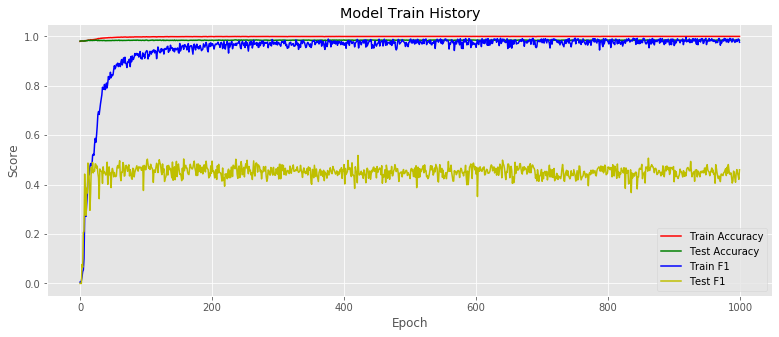

CLASSIFIER PERFORMANCE WASHER DRYER 1 MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,washer dryer 1,98.46,65.62,40.78,50.3,74.76,0.02,0.7,10546,206



CONFUSION MATRIX (OFF/ON):

 - washer dryer 1:
[[10502    44]
 [  122    84]]


---> Splitting `{}` data (train/test)...
---> Training the `washer dryer 2` model...

Train on 32253 samples, validate on 10752 samples
Epoch 1/1000
32253/32253 - 25s - loss: 0.3188 - accuracy: 0.9137 - f1: 0.0010 - val_loss: 0.3260 - val_accuracy: 0.9173 - val_f1: 0.0000e+00
Epoch 2/1000
32253/32253 - 21s - loss: 0.2720 - accuracy: 0.9173 - f1: 0.0000e+00 - val_loss: 0.3122 - val_accuracy: 0.9173 - val_f1: 0.0000e+00
Epoch 3/1000
32253/32253 - 21s - loss: 0.2709 - accuracy: 0.9173 - f1: 0.0000e+00 - val_loss: 0.2924 - val_accuracy: 0.9173 - val_f1: 0.0000e+00
Epoch 4/1000
32253/32253 - 21s - loss: 0.2700 - accuracy: 0.9173 - f1: 0.0000e+00 - val_loss: 0.3379 - val_accuracy: 0.9173 - val_f1: 0.0000e+00
Epoch 5/1000
32253/32253 - 21s - loss: 0.2710 - accuracy: 0.9173 - f1: 0.0000e+00 - val_loss: 0.2850 - val_accuracy: 0.9173 - val_f1: 0.0000e+00
Epoch 6/1000
32253/32253 - 21s - loss: 0.2690 - accuracy: 0.91

Epoch 58/1000
32253/32253 - 20s - loss: 0.2164 - accuracy: 0.9350 - f1: 0.3993 - val_loss: 0.3485 - val_accuracy: 0.9193 - val_f1: 0.1859
Epoch 59/1000
32253/32253 - 20s - loss: 0.2152 - accuracy: 0.9349 - f1: 0.3952 - val_loss: 0.3432 - val_accuracy: 0.9195 - val_f1: 0.1651
Epoch 60/1000
32253/32253 - 20s - loss: 0.2160 - accuracy: 0.9349 - f1: 0.3943 - val_loss: 0.3425 - val_accuracy: 0.9200 - val_f1: 0.1905
Epoch 61/1000
32253/32253 - 20s - loss: 0.2162 - accuracy: 0.9350 - f1: 0.4018 - val_loss: 0.3538 - val_accuracy: 0.9189 - val_f1: 0.1646
Epoch 62/1000
32253/32253 - 20s - loss: 0.2154 - accuracy: 0.9346 - f1: 0.3903 - val_loss: 0.3483 - val_accuracy: 0.9201 - val_f1: 0.2002
Epoch 63/1000
32253/32253 - 20s - loss: 0.2144 - accuracy: 0.9353 - f1: 0.3976 - val_loss: 0.3400 - val_accuracy: 0.9203 - val_f1: 0.1964
Epoch 64/1000
32253/32253 - 20s - loss: 0.2147 - accuracy: 0.9360 - f1: 0.4042 - val_loss: 0.3433 - val_accuracy: 0.9197 - val_f1: 0.1869
Epoch 65/1000
32253/32253 - 20s - 

Epoch 118/1000
32253/32253 - 20s - loss: 0.2095 - accuracy: 0.9381 - f1: 0.4282 - val_loss: 0.4270 - val_accuracy: 0.9203 - val_f1: 0.1695
Epoch 119/1000
32253/32253 - 20s - loss: 0.2104 - accuracy: 0.9380 - f1: 0.4288 - val_loss: 0.4065 - val_accuracy: 0.9192 - val_f1: 0.1831
Epoch 120/1000
32253/32253 - 20s - loss: 0.2093 - accuracy: 0.9380 - f1: 0.4228 - val_loss: 0.3873 - val_accuracy: 0.9189 - val_f1: 0.1819
Epoch 121/1000
32253/32253 - 20s - loss: 0.2103 - accuracy: 0.9375 - f1: 0.4225 - val_loss: 0.4369 - val_accuracy: 0.9206 - val_f1: 0.1671
Epoch 122/1000
32253/32253 - 20s - loss: 0.2093 - accuracy: 0.9381 - f1: 0.4204 - val_loss: 0.4340 - val_accuracy: 0.9204 - val_f1: 0.1665
Epoch 123/1000
32253/32253 - 20s - loss: 0.2089 - accuracy: 0.9381 - f1: 0.4262 - val_loss: 0.4082 - val_accuracy: 0.9192 - val_f1: 0.1626
Epoch 124/1000
32253/32253 - 20s - loss: 0.2092 - accuracy: 0.9381 - f1: 0.4309 - val_loss: 0.4040 - val_accuracy: 0.9183 - val_f1: 0.1647
Epoch 125/1000
32253/32253 

Epoch 177/1000
32253/32253 - 20s - loss: 0.2062 - accuracy: 0.9392 - f1: 0.4365 - val_loss: 0.4315 - val_accuracy: 0.9199 - val_f1: 0.1721
Epoch 178/1000
32253/32253 - 20s - loss: 0.2068 - accuracy: 0.9390 - f1: 0.4369 - val_loss: 0.4356 - val_accuracy: 0.9202 - val_f1: 0.1630
Epoch 179/1000
32253/32253 - 20s - loss: 0.2059 - accuracy: 0.9396 - f1: 0.4398 - val_loss: 0.4273 - val_accuracy: 0.9191 - val_f1: 0.1733
Epoch 180/1000
32253/32253 - 20s - loss: 0.2050 - accuracy: 0.9394 - f1: 0.4355 - val_loss: 0.4457 - val_accuracy: 0.9198 - val_f1: 0.1652
Epoch 181/1000
32253/32253 - 20s - loss: 0.2066 - accuracy: 0.9393 - f1: 0.4317 - val_loss: 0.4649 - val_accuracy: 0.9199 - val_f1: 0.1600
Epoch 182/1000
32253/32253 - 20s - loss: 0.2072 - accuracy: 0.9390 - f1: 0.4315 - val_loss: 0.4416 - val_accuracy: 0.9205 - val_f1: 0.1782
Epoch 183/1000
32253/32253 - 20s - loss: 0.2066 - accuracy: 0.9391 - f1: 0.4359 - val_loss: 0.4481 - val_accuracy: 0.9198 - val_f1: 0.1737
Epoch 184/1000
32253/32253 

Epoch 236/1000
32253/32253 - 20s - loss: 0.2046 - accuracy: 0.9400 - f1: 0.4460 - val_loss: 0.4428 - val_accuracy: 0.9205 - val_f1: 0.1871
Epoch 237/1000
32253/32253 - 20s - loss: 0.2042 - accuracy: 0.9401 - f1: 0.4357 - val_loss: 0.4828 - val_accuracy: 0.9209 - val_f1: 0.1802
Epoch 238/1000
32253/32253 - 20s - loss: 0.2041 - accuracy: 0.9402 - f1: 0.4434 - val_loss: 0.4693 - val_accuracy: 0.9195 - val_f1: 0.1770
Epoch 239/1000
32253/32253 - 20s - loss: 0.2033 - accuracy: 0.9403 - f1: 0.4423 - val_loss: 0.5110 - val_accuracy: 0.9206 - val_f1: 0.1714
Epoch 240/1000
32253/32253 - 20s - loss: 0.2048 - accuracy: 0.9398 - f1: 0.4379 - val_loss: 0.5132 - val_accuracy: 0.9210 - val_f1: 0.1881
Epoch 241/1000
32253/32253 - 20s - loss: 0.2046 - accuracy: 0.9398 - f1: 0.4406 - val_loss: 0.4768 - val_accuracy: 0.9206 - val_f1: 0.1766
Epoch 242/1000
32253/32253 - 20s - loss: 0.2036 - accuracy: 0.9398 - f1: 0.4420 - val_loss: 0.4667 - val_accuracy: 0.9202 - val_f1: 0.1815
Epoch 243/1000
32253/32253 

Epoch 295/1000
32253/32253 - 20s - loss: 0.2040 - accuracy: 0.9399 - f1: 0.4407 - val_loss: 0.4961 - val_accuracy: 0.9211 - val_f1: 0.1819
Epoch 296/1000
32253/32253 - 20s - loss: 0.2032 - accuracy: 0.9403 - f1: 0.4439 - val_loss: 0.5516 - val_accuracy: 0.9214 - val_f1: 0.1774
Epoch 297/1000
32253/32253 - 20s - loss: 0.2041 - accuracy: 0.9404 - f1: 0.4461 - val_loss: 0.4446 - val_accuracy: 0.9206 - val_f1: 0.1994
Epoch 298/1000
32253/32253 - 20s - loss: 0.2020 - accuracy: 0.9409 - f1: 0.4423 - val_loss: 0.4954 - val_accuracy: 0.9209 - val_f1: 0.1862
Epoch 299/1000
32253/32253 - 20s - loss: 0.2028 - accuracy: 0.9406 - f1: 0.4492 - val_loss: 0.4960 - val_accuracy: 0.9211 - val_f1: 0.1810
Epoch 300/1000
32253/32253 - 20s - loss: 0.2040 - accuracy: 0.9407 - f1: 0.4457 - val_loss: 0.4532 - val_accuracy: 0.9185 - val_f1: 0.1860
Epoch 301/1000
32253/32253 - 20s - loss: 0.2023 - accuracy: 0.9408 - f1: 0.4466 - val_loss: 0.5568 - val_accuracy: 0.9211 - val_f1: 0.1687
Epoch 302/1000
32253/32253 

Epoch 354/1000
32253/32253 - 21s - loss: 0.2044 - accuracy: 0.9402 - f1: 0.4435 - val_loss: 0.4852 - val_accuracy: 0.9205 - val_f1: 0.1793
Epoch 355/1000
32253/32253 - 22s - loss: 0.2029 - accuracy: 0.9403 - f1: 0.4378 - val_loss: 0.5463 - val_accuracy: 0.9222 - val_f1: 0.1867
Epoch 356/1000
32253/32253 - 21s - loss: 0.2018 - accuracy: 0.9410 - f1: 0.4532 - val_loss: 0.5138 - val_accuracy: 0.9200 - val_f1: 0.1645
Epoch 357/1000
32253/32253 - 21s - loss: 0.2032 - accuracy: 0.9404 - f1: 0.4474 - val_loss: 0.4624 - val_accuracy: 0.9190 - val_f1: 0.1915
Epoch 358/1000
32253/32253 - 21s - loss: 0.2033 - accuracy: 0.9406 - f1: 0.4456 - val_loss: 0.5568 - val_accuracy: 0.9211 - val_f1: 0.1672
Epoch 359/1000
32253/32253 - 21s - loss: 0.2026 - accuracy: 0.9404 - f1: 0.4421 - val_loss: 0.4774 - val_accuracy: 0.9207 - val_f1: 0.1970
Epoch 360/1000
32253/32253 - 23s - loss: 0.2030 - accuracy: 0.9406 - f1: 0.4442 - val_loss: 0.5348 - val_accuracy: 0.9211 - val_f1: 0.1860
Epoch 361/1000
32253/32253 

Epoch 413/1000
32253/32253 - 20s - loss: 0.2035 - accuracy: 0.9407 - f1: 0.4459 - val_loss: 0.5064 - val_accuracy: 0.9205 - val_f1: 0.1810
Epoch 414/1000
32253/32253 - 20s - loss: 0.2027 - accuracy: 0.9411 - f1: 0.4495 - val_loss: 0.5120 - val_accuracy: 0.9203 - val_f1: 0.1604
Epoch 415/1000
32253/32253 - 20s - loss: 0.2024 - accuracy: 0.9406 - f1: 0.4522 - val_loss: 0.5363 - val_accuracy: 0.9202 - val_f1: 0.1731
Epoch 416/1000
32253/32253 - 20s - loss: 0.2028 - accuracy: 0.9407 - f1: 0.4451 - val_loss: 0.5172 - val_accuracy: 0.9191 - val_f1: 0.1652
Epoch 417/1000
32253/32253 - 20s - loss: 0.2026 - accuracy: 0.9405 - f1: 0.4455 - val_loss: 0.5166 - val_accuracy: 0.9209 - val_f1: 0.1756
Epoch 418/1000
32253/32253 - 20s - loss: 0.2038 - accuracy: 0.9406 - f1: 0.4472 - val_loss: 0.5381 - val_accuracy: 0.9199 - val_f1: 0.1829
Epoch 419/1000
32253/32253 - 20s - loss: 0.2035 - accuracy: 0.9405 - f1: 0.4481 - val_loss: 0.5279 - val_accuracy: 0.9211 - val_f1: 0.1857
Epoch 420/1000
32253/32253 

Epoch 472/1000
32253/32253 - 20s - loss: 0.2021 - accuracy: 0.9409 - f1: 0.4509 - val_loss: 0.6036 - val_accuracy: 0.9211 - val_f1: 0.1729
Epoch 473/1000
32253/32253 - 20s - loss: 0.2014 - accuracy: 0.9412 - f1: 0.4457 - val_loss: 0.5010 - val_accuracy: 0.9202 - val_f1: 0.1858
Epoch 474/1000
32253/32253 - 20s - loss: 0.2020 - accuracy: 0.9410 - f1: 0.4527 - val_loss: 0.4909 - val_accuracy: 0.9199 - val_f1: 0.1810
Epoch 475/1000
32253/32253 - 20s - loss: 0.2019 - accuracy: 0.9411 - f1: 0.4545 - val_loss: 0.5085 - val_accuracy: 0.9197 - val_f1: 0.1696
Epoch 476/1000
32253/32253 - 20s - loss: 0.2019 - accuracy: 0.9412 - f1: 0.4541 - val_loss: 0.5183 - val_accuracy: 0.9195 - val_f1: 0.1529
Epoch 477/1000
32253/32253 - 20s - loss: 0.2027 - accuracy: 0.9410 - f1: 0.4513 - val_loss: 0.5054 - val_accuracy: 0.9201 - val_f1: 0.1869
Epoch 478/1000
32253/32253 - 20s - loss: 0.2020 - accuracy: 0.9412 - f1: 0.4461 - val_loss: 0.5487 - val_accuracy: 0.9212 - val_f1: 0.1735
Epoch 479/1000
32253/32253 

Epoch 531/1000
32253/32253 - 20s - loss: 0.2002 - accuracy: 0.9414 - f1: 0.4539 - val_loss: 0.6118 - val_accuracy: 0.9209 - val_f1: 0.1776
Epoch 532/1000
32253/32253 - 20s - loss: 0.1982 - accuracy: 0.9414 - f1: 0.4549 - val_loss: 0.6450 - val_accuracy: 0.9209 - val_f1: 0.1695
Epoch 533/1000
32253/32253 - 20s - loss: 0.1989 - accuracy: 0.9412 - f1: 0.4506 - val_loss: 0.6482 - val_accuracy: 0.9215 - val_f1: 0.1756
Epoch 534/1000
32253/32253 - 20s - loss: 0.2001 - accuracy: 0.9412 - f1: 0.4484 - val_loss: 0.6749 - val_accuracy: 0.9212 - val_f1: 0.1791
Epoch 535/1000
32253/32253 - 20s - loss: 0.2012 - accuracy: 0.9409 - f1: 0.4466 - val_loss: 0.6085 - val_accuracy: 0.9212 - val_f1: 0.1868
Epoch 536/1000
32253/32253 - 20s - loss: 0.2006 - accuracy: 0.9406 - f1: 0.4457 - val_loss: 0.6839 - val_accuracy: 0.9219 - val_f1: 0.1671
Epoch 537/1000
32253/32253 - 20s - loss: 0.1992 - accuracy: 0.9414 - f1: 0.4477 - val_loss: 0.6197 - val_accuracy: 0.9209 - val_f1: 0.1664
Epoch 538/1000
32253/32253 

Epoch 590/1000
32253/32253 - 20s - loss: 0.1980 - accuracy: 0.9411 - f1: 0.4464 - val_loss: 0.6830 - val_accuracy: 0.9197 - val_f1: 0.1564
Epoch 591/1000
32253/32253 - 20s - loss: 0.1971 - accuracy: 0.9413 - f1: 0.4491 - val_loss: 0.6300 - val_accuracy: 0.9196 - val_f1: 0.1904
Epoch 592/1000
32253/32253 - 20s - loss: 0.1974 - accuracy: 0.9411 - f1: 0.4465 - val_loss: 0.7429 - val_accuracy: 0.9215 - val_f1: 0.1683
Epoch 593/1000
32253/32253 - 20s - loss: 0.1970 - accuracy: 0.9416 - f1: 0.4517 - val_loss: 0.6757 - val_accuracy: 0.9209 - val_f1: 0.1719
Epoch 594/1000
32253/32253 - 20s - loss: 0.1976 - accuracy: 0.9413 - f1: 0.4516 - val_loss: 0.7018 - val_accuracy: 0.9208 - val_f1: 0.1662
Epoch 595/1000
32253/32253 - 20s - loss: 0.1981 - accuracy: 0.9413 - f1: 0.4525 - val_loss: 0.7131 - val_accuracy: 0.9207 - val_f1: 0.1612
Epoch 596/1000
32253/32253 - 20s - loss: 0.1977 - accuracy: 0.9412 - f1: 0.4468 - val_loss: 0.7327 - val_accuracy: 0.9218 - val_f1: 0.1795
Epoch 597/1000
32253/32253 

Epoch 649/1000
32253/32253 - 20s - loss: 0.1971 - accuracy: 0.9413 - f1: 0.4547 - val_loss: 0.7688 - val_accuracy: 0.9211 - val_f1: 0.1707
Epoch 650/1000
32253/32253 - 20s - loss: 0.1965 - accuracy: 0.9415 - f1: 0.4550 - val_loss: 0.7824 - val_accuracy: 0.9222 - val_f1: 0.1737
Epoch 651/1000
32253/32253 - 20s - loss: 0.1969 - accuracy: 0.9416 - f1: 0.4532 - val_loss: 0.8447 - val_accuracy: 0.9217 - val_f1: 0.1663
Epoch 652/1000
32253/32253 - 20s - loss: 0.1975 - accuracy: 0.9407 - f1: 0.4463 - val_loss: 0.7334 - val_accuracy: 0.9214 - val_f1: 0.1639
Epoch 653/1000
32253/32253 - 20s - loss: 0.1982 - accuracy: 0.9411 - f1: 0.4481 - val_loss: 0.7764 - val_accuracy: 0.9201 - val_f1: 0.1660
Epoch 654/1000
32253/32253 - 20s - loss: 0.1968 - accuracy: 0.9414 - f1: 0.4497 - val_loss: 0.9586 - val_accuracy: 0.9215 - val_f1: 0.1522
Epoch 655/1000
32253/32253 - 20s - loss: 0.1975 - accuracy: 0.9411 - f1: 0.4519 - val_loss: 0.8251 - val_accuracy: 0.9217 - val_f1: 0.1626
Epoch 656/1000
32253/32253 

Epoch 708/1000
32253/32253 - 20s - loss: 0.1960 - accuracy: 0.9415 - f1: 0.4553 - val_loss: 0.8908 - val_accuracy: 0.9213 - val_f1: 0.1640
Epoch 709/1000
32253/32253 - 20s - loss: 0.1964 - accuracy: 0.9413 - f1: 0.4498 - val_loss: 0.8422 - val_accuracy: 0.9206 - val_f1: 0.1604
Epoch 710/1000
32253/32253 - 20s - loss: 0.1966 - accuracy: 0.9414 - f1: 0.4508 - val_loss: 0.8221 - val_accuracy: 0.9215 - val_f1: 0.1728
Epoch 711/1000
32253/32253 - 20s - loss: 0.1976 - accuracy: 0.9409 - f1: 0.4529 - val_loss: 0.7846 - val_accuracy: 0.9221 - val_f1: 0.1735
Epoch 712/1000
32253/32253 - 20s - loss: 0.1963 - accuracy: 0.9413 - f1: 0.4544 - val_loss: 0.7705 - val_accuracy: 0.9211 - val_f1: 0.1729
Epoch 713/1000
32253/32253 - 20s - loss: 0.1966 - accuracy: 0.9413 - f1: 0.4467 - val_loss: 0.8204 - val_accuracy: 0.9207 - val_f1: 0.1671
Epoch 714/1000
32253/32253 - 20s - loss: 0.1963 - accuracy: 0.9415 - f1: 0.4542 - val_loss: 0.8562 - val_accuracy: 0.9212 - val_f1: 0.1594
Epoch 715/1000
32253/32253 

Epoch 767/1000
32253/32253 - 20s - loss: 0.1969 - accuracy: 0.9412 - f1: 0.4524 - val_loss: 0.8436 - val_accuracy: 0.9204 - val_f1: 0.1644
Epoch 768/1000
32253/32253 - 20s - loss: 0.1960 - accuracy: 0.9414 - f1: 0.4529 - val_loss: 0.8616 - val_accuracy: 0.9215 - val_f1: 0.1747
Epoch 769/1000
32253/32253 - 20s - loss: 0.1968 - accuracy: 0.9414 - f1: 0.4526 - val_loss: 0.9311 - val_accuracy: 0.9212 - val_f1: 0.1809
Epoch 770/1000
32253/32253 - 20s - loss: 0.1954 - accuracy: 0.9415 - f1: 0.4578 - val_loss: 0.9093 - val_accuracy: 0.9213 - val_f1: 0.1731
Epoch 771/1000
32253/32253 - 20s - loss: 0.1963 - accuracy: 0.9415 - f1: 0.4558 - val_loss: 0.8657 - val_accuracy: 0.9207 - val_f1: 0.1679
Epoch 772/1000
32253/32253 - 20s - loss: 0.1963 - accuracy: 0.9413 - f1: 0.4495 - val_loss: 0.8518 - val_accuracy: 0.9211 - val_f1: 0.1777
Epoch 773/1000
32253/32253 - 20s - loss: 0.1977 - accuracy: 0.9410 - f1: 0.4453 - val_loss: 0.9117 - val_accuracy: 0.9211 - val_f1: 0.1780
Epoch 774/1000
32253/32253 

Epoch 826/1000
32253/32253 - 20s - loss: 0.1961 - accuracy: 0.9397 - f1: 0.4177 - val_loss: 0.9787 - val_accuracy: 0.9215 - val_f1: 0.1510
Epoch 827/1000
32253/32253 - 20s - loss: 0.1968 - accuracy: 0.9399 - f1: 0.4231 - val_loss: 0.9815 - val_accuracy: 0.9214 - val_f1: 0.1628
Epoch 828/1000
32253/32253 - 20s - loss: 0.1960 - accuracy: 0.9397 - f1: 0.4232 - val_loss: 0.8793 - val_accuracy: 0.9215 - val_f1: 0.1704
Epoch 829/1000
32253/32253 - 20s - loss: 0.1960 - accuracy: 0.9398 - f1: 0.4249 - val_loss: 0.8218 - val_accuracy: 0.9219 - val_f1: 0.1760
Epoch 830/1000
32253/32253 - 20s - loss: 0.1957 - accuracy: 0.9399 - f1: 0.4259 - val_loss: 0.8495 - val_accuracy: 0.9207 - val_f1: 0.1758
Epoch 831/1000
32253/32253 - 20s - loss: 0.1964 - accuracy: 0.9397 - f1: 0.4299 - val_loss: 1.0566 - val_accuracy: 0.9208 - val_f1: 0.1358
Epoch 832/1000
32253/32253 - 20s - loss: 0.1954 - accuracy: 0.9400 - f1: 0.4245 - val_loss: 0.8937 - val_accuracy: 0.9202 - val_f1: 0.1559
Epoch 833/1000
32253/32253 

Epoch 885/1000
32253/32253 - 20s - loss: 0.1957 - accuracy: 0.9402 - f1: 0.4323 - val_loss: 0.9636 - val_accuracy: 0.9211 - val_f1: 0.1530
Epoch 886/1000
32253/32253 - 20s - loss: 0.1958 - accuracy: 0.9402 - f1: 0.4307 - val_loss: 0.9198 - val_accuracy: 0.9209 - val_f1: 0.1718
Epoch 887/1000
32253/32253 - 20s - loss: 0.1957 - accuracy: 0.9399 - f1: 0.4267 - val_loss: 0.9769 - val_accuracy: 0.9219 - val_f1: 0.1658
Epoch 888/1000
32253/32253 - 20s - loss: 0.1959 - accuracy: 0.9398 - f1: 0.4222 - val_loss: 0.9716 - val_accuracy: 0.9220 - val_f1: 0.1741
Epoch 889/1000
32253/32253 - 20s - loss: 0.1961 - accuracy: 0.9396 - f1: 0.4169 - val_loss: 0.9991 - val_accuracy: 0.9217 - val_f1: 0.1670
Epoch 890/1000
32253/32253 - 20s - loss: 0.1950 - accuracy: 0.9401 - f1: 0.4264 - val_loss: 0.9907 - val_accuracy: 0.9214 - val_f1: 0.1729
Epoch 891/1000
32253/32253 - 20s - loss: 0.1951 - accuracy: 0.9401 - f1: 0.4305 - val_loss: 0.9387 - val_accuracy: 0.9216 - val_f1: 0.1773
Epoch 892/1000
32253/32253 

Epoch 944/1000
32253/32253 - 20s - loss: 0.1952 - accuracy: 0.9403 - f1: 0.4249 - val_loss: 0.9631 - val_accuracy: 0.9205 - val_f1: 0.1656
Epoch 945/1000
32253/32253 - 20s - loss: 0.1953 - accuracy: 0.9400 - f1: 0.4245 - val_loss: 0.9303 - val_accuracy: 0.9210 - val_f1: 0.1679
Epoch 946/1000
32253/32253 - 20s - loss: 0.1955 - accuracy: 0.9400 - f1: 0.4240 - val_loss: 0.8951 - val_accuracy: 0.9200 - val_f1: 0.1769
Epoch 947/1000
32253/32253 - 20s - loss: 0.1961 - accuracy: 0.9398 - f1: 0.4249 - val_loss: 0.8828 - val_accuracy: 0.9216 - val_f1: 0.1790
Epoch 948/1000
32253/32253 - 20s - loss: 0.1962 - accuracy: 0.9403 - f1: 0.4301 - val_loss: 0.9087 - val_accuracy: 0.9206 - val_f1: 0.1823
Epoch 949/1000
32253/32253 - 20s - loss: 0.1961 - accuracy: 0.9399 - f1: 0.4230 - val_loss: 1.0295 - val_accuracy: 0.9224 - val_f1: 0.1648
Epoch 950/1000
32253/32253 - 20s - loss: 0.1970 - accuracy: 0.9397 - f1: 0.4234 - val_loss: 0.9340 - val_accuracy: 0.9211 - val_f1: 0.1703
Epoch 951/1000
32253/32253 

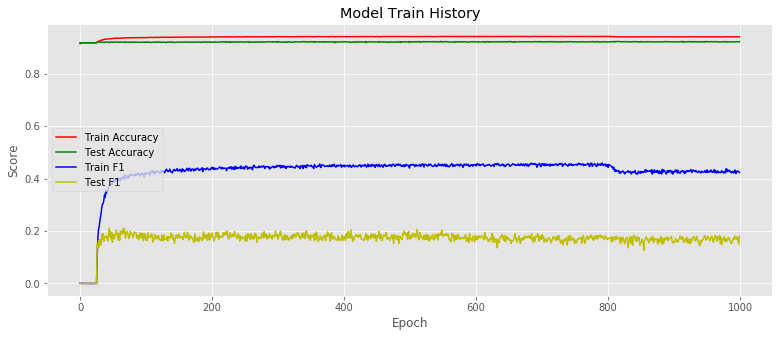

CLASSIFIER PERFORMANCE WASHER DRYER 2 MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,washer dryer 2,92.22,69.63,10.57,18.36,57.14,0.08,0.55,9863,889



CONFUSION MATRIX (OFF/ON):

 - washer dryer 2:
[[9822   41]
 [ 795   94]]


---> Splitting `{}` data (train/test)...
---> Training the `microwave` model...

Train on 32253 samples, validate on 10752 samples
Epoch 1/1000
32253/32253 - 33s - loss: 0.0349 - accuracy: 0.9918 - f1: 0.9950 - val_loss: 0.0268 - val_accuracy: 0.9962 - val_f1: 0.9981
Epoch 2/1000
32253/32253 - 21s - loss: 0.0221 - accuracy: 0.9962 - f1: 0.9981 - val_loss: 0.0226 - val_accuracy: 0.9962 - val_f1: 0.9981
Epoch 3/1000
32253/32253 - 21s - loss: 0.0218 - accuracy: 0.9962 - f1: 0.9981 - val_loss: 0.0348 - val_accuracy: 0.9962 - val_f1: 0.9981
Epoch 4/1000
32253/32253 - 21s - loss: 0.0205 - accuracy: 0.9962 - f1: 0.9981 - val_loss: 0.0241 - val_accuracy: 0.9962 - val_f1: 0.9981
Epoch 5/1000
32253/32253 - 21s - loss: 0.0201 - accuracy: 0.9962 - f1: 0.9981 - val_loss: 0.0247 - val_accuracy: 0.9962 - val_f1: 0.9981
Epoch 6/1000
32253/32253 - 21s - loss: 0.0195 - accuracy: 0.9962 - f1: 0.9981 - val_loss: 0.0281 - val_accu

Epoch 59/1000
32253/32253 - 20s - loss: 0.0035 - accuracy: 0.9995 - f1: 0.9998 - val_loss: 0.0737 - val_accuracy: 0.9957 - val_f1: 0.9979
Epoch 60/1000
32253/32253 - 20s - loss: 0.0038 - accuracy: 0.9993 - f1: 0.9997 - val_loss: 0.0694 - val_accuracy: 0.9949 - val_f1: 0.9974
Epoch 61/1000
32253/32253 - 20s - loss: 0.0042 - accuracy: 0.9993 - f1: 0.9996 - val_loss: 0.0710 - val_accuracy: 0.9957 - val_f1: 0.9979
Epoch 62/1000
32253/32253 - 20s - loss: 0.0039 - accuracy: 0.9995 - f1: 0.9997 - val_loss: 0.0782 - val_accuracy: 0.9962 - val_f1: 0.9981
Epoch 63/1000
32253/32253 - 20s - loss: 0.0036 - accuracy: 0.9995 - f1: 0.9997 - val_loss: 0.0764 - val_accuracy: 0.9956 - val_f1: 0.9978
Epoch 64/1000
32253/32253 - 20s - loss: 0.0040 - accuracy: 0.9993 - f1: 0.9996 - val_loss: 0.0771 - val_accuracy: 0.9960 - val_f1: 0.9980
Epoch 65/1000
32253/32253 - 20s - loss: 0.0037 - accuracy: 0.9992 - f1: 0.9996 - val_loss: 0.0835 - val_accuracy: 0.9958 - val_f1: 0.9979
Epoch 66/1000
32253/32253 - 20s - 

Epoch 119/1000
32253/32253 - 20s - loss: 0.0033 - accuracy: 0.9995 - f1: 0.9998 - val_loss: 0.0841 - val_accuracy: 0.9955 - val_f1: 0.9978
Epoch 120/1000
32253/32253 - 20s - loss: 0.0033 - accuracy: 0.9995 - f1: 0.9998 - val_loss: 0.0895 - val_accuracy: 0.9953 - val_f1: 0.9977
Epoch 121/1000
32253/32253 - 20s - loss: 0.0034 - accuracy: 0.9996 - f1: 0.9998 - val_loss: 0.1009 - val_accuracy: 0.9959 - val_f1: 0.9979
Epoch 122/1000
32253/32253 - 20s - loss: 0.0031 - accuracy: 0.9995 - f1: 0.9998 - val_loss: 0.0913 - val_accuracy: 0.9959 - val_f1: 0.9979
Epoch 123/1000
32253/32253 - 20s - loss: 0.0033 - accuracy: 0.9996 - f1: 0.9998 - val_loss: 0.0885 - val_accuracy: 0.9955 - val_f1: 0.9978
Epoch 124/1000
32253/32253 - 20s - loss: 0.0036 - accuracy: 0.9995 - f1: 0.9998 - val_loss: 0.0846 - val_accuracy: 0.9957 - val_f1: 0.9979
Epoch 125/1000
32253/32253 - 20s - loss: 0.0035 - accuracy: 0.9995 - f1: 0.9997 - val_loss: 0.0942 - val_accuracy: 0.9958 - val_f1: 0.9979
Epoch 126/1000
32253/32253 

Epoch 178/1000
32253/32253 - 20s - loss: 0.0037 - accuracy: 0.9995 - f1: 0.9997 - val_loss: 0.1225 - val_accuracy: 0.9959 - val_f1: 0.9979
Epoch 179/1000
32253/32253 - 20s - loss: 0.0033 - accuracy: 0.9995 - f1: 0.9997 - val_loss: 0.0923 - val_accuracy: 0.9958 - val_f1: 0.9979
Epoch 180/1000
32253/32253 - 20s - loss: 0.0036 - accuracy: 0.9995 - f1: 0.9998 - val_loss: 0.1237 - val_accuracy: 0.9961 - val_f1: 0.9980
Epoch 181/1000
32253/32253 - 20s - loss: 0.0029 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1031 - val_accuracy: 0.9955 - val_f1: 0.9978
Epoch 182/1000
32253/32253 - 20s - loss: 0.0033 - accuracy: 0.9995 - f1: 0.9998 - val_loss: 0.0981 - val_accuracy: 0.9959 - val_f1: 0.9979
Epoch 183/1000
32253/32253 - 20s - loss: 0.0037 - accuracy: 0.9996 - f1: 0.9998 - val_loss: 0.0951 - val_accuracy: 0.9956 - val_f1: 0.9978
Epoch 184/1000
32253/32253 - 20s - loss: 0.0032 - accuracy: 0.9996 - f1: 0.9998 - val_loss: 0.0863 - val_accuracy: 0.9951 - val_f1: 0.9975
Epoch 185/1000
32253/32253 

Epoch 237/1000
32253/32253 - 20s - loss: 0.0032 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.0962 - val_accuracy: 0.9952 - val_f1: 0.9976
Epoch 238/1000
32253/32253 - 20s - loss: 0.0029 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1078 - val_accuracy: 0.9953 - val_f1: 0.9976
Epoch 239/1000
32253/32253 - 20s - loss: 0.0030 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1081 - val_accuracy: 0.9952 - val_f1: 0.9976
Epoch 240/1000
32253/32253 - 20s - loss: 0.0031 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1009 - val_accuracy: 0.9950 - val_f1: 0.9975
Epoch 241/1000
32253/32253 - 20s - loss: 0.0030 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1095 - val_accuracy: 0.9951 - val_f1: 0.9975
Epoch 242/1000
32253/32253 - 20s - loss: 0.0044 - accuracy: 0.9995 - f1: 0.9997 - val_loss: 0.0822 - val_accuracy: 0.9953 - val_f1: 0.9976
Epoch 243/1000
32253/32253 - 20s - loss: 0.0030 - accuracy: 0.9996 - f1: 0.9998 - val_loss: 0.0850 - val_accuracy: 0.9945 - val_f1: 0.9972
Epoch 244/1000
32253/32253 

Epoch 296/1000
32253/32253 - 20s - loss: 0.0030 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1272 - val_accuracy: 0.9957 - val_f1: 0.9979
Epoch 297/1000
32253/32253 - 20s - loss: 0.0028 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1060 - val_accuracy: 0.9948 - val_f1: 0.9974
Epoch 298/1000
32253/32253 - 20s - loss: 0.0030 - accuracy: 0.9996 - f1: 0.9998 - val_loss: 0.0985 - val_accuracy: 0.9949 - val_f1: 0.9974
Epoch 299/1000
32253/32253 - 20s - loss: 0.0031 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.0902 - val_accuracy: 0.9947 - val_f1: 0.9973
Epoch 300/1000
32253/32253 - 20s - loss: 0.0033 - accuracy: 0.9995 - f1: 0.9998 - val_loss: 0.0968 - val_accuracy: 0.9951 - val_f1: 0.9975
Epoch 301/1000
32253/32253 - 20s - loss: 0.0035 - accuracy: 0.9996 - f1: 0.9998 - val_loss: 0.0810 - val_accuracy: 0.9946 - val_f1: 0.9973
Epoch 302/1000
32253/32253 - 20s - loss: 0.0032 - accuracy: 0.9996 - f1: 0.9998 - val_loss: 0.0912 - val_accuracy: 0.9951 - val_f1: 0.9975
Epoch 303/1000
32253/32253 

Epoch 355/1000
32253/32253 - 20s - loss: 0.0032 - accuracy: 0.9996 - f1: 0.9998 - val_loss: 0.0961 - val_accuracy: 0.9944 - val_f1: 0.9972
Epoch 356/1000
32253/32253 - 20s - loss: 0.0033 - accuracy: 0.9995 - f1: 0.9998 - val_loss: 0.0791 - val_accuracy: 0.9922 - val_f1: 0.9961
Epoch 357/1000
32253/32253 - 20s - loss: 0.0032 - accuracy: 0.9996 - f1: 0.9998 - val_loss: 0.0976 - val_accuracy: 0.9952 - val_f1: 0.9976
Epoch 358/1000
32253/32253 - 20s - loss: 0.0032 - accuracy: 0.9996 - f1: 0.9998 - val_loss: 0.1036 - val_accuracy: 0.9951 - val_f1: 0.9975
Epoch 359/1000
32253/32253 - 20s - loss: 0.0036 - accuracy: 0.9996 - f1: 0.9998 - val_loss: 0.0806 - val_accuracy: 0.9936 - val_f1: 0.9968
Epoch 360/1000
32253/32253 - 20s - loss: 0.0032 - accuracy: 0.9996 - f1: 0.9998 - val_loss: 0.0960 - val_accuracy: 0.9947 - val_f1: 0.9973
Epoch 361/1000
32253/32253 - 20s - loss: 0.0034 - accuracy: 0.9995 - f1: 0.9998 - val_loss: 0.0970 - val_accuracy: 0.9947 - val_f1: 0.9973
Epoch 362/1000
32253/32253 

Epoch 414/1000
32253/32253 - 20s - loss: 0.0033 - accuracy: 0.9996 - f1: 0.9998 - val_loss: 0.1122 - val_accuracy: 0.9948 - val_f1: 0.9974
Epoch 415/1000
32253/32253 - 20s - loss: 0.0034 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1135 - val_accuracy: 0.9946 - val_f1: 0.9973
Epoch 416/1000
32253/32253 - 20s - loss: 0.0028 - accuracy: 0.9996 - f1: 0.9998 - val_loss: 0.1173 - val_accuracy: 0.9941 - val_f1: 0.9971
Epoch 417/1000
32253/32253 - 20s - loss: 0.0032 - accuracy: 0.9996 - f1: 0.9998 - val_loss: 0.1174 - val_accuracy: 0.9950 - val_f1: 0.9975
Epoch 418/1000
32253/32253 - 20s - loss: 0.0032 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1189 - val_accuracy: 0.9948 - val_f1: 0.9974
Epoch 419/1000
32253/32253 - 20s - loss: 0.0029 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1282 - val_accuracy: 0.9952 - val_f1: 0.9976
Epoch 420/1000
32253/32253 - 20s - loss: 0.0031 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1179 - val_accuracy: 0.9948 - val_f1: 0.9974
Epoch 421/1000
32253/32253 

Epoch 473/1000
32253/32253 - 20s - loss: 0.0032 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1169 - val_accuracy: 0.9951 - val_f1: 0.9975
Epoch 474/1000
32253/32253 - 20s - loss: 0.0033 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1221 - val_accuracy: 0.9952 - val_f1: 0.9976
Epoch 475/1000
32253/32253 - 20s - loss: 0.0032 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1125 - val_accuracy: 0.9947 - val_f1: 0.9973
Epoch 476/1000
32253/32253 - 20s - loss: 0.0030 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1248 - val_accuracy: 0.9953 - val_f1: 0.9976
Epoch 477/1000
32253/32253 - 20s - loss: 0.0031 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.2084 - val_accuracy: 0.9959 - val_f1: 0.9979
Epoch 478/1000
32253/32253 - 20s - loss: 0.0041 - accuracy: 0.9995 - f1: 0.9998 - val_loss: 0.1088 - val_accuracy: 0.9950 - val_f1: 0.9975
Epoch 479/1000
32253/32253 - 20s - loss: 0.0033 - accuracy: 0.9996 - f1: 0.9998 - val_loss: 0.1069 - val_accuracy: 0.9949 - val_f1: 0.9974
Epoch 480/1000
32253/32253 

Epoch 532/1000
32253/32253 - 20s - loss: 0.0031 - accuracy: 0.9996 - f1: 0.9998 - val_loss: 0.1172 - val_accuracy: 0.9951 - val_f1: 0.9975
Epoch 533/1000
32253/32253 - 20s - loss: 0.0029 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1105 - val_accuracy: 0.9947 - val_f1: 0.9973
Epoch 534/1000
32253/32253 - 20s - loss: 0.0030 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1041 - val_accuracy: 0.9945 - val_f1: 0.9972
Epoch 535/1000
32253/32253 - 20s - loss: 0.0046 - accuracy: 0.9994 - f1: 0.9997 - val_loss: 0.0971 - val_accuracy: 0.9930 - val_f1: 0.9965
Epoch 536/1000
32253/32253 - 20s - loss: 0.0053 - accuracy: 0.9994 - f1: 0.9997 - val_loss: 0.1199 - val_accuracy: 0.9952 - val_f1: 0.9976
Epoch 537/1000
32253/32253 - 20s - loss: 0.0038 - accuracy: 0.9995 - f1: 0.9998 - val_loss: 0.1002 - val_accuracy: 0.9949 - val_f1: 0.9974
Epoch 538/1000
32253/32253 - 20s - loss: 0.0030 - accuracy: 0.9996 - f1: 0.9998 - val_loss: 0.1062 - val_accuracy: 0.9947 - val_f1: 0.9973
Epoch 539/1000
32253/32253 

Epoch 591/1000
32253/32253 - 20s - loss: 0.0038 - accuracy: 0.9996 - f1: 0.9998 - val_loss: 0.1091 - val_accuracy: 0.9941 - val_f1: 0.9971
Epoch 592/1000
32253/32253 - 20s - loss: 0.0035 - accuracy: 0.9995 - f1: 0.9998 - val_loss: 0.1498 - val_accuracy: 0.9955 - val_f1: 0.9978
Epoch 593/1000
32253/32253 - 20s - loss: 0.0033 - accuracy: 0.9995 - f1: 0.9998 - val_loss: 0.1282 - val_accuracy: 0.9952 - val_f1: 0.9976
Epoch 594/1000
32253/32253 - 20s - loss: 0.0030 - accuracy: 0.9996 - f1: 0.9998 - val_loss: 0.1252 - val_accuracy: 0.9951 - val_f1: 0.9975
Epoch 595/1000
32253/32253 - 20s - loss: 0.0032 - accuracy: 0.9996 - f1: 0.9998 - val_loss: 0.1233 - val_accuracy: 0.9946 - val_f1: 0.9973
Epoch 596/1000
32253/32253 - 20s - loss: 0.0032 - accuracy: 0.9996 - f1: 0.9998 - val_loss: 0.1179 - val_accuracy: 0.9944 - val_f1: 0.9972
Epoch 597/1000
32253/32253 - 20s - loss: 0.0031 - accuracy: 0.9996 - f1: 0.9998 - val_loss: 0.1154 - val_accuracy: 0.9939 - val_f1: 0.9969
Epoch 598/1000
32253/32253 

Epoch 650/1000
32253/32253 - 20s - loss: 0.0029 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1130 - val_accuracy: 0.9951 - val_f1: 0.9975
Epoch 651/1000
32253/32253 - 20s - loss: 0.0030 - accuracy: 0.9996 - f1: 0.9998 - val_loss: 0.1110 - val_accuracy: 0.9946 - val_f1: 0.9973
Epoch 652/1000
32253/32253 - 20s - loss: 0.0031 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1169 - val_accuracy: 0.9948 - val_f1: 0.9974
Epoch 653/1000
32253/32253 - 20s - loss: 0.0031 - accuracy: 0.9996 - f1: 0.9998 - val_loss: 0.1102 - val_accuracy: 0.9944 - val_f1: 0.9972
Epoch 654/1000
32253/32253 - 20s - loss: 0.0034 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1109 - val_accuracy: 0.9944 - val_f1: 0.9972
Epoch 655/1000
32253/32253 - 20s - loss: 0.0038 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1098 - val_accuracy: 0.9954 - val_f1: 0.9977
Epoch 656/1000
32253/32253 - 20s - loss: 0.0035 - accuracy: 0.9995 - f1: 0.9998 - val_loss: 0.1005 - val_accuracy: 0.9946 - val_f1: 0.9973
Epoch 657/1000
32253/32253 

Epoch 709/1000
32253/32253 - 20s - loss: 0.0031 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1066 - val_accuracy: 0.9955 - val_f1: 0.9978
Epoch 710/1000
32253/32253 - 20s - loss: 0.0031 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1169 - val_accuracy: 0.9955 - val_f1: 0.9978
Epoch 711/1000
32253/32253 - 20s - loss: 0.0032 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1180 - val_accuracy: 0.9956 - val_f1: 0.9978
Epoch 712/1000
32253/32253 - 20s - loss: 0.0032 - accuracy: 0.9996 - f1: 0.9998 - val_loss: 0.0720 - val_accuracy: 0.9907 - val_f1: 0.9953
Epoch 713/1000
32253/32253 - 20s - loss: 0.0032 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.0898 - val_accuracy: 0.9940 - val_f1: 0.9970
Epoch 714/1000
32253/32253 - 20s - loss: 0.0036 - accuracy: 0.9996 - f1: 0.9998 - val_loss: 0.1185 - val_accuracy: 0.9957 - val_f1: 0.9979
Epoch 715/1000
32253/32253 - 20s - loss: 0.0032 - accuracy: 0.9996 - f1: 0.9998 - val_loss: 0.0964 - val_accuracy: 0.9944 - val_f1: 0.9972
Epoch 716/1000
32253/32253 

Epoch 768/1000
32253/32253 - 20s - loss: 0.0030 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1207 - val_accuracy: 0.9940 - val_f1: 0.9970
Epoch 769/1000
32253/32253 - 20s - loss: 0.0029 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1218 - val_accuracy: 0.9944 - val_f1: 0.9972
Epoch 770/1000
32253/32253 - 20s - loss: 0.0030 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1436 - val_accuracy: 0.9953 - val_f1: 0.9976
Epoch 771/1000
32253/32253 - 20s - loss: 0.0035 - accuracy: 0.9995 - f1: 0.9998 - val_loss: 0.1036 - val_accuracy: 0.9943 - val_f1: 0.9972
Epoch 772/1000
32253/32253 - 20s - loss: 0.0032 - accuracy: 0.9996 - f1: 0.9998 - val_loss: 0.1166 - val_accuracy: 0.9941 - val_f1: 0.9971
Epoch 773/1000
32253/32253 - 20s - loss: 0.0030 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1190 - val_accuracy: 0.9941 - val_f1: 0.9971
Epoch 774/1000
32253/32253 - 20s - loss: 0.0032 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1212 - val_accuracy: 0.9946 - val_f1: 0.9973
Epoch 775/1000
32253/32253 

Epoch 827/1000
32253/32253 - 20s - loss: 0.0031 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1133 - val_accuracy: 0.9943 - val_f1: 0.9972
Epoch 828/1000
32253/32253 - 20s - loss: 0.0031 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1323 - val_accuracy: 0.9948 - val_f1: 0.9974
Epoch 829/1000
32253/32253 - 20s - loss: 0.0033 - accuracy: 0.9996 - f1: 0.9998 - val_loss: 0.1114 - val_accuracy: 0.9939 - val_f1: 0.9969
Epoch 830/1000
32253/32253 - 20s - loss: 0.0030 - accuracy: 0.9996 - f1: 0.9998 - val_loss: 0.1008 - val_accuracy: 0.9936 - val_f1: 0.9968
Epoch 831/1000
32253/32253 - 20s - loss: 0.0032 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1036 - val_accuracy: 0.9941 - val_f1: 0.9971
Epoch 832/1000
32253/32253 - 20s - loss: 0.0029 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1096 - val_accuracy: 0.9943 - val_f1: 0.9972
Epoch 833/1000
32253/32253 - 20s - loss: 0.0031 - accuracy: 0.9996 - f1: 0.9998 - val_loss: 0.1438 - val_accuracy: 0.9953 - val_f1: 0.9977
Epoch 834/1000
32253/32253 

Epoch 886/1000
32253/32253 - 20s - loss: 0.0031 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1219 - val_accuracy: 0.9942 - val_f1: 0.9971
Epoch 887/1000
32253/32253 - 20s - loss: 0.0028 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1222 - val_accuracy: 0.9946 - val_f1: 0.9973
Epoch 888/1000
32253/32253 - 20s - loss: 0.0032 - accuracy: 0.9996 - f1: 0.9998 - val_loss: 0.1182 - val_accuracy: 0.9938 - val_f1: 0.9969
Epoch 889/1000
32253/32253 - 20s - loss: 0.0031 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1315 - val_accuracy: 0.9944 - val_f1: 0.9972
Epoch 890/1000
32253/32253 - 20s - loss: 0.0028 - accuracy: 0.9996 - f1: 0.9998 - val_loss: 0.1123 - val_accuracy: 0.9927 - val_f1: 0.9963
Epoch 891/1000
32253/32253 - 20s - loss: 0.0029 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1166 - val_accuracy: 0.9935 - val_f1: 0.9967
Epoch 892/1000
32253/32253 - 20s - loss: 0.0031 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1094 - val_accuracy: 0.9933 - val_f1: 0.9966
Epoch 893/1000
32253/32253 

Epoch 945/1000
32253/32253 - 20s - loss: 0.0030 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1192 - val_accuracy: 0.9941 - val_f1: 0.9971
Epoch 946/1000
32253/32253 - 20s - loss: 0.0030 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1298 - val_accuracy: 0.9946 - val_f1: 0.9973
Epoch 947/1000
32253/32253 - 20s - loss: 0.0032 - accuracy: 0.9996 - f1: 0.9998 - val_loss: 0.1352 - val_accuracy: 0.9947 - val_f1: 0.9973
Epoch 948/1000
32253/32253 - 20s - loss: 0.0037 - accuracy: 0.9995 - f1: 0.9998 - val_loss: 0.1278 - val_accuracy: 0.9949 - val_f1: 0.9974
Epoch 949/1000
32253/32253 - 20s - loss: 0.0047 - accuracy: 0.9996 - f1: 0.9998 - val_loss: 0.1085 - val_accuracy: 0.9940 - val_f1: 0.9970
Epoch 950/1000
32253/32253 - 20s - loss: 0.0028 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1152 - val_accuracy: 0.9943 - val_f1: 0.9971
Epoch 951/1000
32253/32253 - 20s - loss: 0.0030 - accuracy: 0.9997 - f1: 0.9998 - val_loss: 0.1129 - val_accuracy: 0.9944 - val_f1: 0.9972
Epoch 952/1000
32253/32253 

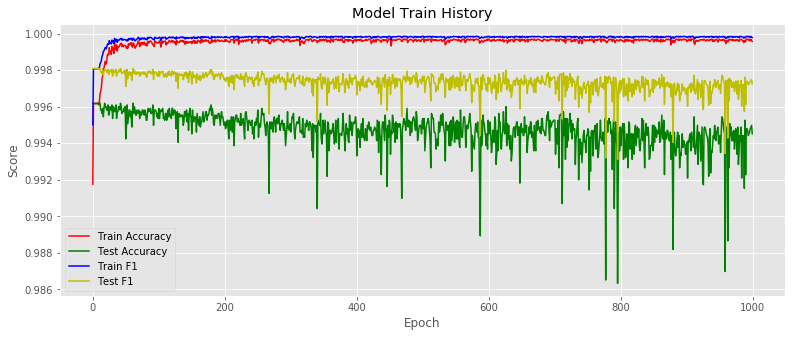

CLASSIFIER PERFORMANCE MICROWAVE MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,microwave,99.45,99.62,99.83,99.72,49.86,0.01,0.5,41,10711



CONFUSION MATRIX (OFF/ON):

 - microwave:
[[    0    41]
 [   18 10693]]



In [18]:
# Model fit...
for i in range(labels_binary.shape[1]):
    
#     log_dir = os.path.join(
#         "logs",
#         "fit",
#         datetime.now().strftime("%Y%m%d-%H%M%S"),
#     )#"./logs/{}".format(time())
#     tbCallback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    callbacks_ = [
#         EarlyStopping(
#             monitor = 'val_f1', 
#             mode='max',
#             patience = 100
#         ),
        ModelCheckpoint(
            filepath="models/{}-{}-{}-best.h5".format("rp", "binary", valid_appliances[i]), 
            monitor='val_f1', 
            save_best_only=True
        )
    ]
    
    print("")
    print("---> Splitting `{}` data (train/test)...")
    X_train, X_test, y_train, y_test = train_test_split(
        series_images, labels_binary[:, i],
        stratify = labels_binary[:, i],
        random_state=SEED, test_size=TEST_SIZE#, shuffle=True
    )

    print("---> Training the `{}` model...\n".format(valid_appliances[i]))
    #model = cnn_model(output_layer_length=1)
    model = dcnn_appliance()#input_shape_=X_train[0,:,:].shape)
    
    # Calibrating model..
    callback = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test), 
        epochs=EPOCHS, batch_size=BATCH_SIZE,
        verbose = 2, callbacks = callbacks_
    )
    
    # Persisting model
    model.save("models/{}-{}-{}.h5".format("rp", "binary", valid_appliances[i]))
    
    # Plot metrics...
    fig = plt.figure(figsize=(13,5))
    line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
    line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
    line_f1_m = plt.plot(callback.history["f1"], label = "Train F1", color = "b")
    line_val_f1_m = plt.plot(callback.history["val_f1"], label = "Test F1", color = "y")
    plt.title("Model Train History")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

    # Final report (validated on test set)
    y_pred = np.array(model.predict(X_test).round())
    #classification_report(y_test[:, i], y_pred, labels = valid_appliances)
    classification_report_appliance(y_test, y_pred, label = valid_appliances[i])
    
    print("")

In [ ]:
# Model fit...
for i in range(y_train.shape[1]):
    print("Training the `{}` model...\n".format(valid_appliances[i]))
    
    #model = cnn_model(output_layer_length=1)
    model = vgg_appliance()
    #image = preprocess_input(image)
    
    # Calibrating model..
    callback = model.fit(
        X_train, y_train[:, i],
        validation_data=(X_test, y_test[:, i]), 
        epochs=100, batch_size=32,
        verbose = 2, callbacks = [tbCallback]
    )
    
    # Plot metrics...
    fig = plt.figure(figsize=(13,5))
    line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
    line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
    line_f1_m = plt.plot(callback.history["f1"], label = "Train F1", color = "b")
    line_val_f1_m = plt.plot(callback.history["val_f1"], label = "Test F1", color = "y")
    plt.title("Model Train History")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

    # Final report (validated on test set)
    y_pred = np.array(model.predict(X_test).round())
    #classification_report(y_test[:, i], y_pred, labels = valid_appliances)
    classification_report_appliance(y_test[:, i], y_pred, label = valid_appliances[i])
    
    print("")

#### Desblanceamento de Classes

In [19]:
# CLASS WEIGHT
from sklearn.utils import class_weight

# Model fit...
for i in range(labels_binary.shape[1]):
#     print("---> Training the `{}` model...\n".format(valid_appliances[i]))
    #model = cnn_model(output_layer_length=1)

    callbacks_ = [
#         EarlyStopping(
#             monitor = 'val_f1', 
#             mode='max',
#             patience = 100
#         ),
        ModelCheckpoint(
            filepath="models/{}-{}-{}-class_weight-best.h5".format("rp", "binary", valid_appliances[i]), 
            monitor='val_f1', 
            save_best_only=True
        )
    ]
    
    print("")
    print("---> Splitting `{}` data (train/test)...")
    X_train, X_test, y_train, y_test = train_test_split(
        series_images, labels_binary[:, i],
        stratify = labels_binary[:, i],
        random_state=SEED, test_size=TEST_SIZE#, shuffle=True
    )
    
    class_weights = class_weight.compute_class_weight(
        'balanced',
        np.unique(y_train),
        y_train
    )
    print("Class weights:", class_weights)
    
    print("---> Training the `{}` model...\n".format(valid_appliances[i]))
    #model = cnn_model(output_layer_length=1)
    model = dcnn_appliance()#input_shape_=X_train[0,:,:].shape)
    
    # Calibrating model..
    callback = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test), 
        epochs=EPOCHS, batch_size=BATCH_SIZE,
        verbose = 2, callbacks = callbacks_,
        class_weight = class_weights
    )
    
    # Persisting model
    model.save("models/{}-{}-{}-class_weight.h5".format("rp", "binary", valid_appliances[i]))
    
    # Plot metrics...
    fig = plt.figure(figsize=(13,5))
    line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
    line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
    line_f1_m = plt.plot(callback.history["f1"], label = "Train F1", color = "b")
    line_val_f1_m = plt.plot(callback.history["val_f1"], label = "Test F1", color = "y")
    plt.title("Model Train History")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

    # Final report (validated on test set)
    y_pred = np.array(model.predict(X_test).round())
    classification_report_appliance(y_test[:, i], y_pred, label = valid_appliances[i])
    
    print("")


IndexError: tuple index out of range

#### Focal Loss

In [ ]:
# CLASS WEIGHT
from sklearn.utils import class_weight

# Define our custom loss function
def focal_loss(y_true, y_pred):
    gamma = 2.0
    alpha = 0.25
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))

# Model fit...
for i in range(y_train.shape[1]):
    #model = cnn_model(output_layer_length=1)
    
    callbacks_ = [
#         EarlyStopping(
#             monitor = 'val_f1', 
#             mode='max',
#             patience = 100
#         ),
        ModelCheckpoint(
            filepath="models/{}-{}-{}-class_weight-focal_loss-best.h5".format("rp", "binary", valid_appliances[i]), 
            monitor='val_f1', 
            save_best_only=True
        )
    ]
    
    print("")
    print("---> Splitting `{}` data (train/test)...")
    X_train, X_test, y_train, y_test = train_test_split(
        series_images, labels_binary[:, i],
        stratify = labels_binary[:, i],
        random_state=SEED, test_size=TEST_SIZE#, shuffle=True
    )
    
    class_weights = class_weight.compute_class_weight(
        'balanced',
        np.unique(y_train),
        y_train
    )
    print("Class weights:", class_weights)

    print("---> Training the `{}` model...\n".format(valid_appliances[i]))
    #model = cnn_model(output_layer_length=1)
    model = dcnn_appliance(loss_function = focal_loss)
    
    # Calibrating model..
    callback = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test), 
        epochs=EPOCHS, batch_size=BATCH_SIZE,
        verbose = 2, callbacks = callbacks_,
        class_weight = class_weights
    )
    
    # Persisting model
    model.save("models/{}-{}-{}-class_weight-focal_loss.h5".format("rp", "binary", valid_appliances[i]))
    
    # Plot metrics...
    fig = plt.figure(figsize=(13,5))
    line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
    line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
    line_f1_m = plt.plot(callback.history["f1"], label = "Train F1", color = "b")
    line_val_f1_m = plt.plot(callback.history["val_f1"], label = "Test F1", color = "y")
    plt.title("Model Train History")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

    # Final report (validated on test set)
    y_pred = np.array(model.predict(X_test).round())
    classification_report_appliance(y_test[:, i], y_pred, label = valid_appliances[i])
    
    print("")

#### Training Set Oversampling

In [ ]:
print("Original shape:", X_train.shape)
print("Reshaped:", X_train.reshape(X_train.shape[0], -1).shape)
print("Reshaped to original:", X_train.reshape(X_train.shape[0], -1).reshape(X_train.shape).shape)


In [ ]:
from collections import Counter
print("Original distribution (training set):", Counter(y_train[:, 1]))

In [ ]:
from imblearn.over_sampling import RandomOverSampler
X_resampled, y_resampled = RandomOverSampler().fit_resample(
    X_train.reshape(X_train.shape[0], -1),
    y_train[:, 1]
)

print("New distribution (training set):", Counter(y_resampled))

In [ ]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

# Model fit...
for i in range(y_train.shape[1]):
    print("---> Training the `{}` model...\n".format(valid_appliances[i]))
    #model = cnn_model(output_layer_length=1)
    model = dcnn_appliance()
    
    # Resampling...
    X_train_resampled, y_train_resampled = RandomOverSampler().fit_resample(
        X_train.reshape(X_train.shape[0], -1),
        y_train[:, i]
    )
    X_train_resampled = X_train_resampled.reshape(
                    tuple(list([-1]) + list(X_train.shape[1:]))
                )
    
    # Calibrating model..
    callback = model.fit(
        X_resampled, y_resampled,
        validation_data=(X_test, y_test[:, i]), 
        epochs=100, batch_size=32,
        verbose = 2, callbacks = [tbCallback]#, callbacks = [tqdm_callback]
    )
    
    del X_resampled
    del y_resampled
    
    # Plot metrics...
    fig = plt.figure(figsize=(13,5))
    line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
    line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
    line_f1_m = plt.plot(callback.history["f1"], label = "Train F1", color = "b")
    line_val_f1_m = plt.plot(callback.history["val_f1"], label = "Test F1", color = "y")
    plt.title("Model Train History")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

    # Final report (validated on test set)
    y_pred = np.array(model.predict(X_test).round())
    classification_report_appliance(y_test[:, i], y_pred, label = valid_appliances[i])
    
    print("")

In [ ]:
# Model fit...
for i in range(y_train.shape[1]):
    print("---> Training the `{}` model...\n".format(valid_appliances[i]))
    #model = cnn_model(output_layer_length=1)
    model = dcnn_appliance()
    
    # Resampling...
    X_train_resampled, y_train_resampled = SMOTE().fit_resample(
        X_train.reshape(X_train.shape[0], -1),
        y_train[:, i]
    )
    X_train_resampled = X_train_resampled.reshape(
                    tuple(list([-1]) + list(X_train.shape[1:]))
                )
    
    # Calibrating model..
    callback = model.fit(
        X_resampled, y_resampled,
        validation_data=(X_test, y_test[:, i]), 
        epochs=100, batch_size=32,
        verbose = 2, callbacks = [tbCallback]#, callbacks = [tqdm_callback]
    )
    
    del X_resampled
    del y_resampled
    
    # Plot metrics...
    fig = plt.figure(figsize=(13,5))
    line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
    line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
    line_f1_m = plt.plot(callback.history["f1"], label = "Train F1", color = "b")
    line_val_f1_m = plt.plot(callback.history["val_f1"], label = "Test F1", color = "y")
    plt.title("Model Train History")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

    # Final report (validated on test set)
    y_pred = np.array(model.predict(X_test).round())
    classification_report_appliance(y_test[:, i], y_pred, label = valid_appliances[i])
    
    print("")

In [ ]:
# Model fit...
for i in range(y_train.shape[1]):
    print("---> Training the `{}` model...\n".format(valid_appliances[i]))
    #model = cnn_model(output_layer_length=1)
    model = dcnn_appliance()
    
    # Resampling...
    X_train_resampled, y_train_resampled = ADASYN().fit_resample(
        X_train.reshape(X_train.shape[0], -1),
        y_train[:, i]
    )
    X_train_resampled = X_train_resampled.reshape(
                    tuple(list([-1]) + list(X_train.shape[1:]))
                )
    
    # Calibrating model..
    callback = model.fit(
        X_resampled, y_resampled,
        validation_data=(X_test, y_test[:, i]), 
        epochs=100, batch_size=32,
        verbose = 2, callbacks = [tbCallback]#, callbacks = [tqdm_callback]
    )
    
    del X_resampled
    del y_resampled
    
    # Plot metrics...
    fig = plt.figure(figsize=(13,5))
    line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
    line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
    line_f1_m = plt.plot(callback.history["f1"], label = "Train F1", color = "b")
    line_val_f1_m = plt.plot(callback.history["val_f1"], label = "Test F1", color = "y")
    plt.title("Model Train History")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

    # Final report (validated on test set)
    y_pred = np.array(model.predict(X_test).round())
    classification_report_appliance(y_test[:, i], y_pred, label = valid_appliances[i])
    
    print("")

In [ ]:
# UNDERSAMPLING NO TESTE (???)
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Model fit...
for i in range(y_train.shape[1]):
    print("---> Training the `{}` model...\n".format(valid_appliances[i]))
    #model = cnn_model(output_layer_length=1)
    model = dcnn_appliance()
    
    # Resampling...
    X_train_resampled, y_train_resampled = RandomOverSampler().fit_resample(
        X_train.reshape(X_train.shape[0], -1),
        y_train[:, i]
    )
    X_train_resampled = X_train_resampled.reshape(
                    tuple(list([-1]) + list(X_train.shape[1:]))
                )
    X_test_resampled, y_test_resampled = RandomUnderSampler().fit_resample(
        test_rp_images.reshape(X_test.shape[0], -1),
        y_test[:, i]
    )
    X_test_resampled = X_test_resampled.reshape(
                    tuple(list([-1]) + list(X_test.shape[1:]))
                )
    
    # Calibrating model..
    callback = model.fit(
        X_train_resampled, y_train_resampled,
        validation_data=(X_test_resampled, y_test_resampled), 
        epochs=100, batch_size=32,
        verbose = 2, callbacks = [tbCallback]#, callbacks = [tqdm_callback]
    )
    
    # Plot metrics...
    fig = plt.figure(figsize=(13,5))
    line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
    line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
    line_f1_m = plt.plot(callback.history["f1"], label = "Train F1", color = "b")
    line_val_f1_m = plt.plot(callback.history["val_f1"], label = "Test F1", color = "y")
    plt.title("Model Train History")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

    # Final report (validated on test set)
    y_pred = np.array(model.predict(X_test_resampled).round())
    classification_report_appliance(y_test_resampled, y_pred, label = valid_appliances[i])
    
    print("")
    
    del X_train_resampled
    del y_train_resampled
    del X_test_resampled
    del y_test_resampled

# Amostras de Imagens Individuais

In [ ]:
# idx_appliance = 0

# index = np.where(
#     (y_train[:, idx_appliance] == 1) & 
#     (y_train[:, 1] == 0) & (y_train[:, 2] == 0) &
#     (y_train[:, 3] == 0) & (y_train[:, 4] == 0)
# )[0][0]

# print("Appliance `{}`:".format(valid_appliances[idx_appliance]))
# fig = plt.figure()
# plt.imshow(X_train[index])
# plt.axis('off')
# plt.savefig('resources/images/gaf-{}.png'.format(valid_appliances[idx_appliance].lower()), bbox_inches='tight', transparent=True)

# fig = plt.figure()
# plt.imshow(X_train[index])
# plt.axis('off')
# plt.savefig('resources/images/rp-{}.png'.format(valid_appliances[idx_appliance].lower()), bbox_inches='tight', transparent=True)

In [ ]:
# idx_appliance = 1

# index = np.where(
#     (yh3_train[:, idx_appliance] == 1) & 
#     (yh3_train[:, 0] == 0) & (yh3_train[:, 2] == 0) &
#     (yh3_train[:, 3] == 0) & (yh3_train[:, 4] == 0)
# )[0][0]

# print("Appliance `{}`:".format(valid_appliances[idx_appliance]))
# fig = plt.figure()
# plt.imshow(Xh3_train[index])
# plt.axis('off')
# plt.savefig('resources/images/gaf-{}.png'.format(valid_appliances[idx_appliance].lower()), bbox_inches='tight', transparent=True)

# fig = plt.figure()
# plt.imshow(Xh4_train[index])
# plt.axis('off')
# plt.savefig('resources/images/rp-{}.png'.format(valid_appliances[idx_appliance].lower()), bbox_inches='tight', transparent=True)

In [ ]:
# idx_appliance = 2

# index = np.where(
#     (yh3_train[:, idx_appliance] == 1) & 
#     (yh3_train[:, 0] == 0) & (yh3_train[:, 1] == 0) &
#     (yh3_train[:, 3] == 0) & (yh3_train[:, 4] == 0)
# )[0][0]

# print("Appliance `{}`:".format(valid_appliances[idx_appliance]))
# fig = plt.figure()
# plt.imshow(Xh3_train[index])
# plt.axis('off')
# plt.savefig('resources/images/gaf-{}.png'.format(valid_appliances[idx_appliance].lower()), bbox_inches='tight', transparent=True)

# fig = plt.figure()
# plt.imshow(Xh4_train[index])
# plt.axis('off')
# plt.savefig('resources/images/rp-{}.png'.format(valid_appliances[idx_appliance].lower()), bbox_inches='tight', transparent=True)

In [ ]:
# idx_appliance = 3

# index = np.where(
#     (yh3_train[:, idx_appliance] == 1) & 
#     (yh3_train[:, 0] == 0) & (yh3_train[:, 1] == 0) &
#     (yh3_train[:, 2] == 0) & (yh3_train[:, 4] == 0)
# )[0][0]

# print("Appliance `{}`:".format(valid_appliances[idx_appliance]))
# fig = plt.figure()
# plt.imshow(Xh3_train[index])
# plt.axis('off')
# plt.savefig('resources/images/gaf-{}.png'.format(valid_appliances[idx_appliance].lower()), bbox_inches='tight', transparent=True)

# fig = plt.figure()
# plt.imshow(Xh4_train[index])
# plt.axis('off')
# plt.savefig('resources/images/rp-{}.png'.format(valid_appliances[idx_appliance].lower()), bbox_inches='tight', transparent=True)

In [ ]:
# idx_appliance = 4

# index = np.where(
#     (yh3_train[:, idx_appliance] == 1) & 
#     (yh3_train[:, 0] == 0) & (yh3_train[:, 1] == 0) &
#     (yh3_train[:, 2] == 0) & (yh3_train[:, 3] == 0)
# )[0][0]

# print("Appliance `{}`:".format(valid_appliances[idx_appliance]))
# fig = plt.figure()
# plt.imshow(Xh3_train[index])
# plt.axis('off')
# plt.savefig('resources/images/gaf-{}.png'.format(valid_appliances[idx_appliance].lower()), bbox_inches='tight', transparent=True)

# fig = plt.figure()
# plt.imshow(Xh4_train[index])
# plt.axis('off')
# plt.savefig('resources/images/rp-{}.png'.format(valid_appliances[idx_appliance].lower()), bbox_inches='tight', transparent=True)

# Análise Adicional dos Dados

In [ ]:
yb1_train.shape

In [ ]:
for i, appliance in enumerate(valid_appliances):
    y_i = yb1_train[:, i]
    supp_0 = y_i[y_i==0].shape[0]
    supp_1 = y_i[y_i==1].shape[0]
    print(appliance, 
          "-> Suport OFF (y=0):", supp_0, "({}%)".format( round((supp_0/yb1_train.shape[0])*100,2) ),
          "/ Support ON (y=1):", supp_1, "({}%)".format( round((supp_1/yb1_train.shape[0])*100,2) ),
          "\n"
         )


# Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator

class BalancedDataGenerator(Sequence):
    """ImageDataGenerator + RandomOversampling"""
    def __init__(self, x, y, datagen, batch_size=32):
        self.datagen = datagen
        self.batch_size = batch_size
        self._shape = x.shape        
        datagen.fit(x)
        self.gen, self.steps_per_epoch = balanced_batch_generator(
            x.reshape(x.shape[0], -1), y, 
            sampler=RandomOverSampler(), 
            batch_size=self.batch_size, 
            keep_sparse=True
        )

    def __len__(self):
        return self._shape[0] // self.batch_size

    def __getitem__(self, idx):
        x_batch, y_batch = self.gen.__next__()
        x_batch = x_batch.reshape(-1, *self._shape[1:])
        return self.datagen.flow(x_batch, y_batch, batch_size=self.batch_size).next()
    
# x, y = ... # load your data
# datagen = ImageDataGenerator()
# balanced_gen = BalancedDataGenerator(x, y, datagen, batch_size=32)
# steps_per_epoch = balanced_gen.steps_per_epoch

# model = ... # define your model
# model.compile(...) # define your compile parameters
# model.fit_generator(balanced_gen, steps_per_epoch, ...)

In [ ]:
RecurrencePlot().fit_transform(tra)

In [ ]:
# datagen = ImageDataGenerator()

# steps_per_epoch = balanced_gen.steps_per_epoch

from imblearn.keras import BalancedBatchGenerator
# >>> from imblearn.under_sampling import NearMiss
# >>> training_generator = BalancedBatchGenerator(
# ...     X, y, sampler=NearMiss(), batch_size=10, random_state=42)
# >>> callback_history = model.fit_generator(generator=training_generator,
# ...                                        epochs=10, verbose=0)


balanced_gen = BalancedBatchGenerator(
    train_rp_images, 
    yb1_train[:, 1], 
    sampler=RandomOverSampler(), 
    batch_size=32,
    random_state = 33
)

model = cnn_model_appliance()
# Calibrating model..
callback = model.fit_generator(
    balanced_gen, 
    steps_per_epoch, 
    epochs = 100, 
    verbose = 2, 
    use_multiprocessing = True,
    workers = 6
)

# # Calibrating model..
# callback = model.fit_generator(
#     BalancedDataGenerator(
#         train_rp_images, 
#         yb1_train[:, 1], # Applaicne 1
#         ImageDataGenerator(), 
#         batch_size=32
#     ), 
#     epochs=100,
#     verbose = 2#, callbacks = [tqdm_callback]
# )  

In [ ]:
X_ = RecurrencePlot().fit_transform(np.load( os.path.join(BENCHMARKING1_RESOURCES_PATH, 'datasets/train_power_chunks.npy') ))

In [ ]:
for x in X:
    print(x.reshape((1,) + x.shape).shape)
    break

In [ ]:
from sklearn.datasets import load_iris
iris = load_iris()
from imblearn.datasets import make_imbalance
class_dict = dict()
class_dict[0] = 30; class_dict[1] = 50; class_dict[2] = 40
X, y = make_imbalance(iris.data, iris.target, class_dict)
X = X_
import tensorflow.keras as keras
y = keras.utils.to_categorical(y, 3)
model = keras.models.Sequential()
model.add(keras.layers.Dense(y.shape[1], input_dim=X.shape[1],
                              activation='softmax'))
model.compile(optimizer='sgd', loss='categorical_crossentropy',
               metrics=['accuracy'])
from imblearn.keras import BalancedBatchGenerator
from imblearn.under_sampling import NearMiss
training_generator = BalancedBatchGenerator(
     X, y, sampler=RandomOverSampler(), batch_size=10, random_state=42)
callback_history = model.fit_generator(generator=training_generator,
                                        epochs=10, verbose=0)

In [ ]:
X.shape

In [ ]:
# Model fit...
for i in range(yb1_train.shape[1]):
    print("---> Training the `{}` model...\n".format(valid_appliances[i]))
    #model = cnn_model(output_layer_length=1)
    model = cnn_model_appliance()
    
    # Calibrating model..
    callback = model.fit(
        train_rp_images, yb1_train[:, i],
        validation_data=(test_rp_images, yb1_test[:, i]), 
        epochs=100, batch_size=32,
        verbose = 2#, callbacks = [tqdm_callback]
    )
    
    # Plot metrics...
    fig = plt.figure(figsize=(13,5))
    line_acc = plt.plot(callback.history["acc"], label = "Train Accuracy", color="r")
    line_val_acc = plt.plot(callback.history["val_acc"], label = "Test Accuracy", color="g")
    line_f1_m = plt.plot(callback.history["f1_m"], label = "Train F1", color = "b")
    line_val_f1_m = plt.plot(callback.history["val_f1_m"], label = "Test F1", color = "y")
    plt.title("Model Train History")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

    # Final report (validated on test set)
    y_pred = np.array(model.predict(test_rp_images).round())
    classification_report_appliance(yb1_test[:, i], y_pred, label = valid_appliances[i])
    
    print("")

In [ ]:
del train_gaf_images
del test_gaf_images
del train_rp_images
del test_rp_images
del power_chunks

# Conclusões

A utilização de RPs para a classificação multirótulo de cargas, seja utilizando classificadores tradicionais ou DL, demonstra os melhores resultados considerando **Acurácia e F1**.

Para continuidade dos estudos, vamos avaliar a estratégia de construir classificadores especialistas (binários) para cada carga, utilizando modelos baseado em DL (CNN - e CapsNet, se possível), considerando tanto GAF quanto RPs.